# Introduction
Authors: J. Giblin-Burnham


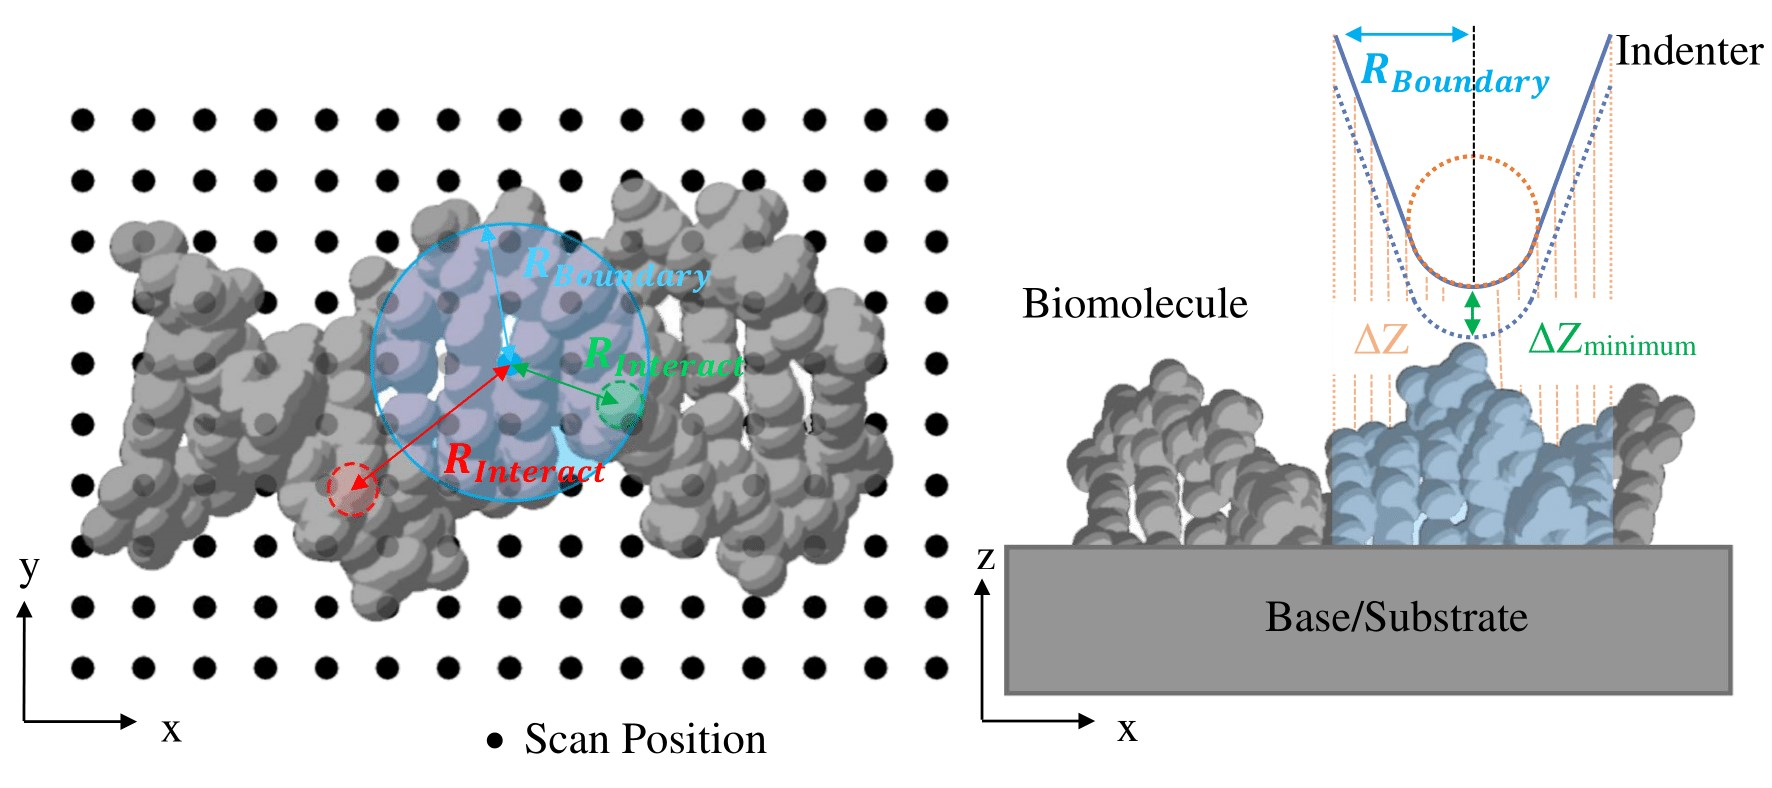

Simulating AFM images requires the calculation of contours of constant indentation force across a sample. Using Finite Element Modelling (FEM), the sample surface and probe tip geometry are recreated, and AFM raster scan dynamics are replicated by performing independent indentations across the surface. Biological structures are produced using Protein Data Bank (PDB) files with geometric dimensions in $\text{\AA}$. For simplicity, the biomolecule is modelled as an elastic material produced from the assembly of the individual atoms (with van der Waals radius). The molecule is partially embedded in a rigid base/ substrate and fixed at its base to simulate a soft molecule absorbed onto a solid support. The structure is assumed to be a continuous, homogeneous and isotropy elastic material. 

Scan positions are determined by subdividing the XY domain and calculating corresponding initial indenter heights. Initial heights are computed from hard-sphere/ tangential contact points, ensuring consistent indentation depths across the surface. The tangent points between the surfaces are calculated by setting the tip above the sample and determining the minimum vertical distance between the tip and the molecule's surface. Above illustrates the calculations. By computing the vertical distances between the indenter's surface and atoms within the indenter's boundary ($R_{Boundary}$), an array of height differences ($\Delta Z$) is obtained. As illustrated the minimum $\Delta Z$ value corresponds to the tangential contact position. % Only positions where the tip and molecule interact are included for computational efficiency.

Extracting simulated vertical forces and displacements produces a four-dimensional array of indenter positions and forces. Subsequently, contours are computed using a indentation force, generating the final AFM images. Contours are calculated from force-indentation data via list comprehension, extracting the depth at which the indentation force exceeds a given indentation force. Linear or power normalisation is applied depending on detail contrast, and images are interpolated using bi-cubic interpolation to increase pixel density.

## Flow Chart

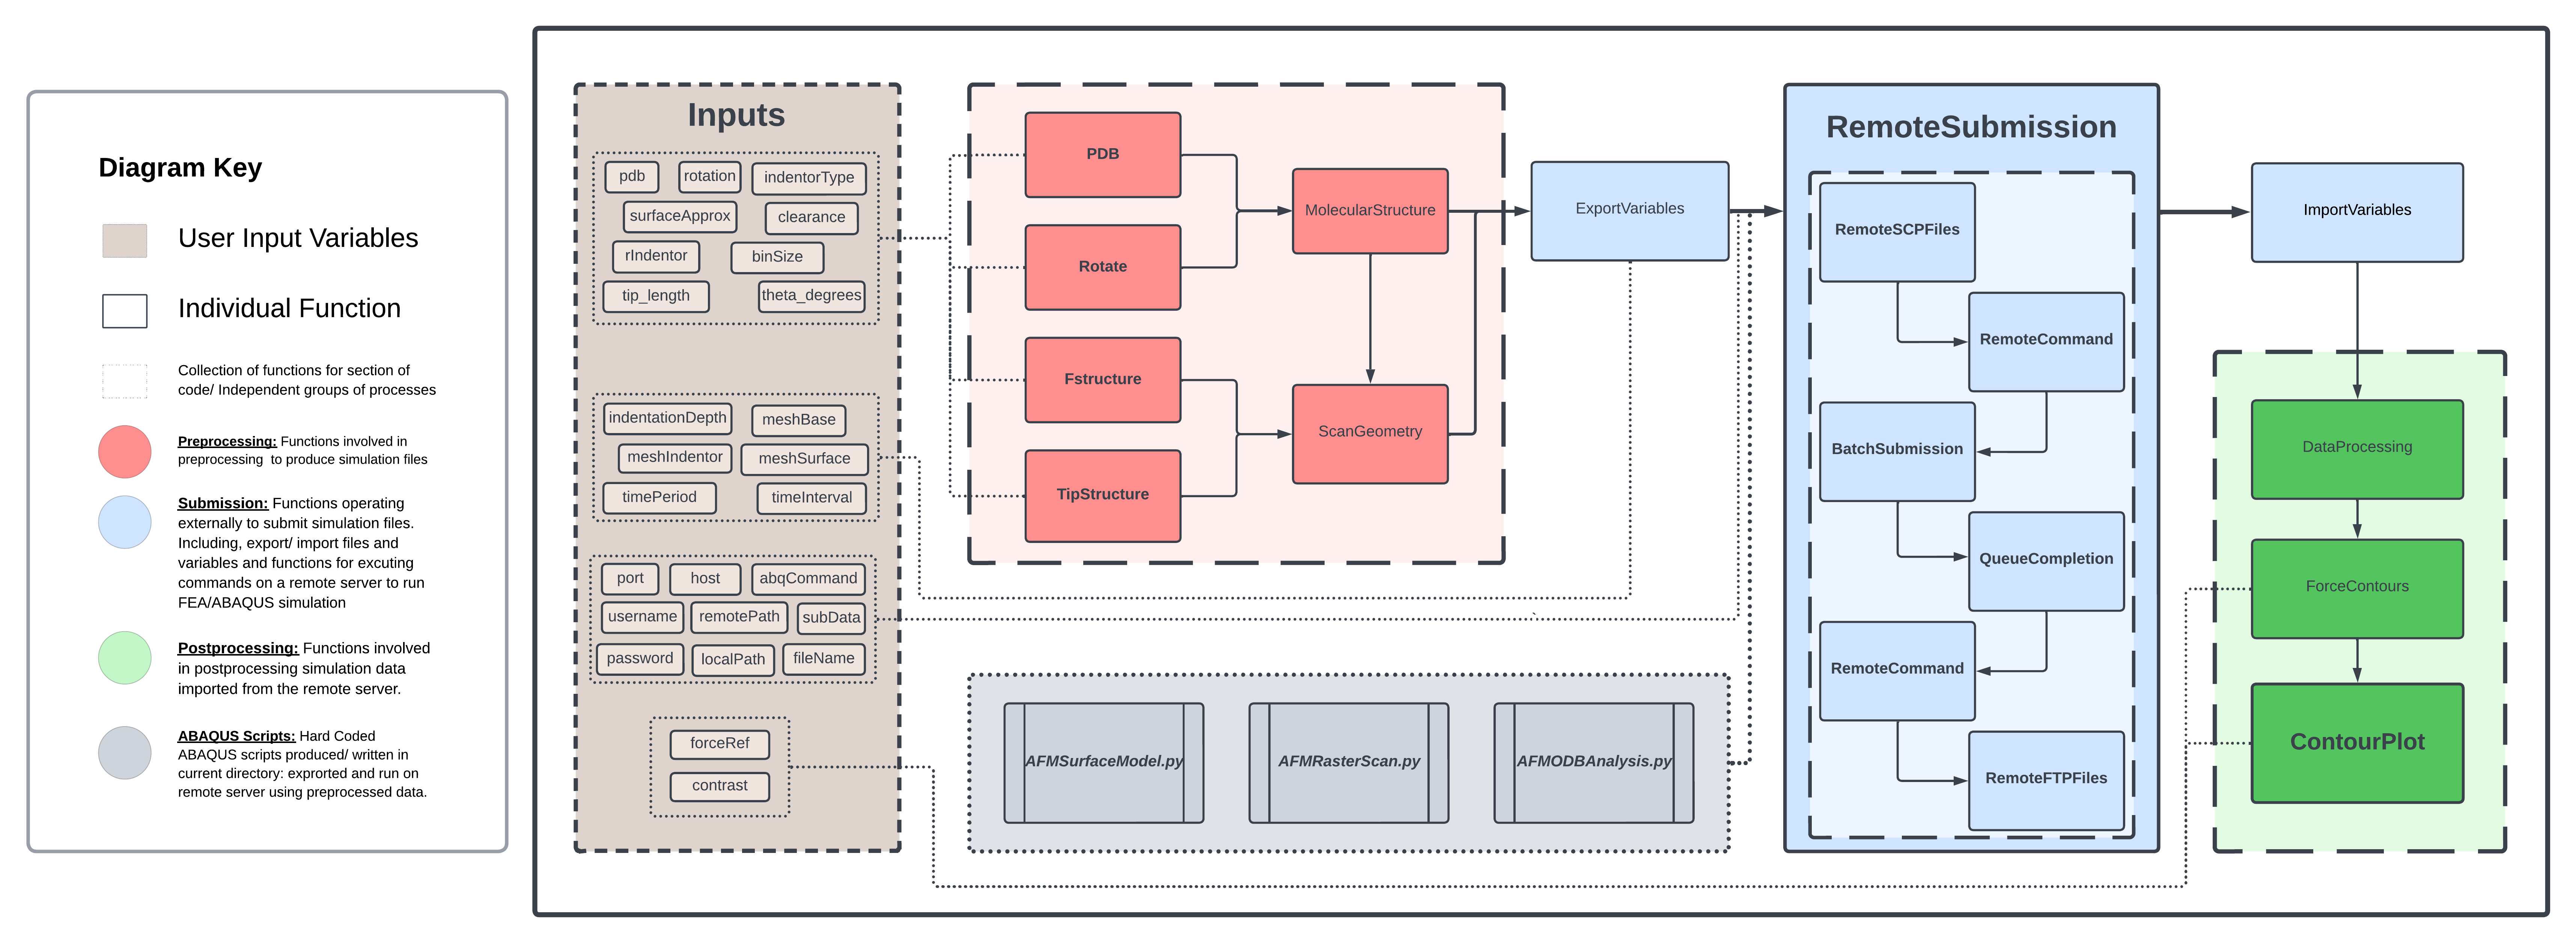

# Code Framework

## Imports

In [1]:
# import sys
# -------------------------------------- Possible modules to pip instal-------------------------------------------------
# !{sys.executable} -m pip install py3Dmol
# !{sys.executable} -m pip install nglview
# !{sys.executable} -m pip install biopython
# !{sys.executable} -m pip install mendeleev
# !{sys.executable} -m pip install pyabaqus==2022
# !{sys.executable} -m pip install paramiko

In [2]:
# --------------------------------------------------System Imports-----------------------------------------------------
import os
import sys
import time
import subprocess
from datetime import timedelta
from platform import python_version
import socket
import paramiko
from scp import SCPClient

# ---------------------------------------------Mathematical/Plotting Imports--------------------------------------------
# Importing relevant maths and graphing modules
import numpy as np 
import math
from numpy import random   
from random import randrange

# Interpolation/ Fittting modules
from scipy.interpolate import UnivariateSpline #, RegularGridInterpolator, RectBivariateSpline, LinearNDInterpolator, interpn
from scipy.optimize import curve_fit
from scipy.signal import convolve2d  
from scipy import stats

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 5.92765763889 # inch
plt.rcParams["figure.figsize"] = (1.61*linewidth, linewidth)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# For displaying images in Markdown
from IPython.display import Image 

# -----------------------------------------------Specific Imports-------------------------------------------------------
# PDB stuff:From video: youtube.com/watch?v=mL8NPpRxgJA&ab_channel=CarlosG.Oliver
from Bio.PDB import *
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import Entity

# Atomic properties amd molecule visualistion
from mendeleev.fetch import fetch_table
from mendeleev import element
import nglview as nv
import py3Dmol

## ABAQUS Scripts

ABAQUS is run automatically using seperate python scripts defined below. These are transfered to remote server and run using bash commands to produce input files before running simulations.

### Biological Surface Creation Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to create parts for simulation

In [3]:
%%writefile AFMSurfaceModel.py
# ----------------------------------------------Load Modules----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from part import *
from section import *
from assembly import *
import odbAccess
import cProfile, pstats, io

# ------------------------------------------------Set variables-------------------------------------------------------
atom_coord   = np.loadtxt('atom_coords.csv', delimiter=",")
atom_element = np.loadtxt("atom_elements.csv", dtype = 'str', delimiter=",")

keys     = np.loadtxt('atom_radius_keys.csv', dtype = 'str', delimiter=",")
values   = np.loadtxt('atom_radius_values.csv', delimiter=",")
atom_radius = {keys[i]:values[i] for i in range(len(keys))}

baseDims  = np.loadtxt('baseDims.csv', delimiter=",")
tipDims   = np.loadtxt('tipDims.csv', delimiter=",")
rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims  

with open('indentorType.txt', 'r') as f:
    indentorType = f.read()

#  -------------------------------------------------Model--------------------------------------------------------------
modelName = 'AFMSurfaceModel'
model = mdb.Model(name=modelName)

# ------------------------------------------------Create Atom Parts---------------------------------------------------- 
for atom in list(atom_radius.keys()):
    # Cretae base atoms (as spheres with vdw radius) to form the biomolecule  
    r = atom_radius[atom]
    sketch = model.ConstrainedSketch(name = atom, sheetSize=1.0)   
    model.sketches[atom].ConstructionLine(point1=(0,r),point2=(0,-r))
    model.sketches[atom].ArcByCenterEnds(center=(0,0),point1=(0,r),point2=(0,-r), direction = CLOCKWISE)
    model.sketches[atom].Line(point1=(0,r),point2=(0,-r))
    part = model.Part(name=atom, dimensionality=THREE_D, type=DEFORMABLE_BODY)
    model.parts[atom].BaseSolidRevolve( angle=360.0, flipRevolveDirection=OFF, sketch= model.sketches[atom] )    

    
# ----------------------------------------------Create Molecule Assembly------------------------------------------------
# Centre coordinate system
model.rootAssembly.DatumCsysByDefault(CARTESIAN)

# Cretae biomolecule by looping through atom list and merge part instances of the individual atoms
for i, coord in enumerate(atom_coord):
    atom = atom_element[i]
    # For atoms part of molecule above the base 
    if coord[2] >= -atom_radius[atom]:
        # Create new part instance for each atom in molecule and translate to position from coordinate list
        model.rootAssembly.Instance(name='instance'+str(i), part = model.parts[atom], dependent=ON)
        model.rootAssembly.translate(instanceList = ('instance'+str(i),) , vector = (coord[0],coord[1],coord[2]) )

# Merge the atomic part instances to make molecule part and part instance 
Instances_List = list(model.rootAssembly.instances.keys())
model.rootAssembly.InstanceFromBooleanMerge(name='molecule',
                                            instances=([model.rootAssembly.instances[Instances_List[i]] 
                                                        for i in range(len(Instances_List))] ), 
                                            originalInstances=DELETE) 
# Delete individual atoms
for atom in list(atom_radius.keys()):
    del model.parts[atom]

# -----------------------------------------Create Base/Substrate Part---------------------------------------------------
# Create base part using predefined base dimensions in baseDims, add width/height to accomidate radius of indenter
model.ConstrainedSketch(name = 'base', sheetSize=1.0) 
model.sketches['base'].rectangle(point1=(-baseDims[0]/2-rIndentor,-baseDims[1]/2-rIndentor), 
                                 point2=( baseDims[0]/2+rIndentor, baseDims[1]/2+rIndentor) )
model.Part(name='base', dimensionality=THREE_D, type= DEFORMABLE_BODY)
model.parts['base'].BaseSolidExtrude(sketch= model.sketches['base'], depth = baseDims[2])    

# Create as base part instance
model.rootAssembly.Instance(name='base', part = model.parts['base'], dependent=ON)
model.rootAssembly.translate(instanceList = ('base',) , vector = (0,0,-baseDims[2]) )

# ----------------------------------------------Create Surface Part-----------------------------------------------------
# Create biomolecule surface by cut any of the molecule intersecting the base  
model.rootAssembly.Instance(name='molecule', part = model.parts['molecule'], dependent=ON)
model.rootAssembly.InstanceFromBooleanCut(name= 'surface', instanceToBeCut=model.rootAssembly.instances['molecule'], 
                                          cuttingInstances=(model.rootAssembly.instances['base'],),
                                          originalInstances=DELETE)
# Delete unclipped molecule part
del model.parts['molecule'] 

# -----------------------------------------------Create Tip Part--------------------------------------------------------
# If set, create Capped-Conical Indentor using predefined dimensions in tipDims. Using rigid/ incompressible shell part
if indentorType == 'Capped':
    
    sketch = model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,-rIndentor),point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(r_int,z_int), point2=(r_top,z_top))
    model.sketches['indentor'].Line(point1=(0,-rIndentor), point2=(0,z_top))
    model.sketches['indentor'].Line(point1=(0,z_top), point2=(r_top,z_top))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0), point1=(r_int,z_int), point2=(0,-rIndentor),
                                               direction =CLOCKWISE)  
    model.Part(name='indentor', dimensionality=THREE_D, type= DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve(angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])
    
    plane = model.parts['indentor'].DatumPlaneByPrincipalPlane(offset= tip_length/3, principalPlane=XZPLANE)
    model.parts['indentor'].PartitionFaceByDatumPlane(datumPlane = model.parts['indentor'].datums[plane.id], 
                                                      faces = model.parts['indentor'].faces.getSequenceFromMask(('[#2 ]', ),))
    
# Otherwise create Spherical Indentor part using rIndentor only
else:
    model.ConstrainedSketch(name = 'indentor', sheetSize=1.0)   
    model.sketches['indentor'].ConstructionLine(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0),point1=(0,rIndentor),point2=(0,-rIndentor), 
                                               direction = CLOCKWISE)
    model.sketches['indentor'].Line(point1=(0,rIndentor),point2=(0,-rIndentor))
    model.Part(name='indentor', dimensionality=THREE_D, type=DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseShellRevolve( angle=360.0, flipRevolveDirection=OFF, sketch=model.sketches['indentor'])


# ----------------------------------------------Export Part Files-----------------------------------------------------
model.parts['surface'].writeAcisFile( fileName = 'surface' )
model.parts['base'].writeAcisFile( fileName = 'base' )
model.parts['indentor'].writeAcisFile( fileName = 'indentor' )

# Save Model 
mdb.saveAs(modelName +'.cae')

Overwriting AFMSurfaceModel.py


### Raster Scan AFM Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to create ABAQUS input files at each position in the raster scan. These are used to performm the independent analysis/ simulation at each position.

In [4]:
%%writefile AFMRasterScan.py
# ----------------------------------------------Load Modules----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
import subprocess
import os
import __main__
executeOnCaeStartup()


# ------------------------------------------------Set variables-------------------------------------------------------
# Import predefined variables from files set in current directory
variables = np.loadtxt('variables.csv', delimiter=",")
elasticProperties =  np.loadtxt('elasticProperties.csv', delimiter=",")
baseDims  = np.loadtxt('baseDims.csv', delimiter=",")
tipDims   = np.loadtxt('tipDims.csv', delimiter=",")

clipped_scanPos  = np.loadtxt('clipped_scanPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims  

with open('indentorType.txt', 'r') as f:
    indentorType = f.read()
    
#  -----------------------------------------------Set Model-------------------------------------------------------------
modelName =  'AFMRasterScan'

# Open surface model with parts and rename to simulation model
mdb.openAuxMdb( pathName = os.getcwd() + os.sep +'AFMSurfaceModel.cae')
mdb.copyAuxMdbModel(fromName='AFMSurfaceModel', toName = modelName)
mdb.closeAuxMdb()

# Set model variable for briefity
model = mdb.models[modelName]


# ------------------------------------------------Set Parts----------------------------------------------------------- 
# Alternatively, model can be set and indiviadual parts can be imported however shapes detail can be lost in import
# model = mdb.Model(name=modelName)

# # Create Surface part 
# surface = mdb.openAcis(fileName = 'surface' )
# model.PartFromGeometryFile(name = 'surface', geometryFile = surface , dimensionality =THREE_D, 
#                            type = DEFORMABLE_BODY)

# # Create Base part
# base = mdb.openAcis(fileName = 'base' )
# model.PartFromGeometryFile(name= 'base', geometryFile = base, dimensionality = THREE_D,
#                            type = DEFORMABLE_BODY)   

# # Create Indentor part
# indentor = mdb.openAcis(fileName = 'indentor' )
# model.PartFromGeometryFile(name= 'indentor', geometryFile = indentor, dimensionality = THREE_D, 
#                            type = DISCRETE_RIGID_SURFACE)    
    
    
# ----------------------------------------------Set Assembly----------------------------------------------------------
model.rootAssembly.DatumCsysByDefault(CARTESIAN)

# Regenerate part instances and orientate base and indentor
model.rootAssembly.Instance(name='surface', part = model.parts['surface'],dependent=ON)
model.rootAssembly.Instance(name='indentor', part = model.parts['indentor'], dependent=ON)
model.rootAssembly.Instance(name='base', part = model.parts['base'], dependent=ON)

model.rootAssembly.rotate(instanceList = ('indentor',), axisPoint = (0,0,0), axisDirection = (1,0,0), angle = 90)
model.rootAssembly.translate(instanceList = ('base',) , vector = (0,0,-baseDims[2]) )

# Delete duplicate of part instance
del model.rootAssembly.instances['molecule-1'] 
del model.rootAssembly.instances['surface-1'] 
 
    
# ----------------------------------------------Set Geometry----------------------------------------------------------
# Create geometric sets and surfaces for each parts faces and cells - these sets are used to reference in model set up

# Surface sets and gemoetric surface for contact
model.parts['surface'].Set(cells= model.parts['surface'].cells.getSequenceFromMask(mask=('[#1fff]', ), ), 
                         name='surface_cells')

model.parts['surface'].Set( name='surface_base', faces= 
                           model.parts['surface'].faces.getByBoundingBox(-baseDims[0]/2,-baseDims[1]/2,-0.5,
                                                                         baseDims[0]/2,baseDims[1]/2,0.5))
# Base sets and surfaces
model.parts['base'].Set(faces= model.parts['base'].faces.getSequenceFromMask(mask=('[#20]', ),),name='base_faces')
model.parts['base'].Set(cells= model.parts['base'].cells.getSequenceFromMask(mask=('[#1]', ),), name='base_cells')


# Indentor sets and surfaces
if indentorType == 'Capped':
    # For Spherically Capped geometry
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#f]', ), ),
                                name='indentor_faces')    
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#9]', ), ))    
else:
    # For Spherical geometry
    model.parts['indentor'].Set(faces= model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ),
                                name='indentor_faces')                      
    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Faces = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1]', ), ))    
# Create reference points for indentor
point = model.parts['indentor'].ReferencePoint((0, 0, 0))
model.parts['indentor'].Set(referencePoints = (model.parts['indentor'].referencePoints[point.id],),
                            name = 'indentor_centre')

model.rootAssembly.regenerate()


# -----------------------------------------------Set Properties-------------------------------------------------------
# Assign materials, using elastic and visoelastic properties
elastic = (tuple(elasticProperties), )
viscoelastic = ((0.0403,0,0.649),(0.0458,0,1.695),)

# Assign molecule surface material
model.Material(name='surface_material')
model.materials['surface_material'].Elastic(table = elastic)
# model.materials['surface_material'].Viscoelastic(domain = FREQUENCY, frequency = PRONY, table = viscoelastic )
model.HomogeneousSolidSection(name='section', material='surface_material', thickness=None)
model.parts['surface'].SectionAssignment(region=model.parts['surface'].sets['surface_cells'],sectionName='section')

# Assign base/substrate large (incompressible) material
model.Material(name='base_material')
model.materials['base_material'].Elastic(table = ((1e15,0.4),))
model.HomogeneousSolidSection(name='base_section', material='base_material', thickness=None)
model.parts['base'].SectionAssignment(region = model.parts['base'].sets['base_cells'], sectionName='base_section')


# ------------------------------------------------Set Steps-----------------------------------------------------------
model.StaticStep(name='Indentation', previous='Initial', description='', timePeriod=timePeriod, 
                 timeIncrementationMethod=AUTOMATIC, maxNumInc=int(1e5), initialInc=0.1, minInc=1e-20, maxInc=1)

model.steps['Indentation'].control.setValues(allowPropagation=OFF, resetDefaultValues=OFF, 
                                timeIncrementation=(4.0, 8.0, 9.0, 16.0, 10.0, 4.0, 12.0, 25.0, 6.0, 3.0, 50.0))

field = model.FieldOutputRequest('F-Output-1', createStepName='Indentation', variables=('RF', 'TF', 'U'), 
                                 timeInterval = timeInterval)


# ----------------------------------------------Set Interactions------------------------------------------------------
# Set  Contact Behaviour
model.ContactProperty(name ='Contact Properties')
model.interactionProperties['Contact Properties'].TangentialBehavior(formulation = FRICTIONLESS) #PENALTY FRICTION
model.interactionProperties['Contact Properties'].NormalBehavior(pressureOverclosure=HARD)

# Set Ridged Indentor                                 
model.RigidBody(name = 'indentor_constraint', 
                bodyRegion = model.rootAssembly.instances['indentor'].sets['indentor_faces'],
                refPointRegion = model.rootAssembly.instances['indentor'].sets['indentor_centre'])


# -----------------------------------------------Set Loads------------------------------------------------------------
# Create base boundary conditions
model.DisplacementBC(name = 'Base-BC', createStepName = 'Initial', 
                     region = model.rootAssembly.instances['base'].sets['base_faces'], 
                     u1 = SET, u2 = SET, u3 = SET, ur1 = SET, ur2 = SET, ur3 = SET)

# Create surface boundary conditions
model.DisplacementBC(name = 'Surface-BC', createStepName = 'Initial', 
                     region = model.rootAssembly.instances['surface'].sets['surface_base'], 
                     u1 = SET, u2 = SET, u3 = SET, ur1 = SET, ur2 = SET, ur3 = SET)

# Create indentor boundary conditions
model.DisplacementBC(name = 'Indentor-UC', createStepName = 'Indentation',                  
                     region = model.rootAssembly.instances['indentor'].sets['indentor_centre'], 
                     u1 = SET, u2 = SET, u3 = -indentionDepth,
                     ur1 = SET, ur2 = SET, ur3 = SET)

    
# ------------------------------------------------Set Mesh------------------------------------------------------------
# Assign an element type to the part instance- seed and generate
model.rootAssembly.regenerate()

# Assign surface mesh using tetrahedral elements
elemType1 = mesh.ElemType(elemCode=C3D20R, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=C3D15, elemLibrary=STANDARD)
elemType3 = mesh.ElemType(elemCode=C3D10, elemLibrary=STANDARD)
cells     =  model.parts['surface'].cells.getSequenceFromMask(mask=('[#1]', ), )

model.parts['surface'].seedPart(size=meshSurface, deviationFactor=0.01, minSizeFactor=0.95)
model.parts['surface'].setMeshControls(regions=cells, elemShape=TET, sizeGrowthRate=1.64, technique=FREE)
model.parts['surface'].setElementType(regions=(cells,), elemTypes=(elemType1, elemType2, elemType3))
model.parts['surface'].generateMesh()


# Assign indentor mesh using triangular elements
elemType1 = mesh.ElemType(elemCode=R3D4, elemLibrary=STANDARD)
elemType2 = mesh.ElemType(elemCode=R3D3, elemLibrary=STANDARD)
faces     = model.parts['indentor'].faces.getSequenceFromMask(mask=('[#1 ]', ),)

model.parts['indentor'].seedPart(size=meshIndentor, minSizeFactor=0.25)
model.parts['indentor'].setMeshControls(regions=faces, elemShape=TRI)
model.parts['indentor'].setElementType(regions=(faces,), elemTypes=(elemType1, elemType2))

if indentorType == 'Capped':
    # Long edge above partition
    model.parts['indentor'].seedEdgeBySize(constraint=FINER, size=3*meshIndentor, edges = model.parts['indentor'].edges.getSequenceFromMask(('[#20 ]', ),))
    # Long edge partition portion
    model.parts['indentor'].seedEdgeByBias(biasMethod=SINGLE, maxSize=meshIndentor, minSize=0.1*meshIndentor, constraint=FINER, 
                                           end2Edges = model.parts['indentor'].edges.getSequenceFromMask(('[#2 ]', ), ))
    # Spherical tip mesh
    model.parts['indentor'].seedEdgeBySize(constraint=FINER, size=0.1*meshIndentor, deviationFactor=0.1, 
                                           edges = model.parts['indentor'].edges.getSequenceFromMask(('[#40 ]', ), ))
model.parts['indentor'].generateMesh()



# Assign base mesh using tetrahedral elements
model.parts['base'].seedPart(size = meshBase )
model.parts['base'].setElementType(model.rootAssembly.instances['base'].sets['base_faces'], 
                                      elemTypes = (mesh.ElemType(elemCode=QUAD, elemLibrary=STANDARD),))
model.parts['base'].setMeshControls(regions=model.rootAssembly.instances['base'].sets['base_faces'].vertices, 
                                       elemShape=TET,technique=FREE)
model.parts['base'].generateMesh()


## ----------------------------------------------Set Submission--------------------------------------------------------
for i in range(len(clipped_scanPos)):  
    
    # ---------------------------------------Translate Indentor position-----------------------------------------------
    # Translate indentor to raster scan position
    model.rootAssembly.translate(instanceList = ('indentor',),
                                 vector = (clipped_scanPos[i,0], clipped_scanPos[i,1], clipped_scanPos[i,2] + rIndentor )) 
    model.rootAssembly.regenerate()
        
    # -----------------------------------------Set Surface Interactions------------------------------------------------
    # Define surface-indentor contact region
    model.parts['surface'].Surface(name       = 'surface_top', 
                                   side1Faces = model.parts['surface'].faces.getByBoundingCylinder((clipped_scanPos[i,0], clipped_scanPos[i,1], 5), 
                                                                                                   (clipped_scanPos[i,0], clipped_scanPos[i,1], clipped_scanPos[i,2]+tip_length), 
                                                                                                   1.4*r_top))

    # Define surface-surface contact for each body only around indentor
    model.SurfaceToSurfaceContactStd(name = 'surface-indentor', 
                                     createStepName = 'Initial', 
                                     master     = model.rootAssembly.instances['indentor'].surfaces['indentor_surface'], 
                                     slave = model.rootAssembly.instances['surface'].surfaces['surface_top'],
                                     interactionProperty = 'Contact Properties', 
                                     sliding = FINITE)
    
    # ----------------------------------------------Create Input file--------------------------------------------------
    # Create input file for simulation position
    jobName   = 'AFMRasterScan-Pos'+str(int(i))
    job = mdb.Job(name=jobName, model=modelName, description='AFM')
    job.writeInput()

    if i == int(len(clipped_scanPos)/2):
        mdb.saveAs('AFMRasterScan.cae')
        
    # -------------------------------------------------Reset Model-----------------------------------------------------    
    # Reset indentor position to centre
    model.rootAssembly.translate(instanceList = ('indentor',),
                                 vector = (-clipped_scanPos[i,0], -clipped_scanPos[i,1], -(clipped_scanPos[i,2] + rIndentor) ))
    
    del model.parts['surface'].surfaces['surface_top']
    del model.interactions['surface-indentor']

Overwriting AFMRasterScan.py


### ODB Analysis Script
Create Python file in current directory (using magic command %%) used to run on ABAQUS to analysis odb files for each position in the raster scan. Extracting indentation data.

In [5]:
%%writefile AFMODBAnalysis.py
# ----------------------------------------------Load Modules-----------------------------------------------------------
import sys
import os
from os.path import exists

from odbAccess import *
from types import IntType
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
executeOnCaeStartup()

# ------------------------------------------------Set variables-------------------------------------------------------
# Import predefined variables from files set in current directory
variables        = np.loadtxt('variables.csv', delimiter=",")
clipped_scanPos  = np.loadtxt('clipped_scanPos.csv', delimiter=",")

timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables

# Set array for indentation data: RF - Indentor reaction force , U2 - Indentor displacement, N - no. timesteps
N = int(timePeriod/ timeInterval)+1
RF = np.zeros([len(clipped_scanPos),N])
U2 = np.zeros([len(clipped_scanPos),N])
ErrorMask = np.zeros([len(clipped_scanPos)])
    
# ----------------------------------------------Set Data extraction---------------------------------------------------
for i in range(len(clipped_scanPos)):
    # Log Analysis Progression in text file
    with open('Progress.txt', 'a') as f:
        f.write('File '+str(i)+'\n')

    jobName = 'AFMRasterScan-Pos'+str(int(i))  
    
    # Check if odb file is veiwable and no corrupted data which my throw an error
    try :
        # Open odb and retrieve data for indentor reference point(2nd value in models nodal sets/ region)
        odb    = openOdb(jobName +'.odb', readOnly=True)
        region = odb.rootAssembly.nodeSets.values()[1]
    except:        
        # If theres an error log odb file value in text file
        with open('Errors.txt', 'a') as f:
            f.write('ERROR for'+str(i)+'\n')
        ErrorMask[i] = 1
    else:          
        # Extracting data for Step 1, this analysis only had one step
        step1 = odb.steps.values()[0]

        # Counting frames/ timesteps
        j,k = 0, 0 
        
        # Creating a for loop to iterate through all frames in the step
        for x in odb.steps[step1.name].frames:
            
            # Reading force and displacement data from the model at reference point
            fieldRF = x.fieldOutputs['RF'].getSubset(region= region)
            fieldU  = x.fieldOutputs['U'].getSubset(region= region)    

            # Storing reaction force and displacement values for the current frame
            for rf in fieldRF.values:
                RF[i,j] = np.sqrt(rf.data[2]**2)
                j+=1         

            for u in fieldU.values:
                U2[i,k] = u.data[2] 
                k+=1   

# Writing to a .csv file
np.savetxt("U2_Results.csv", U2 , delimiter=",")
np.savetxt("RF_Results.csv", RF , delimiter=",")   
np.savetxt("ErrorMask.csv", ErrorMask , delimiter=",")   

# Close the odb
odb.close()    

Overwriting AFMODBAnalysis.py


## Simulation Script Functions
Functionalised code to automate scan and geometry calculations, remote server access, remote script submission, data anlaysis and postprocessing required to produce AFM image.

### Pre-Processing Functions
Functions used in preprocessing step of simulation, including calculating scan positions and exporting variables.

#### Biomolecule PDB Function
Function to imports the relevant PDB file (and takes care of the directory) in which it is saved etc for the user, returning the structure and the view using a widget.

In [6]:
def PDB(pdbid, localPath, **kwargs):
    '''
    This function imports the relevant PDB file (and takes care of the directory) in which it is saved etc for the user, 
    returning the structure and the view using a widget.
    
        Parameters:
            pdbid (str) - PDB (or CSV) file name of desired biomolecule
            
            kwargs:
                CustomPDB - Extract data from local custom pd as opposed to from PDB online
            
        Returns:
            structure (class) - Class containing proteins structural data (Atom coords/positions and masses etc...)
            view (class)      - Class for visualising the protein
    '''
    # Set biopython variables
    pdbl       = PDBList()
    parser     = MMCIFParser(QUIET=True)
    pdb_parser = PDBParser(QUIET=True,PERMISSIVE=1)
    
    # Retrieves PDB file from 4 letter code using Bio.python
    pdbl.retrieve_pdb_file(pdbid)
    
    ### Creating a folder on the Users system- location is the same as the Notebook file's
    split_pdbid = list(pdbid)
    structure_file_folder = str(split_pdbid[1]) + str(split_pdbid[2])
    
    if 'CustomPDB' in kwargs.keys() and kwargs['CustomPDB'] == True:
        # Retrieving file from the location it is saved in. os.sep set `the_slashes` as '/' for MAC and Google Colab or '//' for Windows
        file_loc = localPath + os.sep + pdbid + '.pdb'
        
        # Defining structure i.e. '4 letter PDB ID code' and 'location'
        structure = pdb_parser.get_structure(pdbid, file_loc) 
        
    else:
        # Retrieving file from the location it is saved in. 
        file_loc = localPath + os.sep + structure_file_folder + os.sep + pdbid + '.cif'
        
        # Defining structure i.e. '4 letter PDB ID code' and 'location'
        structure = parser.get_structure(pdbid, file_loc) 
    
    # Plotting relevant structure using py3Dmol 
    viewer_name = 'pdb:' + pdbid
    view = py3Dmol.view(query=viewer_name).setStyle({'cartoon':{'color':'spectrum'}})
    
    return(structure, view)


#### Tip Functions
Functions to produce list of tip structural parameters, alongside function to calculates and returns tip surface heights from radial  position r.

In [7]:
def TipStructure(rIndentor, theta_degrees, tip_length): 
    '''
    Produce list of tip structural parameters. Change principle angle to radian. Calculate tangent point where 
    sphere smoothly transitions to cone for capped conical indentor.
    
        Parameters:
            theta_degrees (float) - Principle conical angle from z axis in degrees
            rIndentor (float)     - Radius of spherical tip portion
            tip_length (float)    - Total cone height
            
        Returns:
            tipDims (list) - Geometric parameters for defining capped tip structure     
    '''
    theta = theta_degrees*(np.pi/180)
    
    # Intercept of spherical and conical section of indentor (Tangent point) 
    r_int, z_int = rIndentor*abs(np.cos(theta)), -rIndentor*abs(np.sin(theta))
    # Total radius/ footprint of indentor/ top coordinates
    r_top, z_top = (r_int+(tip_length-r_int)*abs(np.tan(theta))), tip_length-rIndentor
    
    return [rIndentor, theta, tip_length, r_int, z_int, r_top, z_top]

In [8]:
def Zconical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherically capped conical tip surface heights from radial  position r. Uses radial coordinate along
    xy plane from centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xy radial coordinate location for tip height to be found
            r0 (float)         - xy radial coordinate for centre of tip
            r_int (float)      - xy radial coordinate of tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point, where sphere smoothly transitions to cone (defined for tip centred at spheres 
                                 center, as calculations assume tip centred at indentors bottom the value must be corrected to, R-z_int) 
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xy radial coordinate 
    '''
    
    ### Constructing conical and spherical parts boundaries of tip using arrays for computation speed
    # ------------------------------------------------Spherical Boundary------------------------------------------------
    # For r <= r_int, z <= z_int : (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  + ( R^2 - (r-r0)^2 )^1/2   
    
    # Using equation of sphere compute height (points outside sphere radius are complex and return nan, 
    # nan_to_num is used to set these points to max value R). The heights are clip to height of tangent point, R-z_int. 
    # Producing spherical portion for r below tangent point r_int and constant height R-zint for r values above r_int.
    
    z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
    # z1 = np.clip( np.where( np.isnan( R - np.sqrt(R**2 - (r-r0)**2) ) , R, R - np.sqrt(R**2 - (r-r0)**2) ), a_min = 0 , a_max = R-np.abs(z_int))

    # -------------------------------------------------Conical Boundary-------------------------------------------------
    # r > r_int, z > z_int : z = m*abs(x-x0);  where x = r, x0 = r0 + r_int,  m = 1/tan(theta)
    
    # Using equation of cone (line) to compute height for r values larger than tangent point r_int (using where condition) 
    # For r values below r_int the height is set to zero
    
    z2 =np.where(abs(r-r0)>=r_int, (abs(r-r0)-r_int)/abs(np.tan(theta)), 0)
    
    # ------------------------------------------------Combing Boundaries------------------------------------------------
    # For r values less than r_int, combines spherical portion with zero values from conical, producing spherical section
    # For r values more than r_int, combines linear conical portion with R-z_int values from spherical, producing cone section
    Z = z1 + z2 
    
    # Optional mask values greater than tip length
    # Z = np.ma.masked_greater(z1+z2, tip_length )
    return Z

In [9]:
def Zspherical(r, r0, r_int, z_int, theta, R, tip_length):
    '''
    Calculates and returns spherical tip surface heights from radial  position r. Uses radial coordinate along xy plane from 
    centre as tip is axisymmetric around z axis (bottom of tip set as zero point such z0 = R).
    
        Parameters:
            r (float/1D arr)   - xy radial coordinate location for tip height to be found
            r0 (float)         - xy radial coordinate for centre of tip
            r_int (float)      - xy radial coordinate for tangent point (point where sphere smoothly transitions to cone)
            z_int (float)      - Height of tangent point (point where sphere smoothly transitions to cone)
            theta (float)      - Principle conical angle from z axis in radians
            R (float)          - Radius of spherical tip portion
            tip_length (float) - Total cone height
            
        Returns:
            Z (float/1D arr)- Height of tip at xy radial coordinate 
    '''
    # Simple spherical equation: (z-z0)^2 +  (r-r0)^2 = R^2 --> z = z0  - ( R^2 - (r-r0)^2 )^1/2  
    return ( R - np.sqrt(R**2 - (r-r0)**2) ) 

#### Surface Functions
Functions to orientate biomolecule, extract atomic positions and elements from structural data and calculate bse/substrate dimensions.

In [10]:
def Rotate(domain, rotation):
    '''
    Rotate coordinates of a domain around each coordinate axis by angles given.
        Parameters:
            domain (arr)    - Array of [x,y,z] coordinates in domain to be rotated (Shape: (3) or (N,3) )
            rotation (list) - Array of [xtheta, ytheta, ztheta] rotational angle around coordinate axis:
                              # xtheta(float), angle in degrees for rotation around x axis (Row)
                              # ytheta(float), angle in degrees for rotation around y axis (Pitch)
                              # ztheta(float), angle in degrees for rotation around z axis (Yaw)
        Returns:
             rotate_domain(arr) - Rotated coordinate array
    '''
    xtheta, ytheta, ztheta = (np.pi/180)*np.array(rotation)
    
    # Row, Pitch, Yaw rotation matrices
    R_x = np.matrix( [[1,0,0],[0,np.cos(xtheta),-np.sin(xtheta)],[0,np.sin(xtheta),np.cos(xtheta)]] )   
    R_y = np.matrix( [[np.cos(ytheta),0,np.sin(ytheta)],[0,1,0],[-np.sin(ytheta),0,np.cos(ytheta)]] )
    R_z = np.matrix( [[np.cos(ztheta),-np.sin(ztheta),0],[np.sin(ztheta),np.cos(ztheta),0],[0,0,1]] )
    
    # Complete rotational matrix, from matrix multiplication
    R = R_x * R_y * R_z
    
    return np.array((R*np.asmatrix(domain).T).T)

In [11]:
def MolecularStructure(structure, rotation, tipDims, indentorType, binSize, surfaceApprox):
    ''' 
    Extracts molecular data from structure class and returns array of molecules atomic coordinate and element names. Alongside, producing dictionary
    of element radii and calculating base dimensions. All distances given in Angstroms (x10-10 m).
    
        Parameters:
            structure (class)     - Class containing proteins structural data (Atom coords/positions and masses etc...)
            rotation (list)       - Array of [x,y,z] rotational angle around coordinate axis'
            tipDims (list)        - Geometric parameters for defining capped tip structure     
            indentorType (str)    - String defining indentor type (Spherical or Capped)
            binSize (float)       - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            surfaceApprox (float) - Percentage of biomolecule assumed to be not imbedded in base/ substrate. Range: 0-1 
       
        Returns:
            atom_coord (arr)      - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)    - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)    - Dictionary containing van der waals radii each the element in the biomolecule 
            surfaceHeight (float) - Maximum height of biomolecule in z direction
            baseDims (arr)        - Geometric parameters for defining base/ substrate structure [width, height, depth]           
    '''
    
    #  --------------------------------------Setup Molecule Elements---------------------------------------------------
    # Extract atom element list as array
    atom_list  = structure.get_atoms()
    elements = list(fetch_table('elements')['symbol'])    
    atom_element = np.array([atom.element[0] if len(atom.element)==1 else atom.element[0] + atom.element[1:].lower() for atom in atom_list])
    
    # Produce dictionary of element radii in angstrom (using van de waals or vdw_radius_dreiding vdw_radius_mm3 vdw_radius_uff )
    atom_radius = dict.fromkeys(np.sort(atom_element))
    for atom in list(atom_radius.keys()):  
        if atom in elements:
            atom_radius[atom] = element(atom).vdw_radius_uff/100  
        else:
            atom_radius[atom] = element('C').vdw_radius_uff/100 
    
    
    #  --------------------------------------Setup Molecule Geometry---------------------------------------------------
    # Extract atom coordinates list as array in angstrom 
    atom_list  = structure.get_atoms()
    atom_coord = np.array([atom.coord for atom in atom_list]) 
    
    # Rotate coordinates of molecule
    atom_coord = Rotate(atom_coord, rotation)

    # Find extent of molecule extent
    surfaceMaxX, surfaceMinX = atom_coord[:,0].max(), atom_coord[:,0].min()
    surfaceMaxY, surfaceMinY = atom_coord[:,1].max(), atom_coord[:,1].min()
    surfaceMaxZ, surfaceMinZ = atom_coord[:,2].max(), atom_coord[:,2].min()
    
    surfaceWidthX = abs(surfaceMaxX-surfaceMinX)
    surfaceWidthY = abs(surfaceMaxY-surfaceMinY)
    surfaceWidthZ = abs(surfaceMaxZ-surfaceMinZ)
    
    # Centre molecule geometry in xy and set z=0 at the top of the base with percentage of height not imbedded
    atom_coord[:,0] = atom_coord[:,0] - surfaceMinX - surfaceWidthX/2
    atom_coord[:,1] = atom_coord[:,1] - surfaceMinY - surfaceWidthY/2
    atom_coord[:,2] = atom_coord[:,2] - surfaceMinZ - surfaceWidthZ*surfaceApprox

    
    #  --------------------------------------Setup Base/Surface Geometry---------------------------------------------------
    # Extract tip dimensions
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    # Set indentor height functions and indentor radial extent/boundry for z scanPos calculation.
    if indentorType == 'Capped':
        # Extent of conical indentor is the radius of the top portion
        rBoundary  =  r_top
    else:
        # Extent of spherical indentor is the radius
        rBoundary  = rIndentor
    
    # Calculate maximum surface height with added clearance. Define substrate/Base dimensions using biomolecules extent in x and y and boundary of indentor
    surfaceHeight = 1.5*(atom_coord[:,2].max()) 
    baseDims      = np.rint([surfaceWidthX+4*rBoundary+binSize, surfaceWidthY+4*rBoundary+binSize, 2*np.max(list(atom_radius.values()))+1])
        
    return atom_coord, atom_element, atom_radius, surfaceHeight, baseDims

#### Scan Functions
Calculate scan positions of tip over surface and vertical set points above surface for each position. In addition, function to plot and visualise molecules surface and scan position.

In [12]:
def ScanGeometry(atom_coord, atom_radius, atom_element, indentorType, tipDims, baseDims, surfaceHeight, binSize, clearance, **kwargs):
    ''' 
    Produces array of scan locations and corresponding heights/ tip positions above surface in Angstroms (x10-10 m). Also return an array including only positions 
    where tip interact with the sample. The scan positions are produced creating a rectangular grid over bases extent with widths bin size.Heightss, at each position, 
    are calculated by set tip above sample and calculating vertical distance between of tip and molecules surface over the indenters area. Subsequently, the minimum 
    vertical distance corresponds to the position where tip is tangential.
    
        Parameters:
            atom_coord (arr)      - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_radius (dict)    - Dictionary containing van der waals radii each the element in the biomolecule 
            atom_element (arr)    - Array of elements names(str) for atoms in biomolecule 
            indentorType (str)    - String defining indentor type (Spherical or Capped)
            tipDims (list)        - Geometric parameters for defining capped tip structure     
            baseDims (arr)        - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            surfaceHeight (float) - Maximum height of biomolecule in z direction
            binSize (float)       - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float)     - Clearance above molecules surface indentor is set to during scan
            
        Returns:
            scanPos (arr)         - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr) - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                    initial heights [x,y,z] to image biomolecule
            scanDims (arr)        - Geometric parameters for defining scan dimensiond [width, height] 
    '''

    # Initialise scan dimensions
    if 'ClippedScan' in kwargs and kwargs['ClippedScan'] != False:
        scanDims = np.array([ baseDims[0]*kwargs['ClippedScan'][0],  baseDims[1]*kwargs['ClippedScan'][1] ])
    else:
        scanDims = np.copy(baseDims[:2])

    #  ------------------------------------Set Scan Positions from Scan Geometry---------------------------------------------
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1

    # Create rectangular grid of xy scan positions over base using meshgrid. 
    x = np.linspace(-scanDims[0]/2, scanDims[0]/2, xNum)

    if 'NLinearScale' in kwargs and kwargs['NLinearScale']==True:
        # dist   = stats.norm(loc=0, scale=scanDims[1]/5)
        # bounds = dist.cdf([-scanDims[1]/2, scanDims[1]/2])
        # y      = dist.ppf(np.linspace(*bounds, yNum))
        
        b = np.e
        if yNum%2==0:
            y = np.concatenate((-np.logspace(0, np.log(scanDims[1]/2), int(yNum/2), base=b)[::-1], np.logspace(0, np.log(scanDims[1]/2), int(yNum/2), base=b)))
        else:
            y = np.concatenate((-np.logspace(0, np.log(scanDims[1]/2), int((yNum-1)/2), base=b)[::-1], np.zeros(1), np.logspace(0, np.log(scanDims[1]/2), int((yNum-1)/2), base=b)))

    else:
        y = np.linspace(-scanDims[1]/2, scanDims[1]/2, yNum)
        
    # Produce xy scan positions of indentor, set initial z height as clearance
    scanPos = np.array([ [x[i], y[j], clearance] for j in range(len(y)) for i in range(len(x)) ])
    
    #  --------------------------------------Set Vertical Scan Positions Positions -------------------------------------------   
    # Extract each atoms radius using radius dictionary [Natoms]
    rElement  = np.vectorize(atom_radius.get)(atom_element)    
    # Extract tip dimensions
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims
    
   # Set indentor height functions and indentor radial extent/boundry for z scanPos calculation.
    if indentorType == 'Capped':
        # Extent of conical indentor is the radius of the top portion
        rBoundary  =  r_top
        Zstructure = Zconical
    else:
        # Extent of spherical indentor is the radius
        rBoundary  = rIndentor
        Zstructure = Zspherical                  
            
    # Array of radial positions along indentor radial extent. Set indentor position/ coordinate origin at surface height 
    # (z' = z + surfaceHeight) and calculate  vertical heights along the radial extent. 
    r = np.linspace(-rBoundary, rBoundary, 50)
    zIndentor = Zstructure(r, 0, r_int, z_int, theta, rIndentor, tip_length) + surfaceHeight
    
    # Create array dividing/defining scan positions into chunks so only process 1.1e8 elements each loop to optimise data usage 
    N = np.linspace(0, xNum*yNum, int(np.ceil(xNum*yNum*len(atom_coord)/1.1e8)+1), dtype=int)

    # Loop over each chunk on scan positions
    for j in range(len(N)-1):
        
        # Calculate radial distance from scan position to each atom centre giving array of  [scanPos, Natoms]
        rInteract = np.sqrt( (atom_coord[:,0]-scanPos[N[j]:N[j+1],0,None])**2 + (atom_coord[:,1]-scanPos[N[j]:N[j+1],1,None])**2 ) 

        # Mask atoms outside the indenter boundary for each scan position and produce corresponding element radius and z positions array. Compress to remove masked values
        rInteractMasked = np.ma.masked_greater(rInteract, rBoundary+rElement)
        mask = np.ma.getmask(rInteractMasked) 
        rInteractMasked = [ rInteractMasked[i].compressed() for i in range(N[j+1]-N[j]) ]
        zAtomMasked     = [ np.ma.masked_array(atom_coord[:,2], mask = mask[i]).compressed() for i in range(N[j+1]-N[j]) ]
        rElementMasked  = [ np.ma.masked_array( rElement, mask = mask[i] ).compressed() for i in range(N[j+1]-N[j]) ]

        # Find vertical distances from atoms to indentor surface over all scan positions inside np.nan_num(nan_num removes any infinites). Minus from zIndentor to calculate the 
        # difference in the indentor height and the atoms surface at each point along indenoter extent, produces a dz array of all the height differences between indentor and 
        # surface atoms within the indentors boundary around this position. Find the minimum (ensurring maximum is surface height with initial). Therefore, z' = -dz  gives an 
        # array of indentor positions when each individual part of surface atoms contacts the tip portion above. Translating from z' basis (with origin at z = surfaceHeight) to 
        # z basis (with origin at the top of the base) is achieved by perform translation z = z' + surfaceheight. Therefore, these tip position are given by dz = surfaceheight-dz'. 
        # The initial height corresponds to the maximum value of dz/ min value of dz' where the tip is tangential to the surface. I.e. when dz' is minimised all others dz' tip 
        # positions will be above/ further from the surface. Therefore, at this position, the rest of the indentor wil  not be in contact with the surface and it is tangential.    

        dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)), 
                                                          copy=False, nan=0 )).min(initial=surfaceHeight)   for i in range(N[j+1]-N[j]) ])
        scanPos[N[j]:N[j+1],2] = surfaceHeight - abs(dz) + clearance 
    
    #  ---------------------------------------------Clip Scan position ---------------------------------------------------------    
    # Include only positions where tip interact with the sample. Scan position equal clearance, corresponds to indentor at base height 
    # therfore, can't indent surface (where all dz' heights were greater than surface height )
    clipped_scanPos = np.array([ [ scanPos[i,0], scanPos[i,1], scanPos[i,2] ] for i in range(len(scanPos)) if scanPos[i,2] != clearance ])
            
    return scanPos, clipped_scanPos, scanDims

In [13]:
def DotPlot(atom_coord, atom_radius, atom_element, scanPos, clipped_scanPos, pdb, **kwargs):
    ''' 
    Plot the molecules atoms surfaces and scan positions to visualise and check positions.
    
        Parameters:
            atom_coord (arr)        - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_radius (dict)      - Dictionary containing van der waals radii each the element in the biomolecule 
            atom_element (arr)      - Array of elements names(str) for atoms in biomolecule 
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
            pdb (str)               - PDB (or CSV) file name of desired biomolecule
            
            kwargs: 
                        SaveImages (str)  - If Contour images to be saved include kwarg specifying the file path to folder
    '''
    # Set range of polar/ azimuthal angles for setting atoms surface positions  
    polar     = np.linspace(-np.pi, np.pi, 16)
    azimuthal = np.linspace(0, np.pi, 16)
    
    # Initialise count variable
    k=-1
    
    # Create array of all atom surface positions includung embedded
    surfacatomPos = np.zeros([ len(atom_coord)*len(polar)*len(azimuthal), 3 ])
    # For each atom, loop over polar angles and azimuthal angles
    for i, r in enumerate(atom_coord):
        for phi in polar:
            for theta in azimuthal:
                # Count array index
                k+=1
                
                # Unpack coordinates of atom centre and atom radius
                x0, y0, z0 = r
                R = atom_radius[atom_element[i]]
                
                # Calculate surface coordinate using spherical coordinates
                surfacatomPos[k,0] = x0 - R*np.cos(phi)*np.sin(theta)
                surfacatomPos[k,1] = y0 - R*np.sin(phi)*np.sin(theta)
                surfacatomPos[k,2] = z0 - R*np.cos(theta)
    
    
    # Initialise count variables           
    nB=0   
    k=-1
    
    # Create array of all atom surface positions above base
    clipped_surfacatomPos = np.zeros([ len(atom_coord)*len(polar)*len(azimuthal), 3 ])
    for i, r in enumerate(atom_coord):
        
        #  Set atom radius for atoms with surface above base 
        R = atom_radius[atom_element[i]]   
        if r[2] >= -R:
            # Count atom
            nB+=1
            # For each atom, loop over polar angles and azimuthal angles
            for phi in polar:
                for theta in azimuthal:
                    # Count array index
                    k+=1
                    
                    # Unpack coordinates of atom centre
                    x0, y0, z0 = r

                    # Calculate surface coordinate using spherical coordinates
                    clipped_surfacatomPos[k,0] = x0 - R*np.cos(phi)*np.sin(theta)
                    clipped_surfacatomPos[k,1] = y0 - R*np.sin(phi)*np.sin(theta)
                    clipped_surfacatomPos[k,2] = z0 - R*np.cos(theta)   
    
    # Return number of atoms and scan positions
    print('Number of Atoms in Molecuel:', nB)
    
    # Plot Surface incuding imbedded portin and all scan positions  
    fig1 = plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(surfacatomPos[:,0], surfacatomPos[:,1], surfacatomPos[:,2], label = 'All Atom Surfaces')
    ax1.scatter3D(scanPos[:,0], scanPos[:,1], scanPos[:,2], label = 'All Scan Positons')
    ax1.set_xlabel(r'x (${\AA}$)')
    ax1.set_ylabel(r'y (${\AA}$)')
    ax1.set_zlabel(r'z (${\AA}$)')
    ax1.view_init(50, 145)    

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig1.savefig(kwargs['SaveImages'] + os.sep + 'AFMSimulationScanPos-'+pdb+'1.png', bbox_inches = 'tight', pad_inches=0.5) # change to backslash for mac/google colab
    
    plt.show()

    # Plot clipped surface and clipped scan positions
    fig2 = plt.figure()
    ax2 = plt.axes(projection='3d')
    ax2.scatter3D(clipped_surfacatomPos[::8,0], clipped_surfacatomPos[::8,1], clipped_surfacatomPos[::8,2],  label = 'Clipped Atom Surfaces')
    ax2.scatter3D(clipped_scanPos[:,0], clipped_scanPos[:,1], clipped_scanPos[:,2],  label = 'Clipped Scan Positons')
    ax2.set_xlabel(r'x (${\AA}$)')
    ax2.set_ylabel(r'y (${\AA}$)')
    ax2.set_zlabel(r'z (${\AA}$)')
    ax2.view_init(90, 0)
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig2.savefig(kwargs['SaveImages'] + os.sep + 'AFMSimulationScanPos-'+pdb+'2.png', bbox_inches = 'tight', pad_inches=0.5) # change to backslash for mac/google colab
    plt.show()

### Submission Functions

#### File Import/ Export 

In [14]:
def ExportVariables(atom_coord, atom_element, atom_radius, clipped_scanPos, scanPos, scanDims, variables, baseDims, tipDims, indentorType, elasticProperties ):
    ''' 
    Export simulation variables as csv and txt files to load in abaqus python scripts.
    
        Parameters:
            atom_coord (arr)       - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)     - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)     - Dictionary containing van der waals radii each the element in the biomolecule 
            clipped_scanPos (arr)  - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                     initial heights [x,y,z] to image biomolecule            
            scanPos (arr)          - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            scanDims (arr)         - Geometric parameters for defining scan dimensiond [width, height] 
            variables (list)       - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, 
                                     indentionDepth, surfaceHeight]
            baseDims (arr)         - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            tipDims (list)         - Geometric parameters for defining capped tip structure     
            indentorType (str)     - String defining indentor type (Spherical or Capped)
            elasticProperties(arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
    '''

    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)

    np.savetxt("data"+os.sep+"atom_coords.csv", atom_coord, delimiter=",")
    np.savetxt("data"+os.sep+"atom_elements.csv", atom_element, fmt='%s', delimiter=",")

    np.savetxt("data"+os.sep+"atom_radius_keys.csv", list(atom_radius.keys()), fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"atom_radius_values.csv", list(atom_radius.values()), delimiter=",")

    np.savetxt("data"+os.sep+"clipped_scanPos.csv", clipped_scanPos, delimiter=",")
    np.savetxt("data"+os.sep+"scanPos.csv", scanPos, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"scanDims.csv", scanDims, fmt='%s', delimiter=",")

    np.savetxt("data"+os.sep+"variables.csv", variables, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"baseDims.csv", baseDims, fmt='%s', delimiter=",")
    np.savetxt("data"+os.sep+"tipDims.csv", tipDims, fmt='%s', delimiter=",")

    np.savetxt("data"+os.sep+"elasticProperties.csv", elasticProperties, fmt='%s', delimiter=",")
    with open("data"+os.sep+'indentorType.txt', 'w', newline = '\n') as f:
        f.write(indentorType)

In [15]:
def ImportVariables():
    ''' 
    Import simulation geometry variables from csv files.
    
        Return:
            atom_coord (arr)        - Array of coordinates [x,y,z] for atoms in biomolecule 
            atom_element (arr)      - Array of elements names(str) for atoms in biomolecule 
            atom_radius (dict)      - Dictionary containing van der waals radii each the element in the biomolecule 
            variables (list)        - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, 
                                      indentionDepth, surfaceHeight]
            baseDims (arr)          - Geometric parameters for defining base/ substrate structure [width, height, depth]             
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
            scanDims (arr)         - Geometric parameters for defining scan dimensiond [width, height] 

    '''
    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)
 
    atom_coord      = np.loadtxt('data' + os.sep + 'atom_coords.csv', delimiter=",")
    atom_element    = np.loadtxt('data' + os.sep + 'atom_elements.csv', dtype = 'str', delimiter=",")

    keys            = np.loadtxt('data' + os.sep + 'atom_radius_keys.csv', dtype = 'str', delimiter=",")
    values          = np.loadtxt('data' + os.sep + 'atom_radius_values.csv', delimiter=",")
    atom_radius     = {keys[i]:values[i] for i in range(len(keys))}

    variables       = np.loadtxt('data' + os.sep + 'variables.csv', delimiter=",")
    baseDims        = np.loadtxt('data' + os.sep + 'baseDims.csv', delimiter=",")
    scanDims        = np.loadtxt('data' + os.sep + 'scanDims.csv', delimiter=",")
    scanPos         = np.loadtxt('data' + os.sep + 'scanPos.csv', delimiter=",")
    clipped_scanPos = np.loadtxt('data' + os.sep + 'clipped_scanPos.csv', delimiter=",")

    return atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos, scanDims

#### Remote Functions
Functions for working on remote serve, including transfering files, submitting bash commands, submiting bash scripts for batch input files and check queue statis.

##### Remote Connection

In [16]:
def SSHconnect(remote_server, **kwargs):
    ''' Function to open ssh connecction to remote server. A new Channel is opened and allows requested command to be executed in other functions. 
    The function allows for ProxyJumpp/Port Forwarding/SSH Tunelling.

        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                                    host (str)       - Hostname of the server to connect to
                                    port (int)       – Server port to connect to 
                                    username (str)   – username to authenticate as (defaults to the current local username)        -  
                                    password (str)   - Used for password authentication, None if ssh-key is used; is also used for private key 
                                                       decryption if passphrase is not given.
                                    sshkey (str)     - Path to private key for keyexchange if password not used, None if not used
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                                           
        Return: 
            ssh_client (obj) - SHH client object which allows for bash command execution and file transfer.
    '''

    host, port, username, password, sshkey, home, scratch = remote_server

    if 'ProxyJump' in kwargs:
        # Set variables for proxy port
        proxy_host, proxy_port, proxy_username, proxy_password, proxy_sshkey, proxy_home, proxy_scratch = kwargs['ProxyJump']
        hostname = socket.getfqdn()
        remote_addr = (host, int(port))
        local_addr  = (socket.gethostbyname_ex(hostname)[2][0], 22)

        # Create proxy jump/ ssh tunnel
        proxy_client = paramiko.SSHClient()
        proxy_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        proxy_client.connect(proxy_host, int(proxy_port), proxy_username, proxy_password, key_filename=proxy_sshkey)
        transport = proxy_client.get_transport()
        channel = transport.open_channel("direct-tcpip", remote_addr, local_addr)

        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey, sock=channel)
    
    else: 
        # SSH to clusters using paramiko module
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(host, int(port), username, password, key_filename=sshkey)

    return ssh_client

##### File Transfer

In [17]:
def RemoteSCPFiles(remote_server, files, remotePath, **kwargs):
    '''    
    Function to make directory and transfer files to SSH server. A new Channel is opened and the files are transfered. 
    The commands input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            files (list)         - File or list of file to transfer
            remotePath (str)     - Path to remote file/directory
            
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                path                     - Path to data files
    '''
    # SHH to clusters
    ssh_client = SSHconnect(remote_server, **kwargs)
    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath + '/')

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())

    if 'path' in kwargs and isinstance(kwargs['path'], str):
        scp_client.put([kwargs['path']+os.sep+file for file in files], recursive=True, remote_path = remotePath)
    else:
        scp_client.put(files, recursive=True, remote_path = remotePath)
        
    scp_client.close()
    
    ssh_client.close()

##### Bash Command Submission

In [18]:
def RemoteCommand(remote_server, script, remotePath, command, **kwargs):
    '''
    Function to execute a command/ script submission on the SSH server. A new Channel is opened and the requested command is executed. 
    The commands input and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            script (str)         - Script to run via bash command 
            remotePath (str)     - Path to remote file/directory
            command (str)        - Abaqus command to execute and run script   
                     
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    
    ssh_client = SSHconnect(remote_server, **kwargs)
    # Execute command
    stdin, stdout, stderr = ssh_client.exec_command('cd ' + remotePath + ' \n '+ command +' '+ script +' & \n')
    lines = stdout.readlines()

    ssh_client.close()
    
    for line in lines:
        print(line)

##### Batch File Submission

In [19]:
def BatchSubmission(remote_server, fileName, subData, scanPos, remotePath, **kwargs):
    ''' 
    Function to create bash script for batch submission of input file, and run them on remote server.
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            fileName (str)       - Base File name for abaqus input files
            subData (str)        - Data for submission to serve queue [walltime, memory, cpus]
            scanPos (arr)        - Array of coordinates [x,y] of scan positions to image biomolecule (can be clipped or full) 
            remotePath (str)     - Path to remote file/directory
            
            kwargs:
                ProxyJump (proxy_server)          - Optional define whether to use a Proxy Jump to ssh through firewall. Defines varibles for proxy server 
                                                    in list format [host, port, username, password, sshkey, home, scratch]
                Submission ('serial'/ 'paralell') - Optional define whether single serial script or seperate paralell submission to queue {Default: 'serial'}  
    '''   
    # For paralell mode create bash script to runs for single scan location, then loop used to submit individual scripts for each location which run in paralell
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        jobs = 'abaqus interactive cpus=$NSLOTS mp_mode=mpi job=$JOB_NAME input=$JOB_NAME.inp scratch=$ABAQUS_PARALLELSCRATCH resultsformat=odb'
        
    # Otherwise, create script to run serial analysis consecutively with single submission
    else:
        # Create set of submission comands for each scan locations
        jobs = ['abaqus interactive cpus=$NSLOTS memory="90%" mp_mode=mpi standard_parallel=all job='+fileName+str(int(i))+' input='+fileName+str(int(i))+'.inp scratch=$ABAQUS_PARALLELSCRATCH' 
                for i in range(len(scanPos))]
    
    # Produce preamble to used to set up bash script
    scratch = remote_server[-1]
    lines = ['#!/bin/bash -l',
             '#$ -S /bin/bash',
             '#$ -l h_rt='+ subData[0],
             '#$ -l mem=' + subData[1],
             '#$ -pe mpi '+ subData[2],
             '#$ -wd '+scratch,
             'module load abaqus/2017 ',
             'ABAQUS_PARALLELSCRATCH="'+scratch+'" ',
             'cd ' + remotePath 
            ]
        
    # Combine to produce total  script
    lines+=jobs

    # Create script file in current directory by writing each line to file
    with open('batchScript.sh', 'w', newline = '\n') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

    # SSH to clusters 
    ssh_client = SSHconnect(remote_server, **kwargs)
    stdin, stdout, stderr = ssh_client.exec_command('mkdir -p ' + remotePath)

    # SCPCLient takes a paramiko transport as an argument- Uploading content to remote directory
    scp_client = SCPClient(ssh_client.get_transport())
    scp_client.put('batchScript.sh', recursive=True, remote_path = remotePath)
    scp_client.close()
    
    # If paralell mode, submit  individual scripts for individual scan locations
    if 'Submission' in kwargs and kwargs['Submission'] == 'paralell':
        for i in range(len(scanPos)):
            # Job name set as each input file name as -N jobname is used as input variable in script
            jobName = fileName+str(int(i))
            # Command to run individual jobs
            batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

            # Execute command
            stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
            lines = stdout.readlines()
            print(lines)
    
    # Otherwise submit single serial scripts
    else:
        # Job name set as current directory name (change / to \\ for windows)
        jobName = remotePath.split('/')[-1]
        batchCommand = 'cd ' + remotePath + ' \n qsub -N '+ jobName +' batchScript.sh \n'

        # Execute command
        stdin, stdout, stderr = ssh_client.exec_command(batchCommand)
        lines = stdout.readlines()
        print(lines)
        
    ssh_client.close() 

##### Queue Status Function

In [20]:
def QueueCompletion(remote_server, **kwargs):
    '''
    Function to check queue statis and complete when queue is empty.
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                       
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    # Log time
    t0 = time.time()
    complete= False

    while complete == False:
        # SSH to clusters 
        ssh_client = SSHconnect(remote_server, **kwargs)

        # Execute command to view the queue
        stdin, stdout, stderr = ssh_client.exec_command('qstat')
        lines = stdout.readlines()
        
        # Check if queue is empty
        if len(lines)==0:
            print('Complete')
            complete = True
            ssh_client.close()   
        
        # Otherwis close and wait 2 mins before checking again
        else:
            ssh_client.close() 
            time.sleep(120)

    # Return total time
    t1 = time.time()
    print(t1-t0)

##### File Retrieval

In [21]:
def RemoteFTPFiles(remote_server, files, remotePath, localPath, **kwargs):
    ''' 
    Function to transfer files from directory on SSH server to local machine. A new Channel is opened and the files are transfered. 
    The function uses FTP file transfer.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            files (str )         - File to transfer
            remotePath (str)     - Path to remote file/directory
            localPath (str)      - Path to local file/directory

            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    ### Creating a folder on the Users system
    os.makedirs('data', exist_ok=True)
    
    # SSH to cluster
    ssh_client = SSHconnect(remote_server, **kwargs)

    # FTPCLient takes a paramiko transport as an argument- copy content from remote directory
    ftp_client=ssh_client.open_sftp()
    ftp_client.get(remotePath+'/'+files, localPath + os.sep + 'data'+ os.sep + files)  
    ftp_client.close()

##### Remote Terminal

In [22]:
def Remote_Terminal(remote_server, **kwargs):
    '''    
    Function to emulate cluster terminal. Channel is opened and commands given are executed. The command’s input 
    and output streams are returned as Python file-like objects representing stdin, stdout, and stderr.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                       
            kwargs:
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; 
                                           defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
    '''
    
    # SHH to cluster
    ssh_client = SSHconnect(remote_server, **kwargs)
    
    # Create channel to keep connection open
    ssh_channel = ssh_client.get_transport().open_session()
    ssh_channel.get_pty()
    ssh_channel.invoke_shell()
    
    # While open accept user input commands
    while True:
        command = input('$ ')
        if command == 'exit':
            break

        ssh_channel.send(command + "\n")
        
        # Return bash output from command
        while True:
            if ssh_channel.recv_ready():
                output = ssh_channel.recv(1024)
                print(output)
            else:
                time.sleep(0.5)
                if not(ssh_channel.recv_ready()):
                    break
    # Close cluster connection
    ssh_client.close()

#### Remote/ Local Submission 
Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine. Using keyword arguments invidual parts of simulation previously completed can be skipped.

In [23]:
def LocalSubmission():
    ''' Submit Abaqus scripts locally'''
    !abaqus fetch job=AFMSurfaceModel
    !abaqus cae -noGUI AFMSurfaceModel.py

    !abaqus fetch job=AFMRasterScan
    !abaqus cae -noGUI AFMRasterScan.py

    !abaqus fetch job=AFMODBAnalysis
    !abaqus cae -noGUI AFMODBAnalysis.py

In [24]:
def RemoteSubmission(remote_server, remotePath, localPath,  csvfiles, abqfiles, abqCommand, fileName, subData, clipped_scanPos, **kwargs):
    '''
    Function to run simulation and scripts on the remote servers. Files for variables are transfered, ABAQUS scripts are run to create parts and input files. 
    A bash file is created and submitted to run simulation for batch of inputs. Analysis of odb files is performed and data transfered back to local machine.
    Using keyword arguments invidual parts of simulation previously completed can be skipped.
    
        Parameters:
            remote_server (list)    - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
            remotePath (str)        - Path to remote file/directory
            localPath (str)         - Path to local file/directory
            csvfiles (list)         - List of csv and txt files to transfer to remote server
            abqfiles (list)         - List of abaqus script files to transfer to remote server
            abqCommand (str)        - Abaqus command to execute and run script
            fileName (str)          - Base File name for abaqus input files
            subData (str)           - Data for submission to serve queue [walltime, memory, cpus]
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and  initial heights [x,y,z] 
                                      to image biomolecule    
            kwargs:
                ProxyJump (proxy_server)          - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format 
                                                    [host, port, username, password, sshkey, home, scratch]
                Submission ('serial'/ 'paralell') - Type of submission, submit pararlell scripts or single serial script for scan locations {Default: 'serial'}
                Transfer (bool)                   - If false skip file transfer step of simulation {Default: True}
                Part (bool)                       - If false skip part creation step of simulation {Default: True}
                Input (bool)                      - If false skip input file creation step of simulation {Default: True}
                Batch (bool)                      - If false skip batch submission step of simulation {Default: True}
                Queue (bool)                      - If false skip queue completion step of simulation {Default: True}
                Analysis (bool)                   - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)                  - If false skip data file retrivial from remote serve {Default: True}
    '''
    #  ---------------------------------------------File Transfer----------------------------------------------------------
    if 'Transfer' not in kwargs.keys() or kwargs['Transfer'] == True:
        
        # Transfer scripts and variable files to remote server
        RemoteSCPFiles(remote_server, csvfiles, remotePath, path='data', **kwargs)
        RemoteSCPFiles(remote_server, abqfiles, remotePath, **kwargs)
        
        print('File Transfer Complete')

    #  ----------------------------------------------Input File Creation----------------------------------------------------
    if 'Part' not in kwargs.keys() or kwargs['Part'] == True:
        t0 = time.time()
        print('Creating Parts ...')
        
        # Create Molecule and Tip
        script = 'AFMSurfaceModel.py'
        RemoteCommand(remote_server, script, remotePath, abqCommand, **kwargs)
        
        t1 = time.time()
        print('Part Creation Complete - ' + str(timedelta(seconds=t1-t0)) )
    
    if 'Input' not in kwargs.keys() or kwargs['Input'] == True:
        t0 = time.time()
        print('Producing Input Files ...')
        
        # Produce simulation and input files
        script = 'AFMRasterScan.py'
        RemoteCommand(remote_server, script, remotePath, abqCommand, **kwargs)
        
        t1 = time.time()
        print('Input File Complete - ' + str(timedelta(seconds=t1-t0)) )

    #  --------------------------------------------Batch File Submission----------------------------------------------------
    if 'Batch' not in kwargs.keys() or kwargs['Batch'] == True:
        t0 = time.time()
        print('Submitting Batch Scripts ...')
        
        # Submit bash scripts to remote queue to carry out batch abaqus analysis
        BatchSubmission(remote_server, fileName, subData, clipped_scanPos, remotePath, **kwargs) 
        
        t1 = time.time()
        print('Batch Submission Complete - '+ str(timedelta(seconds=t1-t0)) )
    
    if 'Queue' not in kwargs.keys() or kwargs['Queue'] == True:
        t0 = time.time()
        print('Simulations Processing ...')
        
        # Wait for completion when queue is empty
        QueueCompletion(remote_server, **kwargs)
        
        t1 = time.time()
        print('ABAQUS Simulation Complete - '+ str(timedelta(seconds=t1-t0)) )

    #  -------------------------------------------ODB Analysis Submission----------------------------------------------------
    if 'Analysis' not in kwargs.keys() or kwargs['Analysis'] == True:
        t0 = time.time()
        print('Running ODB Analysis...')
        
        # ODB analysis script to run, extracts data from simulation and sets it in csv file on server
        script = 'AFMODBAnalysis.py'
        RemoteCommand(remote_server, script, remotePath, abqCommand, **kwargs)
        
        t1 = time.time()
        print('ODB Analysis Complete - ' + str(timedelta(seconds=t1-t0)) )

    #  -----------------------------------------------File Retrieval----------------------------------------------------------
    if 'Retrieval' not in kwargs.keys() or kwargs['Retrieval'] == True:
        t0 = time.time()
        # Retrieve variables used for given simulation (in case variables redefined when skip kwargs used) 
        dataFiles = ('U2_Results.csv','RF_Results.csv','ErrorMask.csv')
        
        # Files retrievals from remote server
        for file in csvfiles:
            RemoteFTPFiles(remote_server, file, remotePath, localPath, **kwargs)
        RemoteFTPFiles(remote_server, dataFiles[0], remotePath, localPath, **kwargs)
        RemoteFTPFiles(remote_server, dataFiles[1], remotePath, localPath, **kwargs)
        RemoteFTPFiles(remote_server, dataFiles[2], remotePath, localPath, **kwargs)

            
        t1 = time.time()
        print('File Retrevial Complete')

### Post-Processing Functions
Function for postprocessing ABAQUS simulation data, loading variables from files in current directory and process data from simulation in U2/RF files. Process data from clipped scan positions to include full data range over all scan positions. Alongside, function to plot and visualise data. Then, calculates contours/z heights of constant force in simulation data for given threshold force and visualise.

#### Data Processing 
Function to load variables from fil~es in current directory and process data from simulation in U2/RF files. Process data from clipped scanpositions to include full data range over all scan positions. Alongside, function to plot and visualise data.

In [25]:
def DataProcessing(clipped_RF, clipped_U2, scanPos, clipped_scanPos, clipped_ErrorMask, indentionDepth, timePeriod, timeInterval):   
    '''
    Function to load variables from files in current directory and process data from simulation in U2/RF files. Process data from clipped scan positions
    to include full data range over all scan positions.
        Parameters:
            clipped_RF              - Array of indentors z displacement over clipped scan position
            clipped_U2              - Array of reaction force on indentor reference point over clipped scan positions
            scanPos (arr)           - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            clipped_scanPos (arr)   - Array of clipped (containing only positions where tip and molecule interact) scan positions and 
                                      initial heights [x,y,z] to image biomolecule
            clipped_ErrorMask (arr) - Boolean array specifying mask for clipped scan positions which errored in ABAQUS
            indentionDepth (float)  - Maximum indentation depth into surface 
            timePeriod(float)       - Total time length for ABAQUS simulation/ time step (T)
            timeInterval(float)     - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            
        Return:
            U2 (arr)        - Array of indentors z displacement over scan position
            RF (arr)        - Array of reaction force on indentor reference point
            ErrorMask (arr) - Boolean array specifying mask for all scan positions which errored in ABAQUS
            N (int)         - Number of frames in ABAQUS simulation/ time step  
    '''
    
    # Set number if frames in ABAQUS simulation step -  N = T/dt + 1 for intial frame
    N = int(timePeriod/ timeInterval)+1
    
    # Initialise reaction force RF and z indentation depth U2
    RF = np.zeros([len(scanPos),N])
    U2 = np.zeros([len(scanPos),N])
    ErrorMask = np.zeros([len(scanPos)])


    # Loop over scan positions and clipped scanPos positions
    for i in range(len(scanPos)):
        for j in range(len(clipped_scanPos)):
            
            # If scan position is in clipped set points extract corresponding simulation for position
            if scanPos[i,0]==clipped_scanPos[j,0] and  scanPos[i,1]==clipped_scanPos[j,1] and scanPos[i,2]==clipped_scanPos[j,2]:
                RF[i] = abs(clipped_RF[j])
                U2[i] = clipped_U2[j]
                ErrorMask[i] = clipped_ErrorMask[j]
            
            # Otherwise indentor does not contact molecules surface and force left as zero for linear indentor displacement
            else:
                U2[i] = np.linspace(0,-indentionDepth,N)
                
    return U2, RF, ErrorMask, N

In [26]:
def DataPlot(scanPos, U2, RF, N):
    ''' 
    Produces scatter plot of indentation depth and reaction force to visualise and check simulation data.
    
        Parameters:
            scanPos (arr) - Array of coordinates [x,y] of scan positions to image biomolecule 
            U2 (arr)      - Array of indentors z displacement over scan position
            RF (arr)      - Array of reaction force on indentor reference point
            N (int)       - Number of frames in  ABAQUS simulation/ time step 
    '''
    
    # Initialise array for indentor force and displacement
    tipPos   = np.zeros([len(scanPos)*N,3])
    tipForce = np.zeros(len(scanPos)*N)

    # print(scanPos.shape)
    # print(RF.shape, U2.shape)
    # print(tipPos.shape, tipForce.shape)

    # Initialise count
    k = 0
    
    # Loop over array indices
    for i in range(len(scanPos)):
        for j in range( N ):
            #  Set array values for tip force and displacement 
            tipPos[k]   = [scanPos[i,0], scanPos[i,1] , U2[i,j]] 
            tipForce[k] = abs(RF[i,j])
            
            # Count array index
            k+=1

    # Scatter plot indentor displacement over scan positions
    fig1 = plt.figure()
    ax1 = plt.axes(projection='3d')

    ax1.scatter3D(tipPos[:,0], tipPos[:,1], tipPos[:,2])

    ax1.set_xlabel(r'x coordinate/ Length (nm)')
    ax1.set_ylabel(r'y coordinate/ Width(nm)')
    ax1.set_zlabel(r'z coordinate/ Height (nm)')
    ax1.set_title('Tip Position for Raster Scan')
    plt.show()

    # Scatter plot of force over scan positions
    fig2 = plt.figure()
    ax2 = plt.axes(projection='3d')

    ax2.scatter3D(tipPos[:,0], tipPos[:,1], tipForce)

    ax2.set_xlabel(r'x coordinate/ Length (nm)')
    ax2.set_ylabel(r'y coordinate/ Width(nm)')
    ax2.set_zlabel('Force N')
    ax2.set_title('Force Scatter Plot for Raster Scan')
    ax2.view_init(50, 35)
    plt.show()

#### AFM Image Functions
Calculate contours/z heights of constant force in simulation data for given threshold force and visualise.

In [27]:
def ForceContours(U2, RF,forceRef, scanPos, scanDims, binSize, clearance):
    ''' 
    Function to calculate contours/z heights of constant force in simulation data for given threshold force.
    
        Parameters:
            U2 (arr)          - Array of indentors z displacement over scan position
            RF (arr)          - Array of reaction force on indentor reference point
            forceRef (float)  - Threshold force to evaluate indentation contours at (pN)
            scanPos (arr)     - Array of coordinates [x,y,z] of scan positions to image biomolecule 
            scanDims (arr)    - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)   - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float) - Clearance above molecules surface indentor is set to during scan
           
        Return:
            X (arr) - 2D array of x coordinates over grid positions 
            Y (arr) - 2D array of y coordinates over grid positions 
            Z (arr) - 2D array of z coordinates of force contour over grid positions  
    '''
    
    # Initialise dimensional variables
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    
    # Initialise contour array
    forceContour = np.zeros(len(RF))
    NullIndentations = []
    
    # Loop over each reaction force array, i.e. each scan positions
    for i in range(len(RF)):
        
        # If maximum for at this position is greater than indentation force
        if np.max(RF[i]) > forceRef:
            # Return inde`x of force threshold and store related depth
            j = [ k for k,v in enumerate(RF[i]) if v > forceRef][0]
            
            # Set surface height for reference height
            forceContour[i] = scanPos[i,2] + U2[i,j] 
        
        # If no value above freshold set value at bottom height
        else:             
            NullIndentations.append(np.unravel_index(i,[yNum, xNum]))
        
            forceContour[i] = 0 # scanPos[i,2] + U2[i,-1] #0
    
    # Format x,y,z position for force contour       
    X  = scanPos.reshape(yNum, xNum, 3)[:,:,0]
    Y  = scanPos.reshape(yNum, xNum, 3)[:,:,1]
    Z  = forceContour.reshape(yNum, xNum)  
    Z0 = scanPos.reshape(yNum, xNum, 3)[:,:,2]-clearance
                    
    # Convolution used to correct missing indentations               
    kpooling  = np.ones([3,3])
    kpooling /= kpooling.sum() 
    
    Z0Conv = convolve2d(Z0, kpooling, mode='same', boundary='fill')
    ZConv  = convolve2d(Z, kpooling, mode='same', boundary='fill')   
    
    for i in NullIndentations:
        DiffConv = (Z0Conv[i] - ZConv[i])/Z0Conv[i]
        Z[i] = np.nan_to_num((1+DiffConv)*ZConv[i],0)
            
    return X, Y, Z 

In [28]:
def ContourPlot(X, Y, Z, ErrorMask, scanDims, binSize, forceRef, contrast, pdb, **kwargs):
    ''' 
    Function to plot force contor produced from simulation. Plots 3D wire frame image and a 2D AFM image.
    
        Parameters:          
            X (arr)          - 2D array of x coordinates over grid positions 
            Y (arr)          - 2D array of y coordinates over grid positions 
            Z (arr)          - 2D array of z coordinates of force contour over grid positions 
            ErrorMask (arr)  - Boolean array specifying mask for all scan positions which errored in ABAQUS
            scanDims (arr)   - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)  - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            forceRef (float) - Threshold force to evaluate indentation contours at (pN)
            contrast (float) - Contrast between high and low values in AFM heat map (0-1)
            pdb (str)        - PDB (or CSV) file name of desired biomolecule
            
        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''    
    # ------------------------------------Add noise and padding to image if in kwargs--------------------------------   
    # Current data shape
    xNum,  yNum  = int(scanDims[0]/binSize)+1,  int(scanDims[1]/binSize)+1
    Zmask = ErrorMask.reshape(yNum, xNum)

    if 'ImagePadding' in kwargs.keys():
        imagePadding = kwargs['ImagePadding']
        
        padDims      = imagePadding*scanDims
        xPad,  yPad  = int(padDims[0]/binSize)+1, int(padDims[1]/binSize)+1 
        xDiff, yDiff = abs((xPad-xNum)/2), abs((yPad-yNum)/2)
        
        X, Y = np.meshgrid(np.linspace(-padDims[0]/2, padDims[0]/2, xPad),
                           np.linspace(-padDims[1]/2, padDims[1]/2, yPad))   
        
        if imagePadding >= 1:            
            Z = np.pad(Z, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
            Zmask = np.pad(Zmask, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
        
        else:
            Z = np.delete(Z, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            Zmask = np.delete(Zmask, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            
            Z = np.delete(Z, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            Zmask = np.delete(Zmask, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            
        imageDims = padDims
        
    else:
        imageDims = scanDims
        
    if 'Noise' in kwargs.keys():
        noise_strength, noise_mean, noise_variance = kwargs['Noise'] 
        noise = noise_strength*np.random.normal(noise_mean, noise_variance, [Z.shape[0], Z.shape[1]])
        Z+=noise      
    else:
        None      
        
    # Reshape image mask and apply to data
    X = np.ma.masked_array(X, mask = Zmask )
    Y = np.ma.masked_array(Y, mask = Zmask )
    Z = np.ma.masked_array(Z, mask = Zmask )
    
    #  -------------------------------------------------3D Plots-----------------------------------------------------      
    # Plot 3D Contour Plot
    fig = plt.figure()
    ax = plt.axes(projection = "3d") 
    ax.contour3D(X,Y, Z, 30, cmap='afmhot')
    # ax.plot_wireframe(X,Y, Z)
    ax.plot_surface(X,Y, Z, cmap='afmhot')

    ax.set_xlabel(r'x coordinate/ Length (${\AA}$)')
    ax.set_ylabel(r'y coordinate/ Width(${\AA}$)')
    ax.set_zlabel(r'z coordinate/ Height (${\AA}$)')
    ax.set_title('Contour Plot for Force of {0}pN'.format(forceRef))
    ax.view_init(60, 35)
    # ax.view_init(90, 0)
    plt.show()

    # Set normalisation of colour map
    if 'PowerNorm' in kwargs and kwargs['PowerNorm'] != False:
        normalizer = mpl.colors.PowerNorm(kwargs['PowerNorm'], 0, contrast*Z.compressed().max(initial = 1e-10))
    else:
        normalizer = mpl.colors.Normalize(vmin=0,  vmax= contrast*Z.compressed().max(initial = 1e-10))
     
    #  -------------------------------------------------2D Plots-----------------------------------------------------      
    # 2D heat map/ contour plot with interpolation
    fig, ax = plt.subplots(1, 2) 
    # im1 = ax[0].pcolormesh(X, Y, Z, cmap='afmhot', norm= normalizer)
    im1 = ax[0].imshow(Z, origin= 'lower', cmap='afmhot', norm= normalizer, extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2)  )
    ax[0].set_xlabel(r'x (${\AA}$)')
    ax[0].set_ylabel(r'y (${\AA}$)')
    ax[0].axes.set_aspect('equal')
    ax[0].set_facecolor("grey")
    
    # 2D heat map/ contour plot without interpolation
    im2 = ax[1].imshow(Z, origin= 'lower', cmap='afmhot', interpolation='bicubic', norm= normalizer, interpolation_stage = 'rgba', extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2) )
    ax[1].set_xlabel(r'x (${\AA}$)')
    ax[1].set_ylabel(r'y (${\AA}$)')
    ax[1].axes.set_aspect('equal')
    ax[1].set_facecolor('grey')
    
    plt.subplots_adjust(wspace = 0.5)
    cbar= fig.colorbar(im1, ax= ax.ravel().tolist(), orientation='horizontal')
    cbar.set_label(r'z (${\AA}$)')
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFMSimulationMolecule-'+pdb+'.png', bbox_inches = 'tight')
    
    plt.show()

In [29]:
def HardSphereAFM(scanPos, scanDims, binSize, clearance, contrast,  pdb, **kwargs):
    ''' 
    Plot the molecules atoms surfaces and scan positions to visualise and check positions.
    
        Parameters:
            scanPos (arr)      - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            scanDims (arr)     - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)    - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float)  - Clearance above molecules surface indentor is set to during scan
            contrast (float)   - Contrast between high and low values in AFM heat map (0-1)  
            pdb (str)          - PDB (or CSV) file name of desired biomolecule
       
        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''     
    #  ------------------------------------------------------------------------------------------------------------        
    # Initialise dimensional variables
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    X, Y, Z = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1], scanPos.reshape(yNum, xNum, 3)[:,:,2] - clearance
    
    
    # ----------------------------------Add noise and padding to image if in kwargs--------------------------------     
    if 'ImagePadding' in kwargs.keys():
        imagePadding = kwargs['ImagePadding']
        
        padDims      = imagePadding*scanDims
        xNum,  yNum  = int(scanDims[0]/binSize)+1,  int(scanDims[1]/binSize)+1
        xPad,  yPad  = int(padDims[0]/binSize)+1, int(padDims[1]/binSize)+1 
        xDiff, yDiff = abs((xPad-xNum)/2), abs((yPad-yNum)/2)
        
        X, Y = np.meshgrid(np.linspace(-padDims[0]/2, padDims[0]/2, xPad),
                           np.linspace(-padDims[1]/2, padDims[1]/2, yPad))   
        
        if imagePadding >= 1:            
            Z = np.pad(Z, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
        else:
            Z = np.delete(Z, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            Z = np.delete(Z, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            
        imageDims = padDims
        
    else:
        imageDims = scanDims
        
    if 'Noise' in kwargs.keys():
        noise_strength, noise_mean, noise_variance = kwargs['Noise'] 
        noise = noise_strength*np.random.normal(noise_mean, noise_variance, [Z.shape[0], Z.shape[1]])
        Z+=noise      
    else:
        None      
            
    #  -------------------------------------------------3D Plots-----------------------------------------------------      
    # Plot 3D Contour Plot
    fig = plt.figure()
    ax = plt.axes(projection = "3d") 
    ax.contour3D(X, Y, Z, 30, cmap='afmhot')
    # ax.plot_wireframe(X,Y, Z)
    ax.plot_surface(X,Y, Z, cmap='afmhot')

    ax.set_xlabel(r'x coordinate/ Length (${\AA}$)')
    ax.set_ylabel(r'y coordinate/ Width(${\AA}$)')
    ax.set_zlabel(r'z coordinate/ Height (${\AA}$)')
    ax.set_title('Contour Plot for Force of {0}pN'.format(0))
    ax.view_init(60, 35)
    # ax.view_init(90, 0)
    plt.show()
    
    # Set normalisation of colour map
    if 'PowerNorm' in kwargs and kwargs['PowerNorm'] != False:
        normalizer = mpl.colors.PowerNorm(kwargs['PowerNorm'], 0, contrast*(Z.max(initial = 1e-10)))
    else:
        normalizer = mpl.colors.Normalize(vmin=0,  vmax= contrast*Z.max(initial = 1e-10))
     
    #  -------------------------------------------------2D Plots-----------------------------------------------------      
    # 2D heat map/ contour plot with interpolation
    fig, ax = plt.subplots(1, 2) 
    im1 = ax[0].pcolormesh(X, Y, Z, cmap='afmhot', norm= normalizer)
    # im1 = ax[0].imshow(Z, origin= 'lower', cmap='afmhot', norm= normalizer, extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2)  )
    ax[0].set_xlabel(r'x (${\AA}$)')
    ax[0].set_ylabel(r'y (${\AA}$)')
    ax[0].axes.set_aspect('equal')
    
    # 2D heat map/ contour plot without interpolation
    im2 = ax[1].imshow(Z, origin= 'lower', cmap='afmhot', interpolation='bicubic', norm= normalizer, interpolation_stage = 'rgba', extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2) )
    ax[1].set_xlabel(r'x (${\AA}$)')
    ax[1].set_ylabel(r'y (${\AA}$)')
    ax[1].axes.set_aspect('equal')
    
    plt.subplots_adjust(wspace = 0.5)
    cbar= fig.colorbar(im1, ax= ax.ravel().tolist(),  orientation='horizontal')
    cbar.set_label(r'z (${\AA}$)')
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFMSimulationMolecule-'+pdb+'-HS.png', bbox_inches = 'tight') # change to backslash for mac/google colab
        
    plt.show()

### Data Analysis Functions

#### Structural Analysis Functions

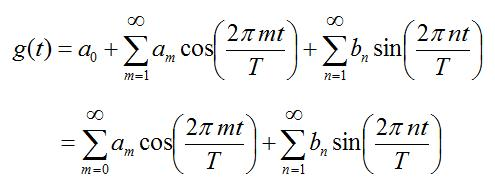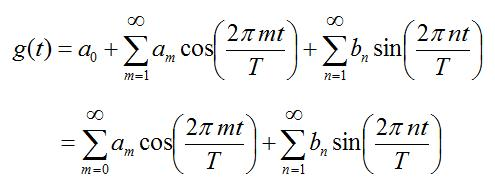

In [30]:
def F_Hertz(U, E, rIndentor, elasticProperties):
    '''Hertzian fit for indentation data'''   
    E_true, v =  elasticProperties
    R_eff = rIndentor
    return (2/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)

In [31]:
def Fourier(x, waveLength, *a):
    '''Function to calculate Fourier Series for array of coefficence a'''
    
    fs = np.copy(x)**0-1 
    N = int(len(a)/2)
    
    for k in range(N):
        fs += a[k]*np.cos((2*np.pi*k*x)/waveLength) + a[k+N]*np.sin((2*np.pi*k*x)/waveLength)  
        
    return fs

In [32]:
def StructureAnalysis(X, Y, Z, scanDims, binSize, waveLength, Nmax):
    '''Height, Volume, Cross-section, Profiles, FWHM, and Fourier
    Calculate Fourier series components, Full Width Half Maxima and Volume for Force Contours of varying indentation force using splines
    
        Parameters:          
            X (arr)        - 2D array of x coordinates over grid positions 
            Y (arr)        - 2D array of y coordinates over grid positions 
            Z (arr)        - 2D array of z coordinates of force contour over grid positions  
            scanDims (arr) - Geometric parameters for defining scan dimensiond [width, height] 
            Nmax (int)     - Maximum number of terms in fourier series of force contour 

        Return:
            XZ           - Z profile across X axis 
            YZ           - Z profile across Y axis 
            DNAheight    - DNA height 
            FWHM (arr)   - Array of full width half maxima of contour [Nx]
            Volume (arr) - Volume under AFM image 
            AreaX (arr)  - Area under topography for across X domain [Nx]
            AreaY (arr)  - Area under topography for across Y domain [Ny]
            A (arr)      - Array of Fourier components for contour [Ny]
    '''

    # Initialise dimensional variables
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    X0 = np.linspace(X[0,0], X[0,-1], 250)

    # -------------------------------------------- Calculate Height and profile ----------------------------------------------------  
    # Produce profile arrays      
    XZ, YZ = np.mean(Z[int(yNum/2)-1:int(yNum/2)+1], axis=0), np.mean(Z[:, int(xNum/2)-1:int(xNum/2)+1], axis=1)

    Fx, Fxz = X[0], XZ
    forceSpline = UnivariateSpline(Fx, Fxz, s = 1) 
    DNAheight = np.mean(np.sort(forceSpline(X0))[-100:])
    
   #  ----------------------------------------- Calculate Volume and cross sections------------------------------------------------  
    Volume = np.trapz(np.trapz(Z, X[0]), Y[:,0])
    
    AreaX, AreaY  = [], []
    AreaX.append( np.trapz(Z, X[0]) )
    AreaY.append( np.trapz(Z.T, Y[:,0]) )

    AreaX = np.array([value for sublist in AreaX for value in sublist])
    AreaY = np.array([value for sublist in AreaY for value in sublist])

   #  ----------------------------------------------Calculate FWHM and Fourier-----------------------------------------------------  
    # Intialise arrays for to store volume, FWHM and Fourier Series component A, for each indentor size and indentation forces
    FWHM, A = np.zeros([xNum]), np.zeros([yNum, 2*Nmax])     
    
    # -------------------------------------Set fwhm values for each force contour-------------------------------------
    for n in range(xNum):
        # Extract y coordinates and z compontents of force contour across x domain
        Fy, Fz = Y[:,0], Z[:,n]
        
        # Connect contour points smoothly with a spline
        forceSpline = UnivariateSpline(Fy, Fz, s = 0.01)         
        
        # Use try loop to avoid error for contours that cannot produce splines  
        try: 
            # Half maxima can be calculated by finding roots of spline 
            roots = UnivariateSpline(Fy, Fz - (Fz.min() + Fz.max())/2, s = 0.01).roots()             
            FWHM[n] = roots[1]-roots[0]
        except:
            None 
            
    # -------------------------------------Set fourier values for each force contour--------------------------------------------
    for n in range(yNum):
        
        # Extract x coordinates and z compontents of force contour across y domain
        Fx, Fz = X[0,:], Z[n,:]
        try:            
            # Connect contour points smoothly with a spline, can fail, use try to avoid code breaking
            forceSpline = UnivariateSpline(Fx, Fz, s = 0.01)  
        except:
            None     
        else:
            # Calculate Fourier components
            A[n], pcov = curve_fit(lambda x, *a: Fourier(x, waveLength, *a), X0, forceSpline(X0), p0 =tuple(np.zeros(2*Nmax)))
        
    return  XZ, YZ, DNAheight, FWHM[FWHM!=0].mean(), Volume, AreaX[AreaX!=0].mean(), AreaY[AreaY!=0].mean(), A

#### Cross-Section Contours and Force

In [33]:
def ForceGrid2D(X, Z, U2, RF):
    ''' 
    Function to produce force heat map over scan domain.
    
        Parameters:
            X (arr)             - 1D array of postions over x domain of scan positions
            Z (arr)             - 1D array of postions over z domain of scan positions, discretised into bins of courseGrain value
            U2 (arr)            - Array of indentors y indentor position over scan, discretised into bins of courseGrain value 
                                  ( As opposed to displacement into surface given from simulation and used elsewhere)
            RF (arr)            - Array of reaction force on indentor reference point
            scanPos (arr)       - Array of coordinates (x,z) of scan positions to image biomolecule [Nb,[x,z]]
            courseGrain (float) - Width of bins that subdivid xz domain of raster scanning/ spacing of the positions sampled over

            kwargs:
                Symmetric - If false skip postprocessing step to ensure AFM image is symmetric about z-axis, instead produce image from raw data {Default: True}
        
        Return:
            forceGrid (arr)        - 2D Array of force heatmap over xz domain of scan i.e. grid of xz positions with associated force [Nx,Nz] 
            forceGridmask (arr)    - 2D boolean array giving mask for force grid with exclude postions with no indentation data [Nx,Nz] 
            forceContour (arr)     - 2D Array of coordinates for contours of constant force given by reference force across scan positons 
            forceContourmask (arr) - 2D boolean array giving mask for force contour for zero values in which no reference force 
    '''
    #  ----------------------------------------------------Force Grid calculation------------------------------------------------------        
    # Intialise force grid array
    forceGrid = np.zeros([len(X),len(Z)])
    
    # For all x and y coordinates in course grained/binned domain
    for i in range(len(X)):
        for j in range(len(Z)):
            
            # For each indentation coordinate
            for k in range(U2.shape[1]):
                
                # If equal to Y position then set corresponding forcee grid array value to force value for that position
                if U2[i,k] == Z[j]:
                    forceGrid[i,j] = RF[i,k]
                        

    #  -----------------------------------------------------Create Force Grid mask---------------------------------------------------      
    # Initialise mask array, 0 values include 1 excludes
    forceGridmask = np.zeros([len(X),len(Z)])  
    
    # For scan positions in force array/ same as positions in X array
    for i in range(len(RF)):
        
        # Check how maNz non-zero values there are for each postion
        k = [ k for k,v in enumerate(forceGrid[i]) if v != 0]
        
        # If there are non zero values
        if len(k)!=0:
            # Mask all grid values upto the first non zero force value position 
            for j in range(k[0]):
                forceGridmask[i,j] = 1
                
        # If all force values are zero 
        else:
            # Mask all y positions in force grid for those forces 
            k = [ k for k,v in enumerate(forceGrid[i]) if Z[k] == U2[i,0] ]
            for j in range(k[0]):
                forceGridmask[i,j] = 1

    return forceGrid, forceGridmask

In [34]:
def ForceContour2D(U2, RF, scanPos, forceRef):
    ''' 
    Function to calculate contours/z heights of constant force in simulation data for given threshold force.
    
        Parameters:
            U2 (arr)            - Array of indentors y indentor position over scan ( As opposed to displacement into surface given from simulation and used elsewhere)
            RF (arr)            - Array of reaction force on indentor reference point
            scanPos (arr)       - Array of coordinates (x,z) of scan positions to image biomolecule [Nb,[x,z]]
            forceRef (float)    - Threshold force to evaluate indentation contours at (pN)

        Return:
            forceContour (arr)     - 2D Array of coordinates for contours of constant force given by reference force across scan positons 
            forceContourmask (arr) - 2D boolean array giving mask for force contour for zero values in which no reference force 
    '''
    #  ----------------------------------------------------Force Contour Calculation-------------------------------------------------         
    # Initialise arrays
    forceContour = np.zeros([len(RF),2])
    forceContourmask = np.zeros([len(RF), 2])
    
    # For scan positions in force array/ same as positions in X array
    for i in range(len(RF)):
        
        # If maximum at this position is greater than Reference force
        if np.max(RF[i]) >= forceRef:
            
            # Return index at which force is greater than force threshold
            j = [ k for k,v in enumerate(RF[i]) if v >= forceRef][0]
            
            # Store corrsponding depth/ Y position and X position for the index
            forceContour[i] = np.array([ scanPos[i,0], U2[i,j] ])  
            
        else:
            # Otherwise position not above force reference, therefore set mask values to 1
            forceContourmask[i] = np.ones(2)
    
    return forceContour, forceContourmask

In [35]:
def ForceInterpolation(Xgrid, Zgrid, U2, RF, scanPos, rIndentor, elasticProperties, Nt):
    '''
    Calculate a 2D force heatmap over the xz domain, produced from interpolated forces using Hertz model.
    
        Parameters:             
            Xgrid (arr)             - 2D array/ grid of postions over xz domain of scan positions
            Zgrid (arr)             - 2D array/ grid of postions over xz domain of scan positions       
            U2 (arr)                - Array of indentors y displacement in time over scan position and  for one indenter [Ni, Nb, Nt]
            RF (arr)                - Array of reaction force in time on indentor reference point over scan position  and for one indenter [Nb, Nt]
            scanPos (arr)           - Array of initial scan positions for one indenter [Nb, [x, z]] 
            rIndentor (float)       - Indentor radius of spherical tip portion varied for seperate  simulations
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            Nt (int)                - Number of time steps

        Return:
            E_hertz (arr)      - Array of fitted elastic modulus for an indentation force value over each scan positions [Nb,Nt]
            E_contour (arr)    - Array of fitted elastic modulus (upto clipped force) across the contour of the sample [Nb]
            F (arr)            - Array of interpolated force values over xz grid for an indentors and reference force [Nb, Nz]  
    '''
    # Initialise array to hold elastic modulus
    Nb = len(scanPos)
    E_hertz   = np.zeros([Nb, Nt])
    E_contour = np.zeros(Nb)


    # Fit Hertz equation to force/indentation for each x scan positon, use lambda function to pass constant parameters(rIndentor/ elasticProperties )
    for i, value in enumerate(scanPos):
        for t in range(1, Nt):
            u2, rf     = abs(U2[i,:t]), abs(RF[i,:t])
            popt, pcov    = curve_fit(lambda x, E: F_Hertz(x, E, rIndentor, elasticProperties), u2, rf)

            # Produce array of fitted elastic modulus over scan positions for each indentor
            E_hertz[i,t]  = popt

    forceRef = np.max(RF,axis=1) 
    forceRef = forceRef[forceRef>0].min()
   
    # Find E across scan positions all to same depth -  loop over X  positions
    for i in range(Nb):

        # If maximum at this position is greater than Reference force
        if np.max(RF[i]) >= forceRef:
            
            # Return index at which force is greater than force threshold
            j = [ k for k,v in enumerate(RF[i]) if v >= forceRef][0]   
            
            # Store corrsponding E value for the index
            E_contour[i] = E_hertz[i,j] 
                        
    
    # Use Elastic modulus over scan position to produce continous spline
    ESpline = UnivariateSpline(scanPos[:,0],  E_hertz[:,-1], s=2)
    
    # From spline interpolate youngs modulus over x domain
    E = ESpline(Xgrid)
    
    # Create spline for initial scan positions
    rackSpline = UnivariateSpline(scanPos[:,0], scanPos[:,1], s = 0.001)
    # Calculate initial scan positions of x domain using scan position spline
    Zinit = rackSpline(Xgrid)

    # Use Hertz Eq to interpolate force over xz grid: (Yinit-Ygrid) gives indentation depths over grid
    F = F_Hertz(Zinit - Zgrid, E, rIndentor, elasticProperties)
    
    return F, E_hertz, E_contour

#### Analysis Function

In [36]:
def DataAnalysis(U2, RF, force_data, scanPos, scanDims, binSize, clearance, waveLength, Nmax, courseGrain, rIndentor, elasticProperties, timeInterval, timePeriod, **kwargs):
    ''' Calculate a 2D force heatmap produced from simulation over the xz domain. Function for data analysis of simulation data. Producing arrays of Volume, FWHM, 
    Fourier series for contours of varying indentation force

        Parameters:
            U2 (arr)                - Array of indentors z displacement over scan position
            RF (arr)                - Array of reaction force on indentor reference point
            force_data              - Array of indentation forces to compare with
            scanPos (arr)           - Array of coordinates [x,y] of scan positions to image biomolecule 
            scanDims (arr)          - Geometric parameters for defining scan dimensiond [width, height] 
            binSize(float)          - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance(float)        - Clearance above molecules surface indentor is set to during scan  
            waveLenght              - Principle waveLength for Fourier series
            Nmax                    - Maximum number of terms in fourier series of force contour 
            courseGrain (float)     - Width of bins that subdivid xz domain of raster scanning/ spacing of the positions sampled over
            rIndentor               - Indentor radius
            waveDims (list)         - Geometric parameters for defining base/ substrate structure [wavelength, amplitude, width, Number of oscilations/ groups in wave] 
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]       
            timeInterval (float)    - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            timePeriod (float)      - Total time length for ABAQUS simulation/ time step (T)

        Return:
            indentationForce (arr) -  Array of indentation reference forces for force contours
                       
            structuralData:
            XZ (arr)        - Z profile across X axis for given indentation forces 
            YZ (arr)        - Z profile across Y axis for given indentation forces 
            DNAheight (arr) - DNA height for varying indentation force
            FWHM (arr)      - Array of full width half maxima of contour for each indentation force [Nf, Nx]
            Volume (arr)    - Volume under AFM image for varying indentation force
            AreaX (arr)     - Area under topography for across X domain for each indentation force [Nf, Nx]
            AreaY (arr)     - Area under topography for across Y domain for each indentation force [Nf, Ny]
            A (arr)         - Array of Fourier components for contour for each indentation force [Nf, Ny]

            XYSectionData:  
            XYSection (arr)    - 1D array of postions over x domain of scan positions
            ZSection (arr)     - 1D array of postions over z domain of scan positions, discretised into bins of courseGrain value
            XYscanPos (arr)    - Array of initial scan positions for indenter [Nxy, [x, z]]
            U2Section (arr)    - Array of indentors y displacement in time over scan position [Nx, Nt]
            RFSection (arr)    - Array of reaction force in time on indentor reference point over scan position [Nx, Nt]            
            forceContour (arr) - 2D Array of coordinates for contours of constant force given by reference force across scan positons for reference force [Nf, Nxy, [x,z]] (With mask applied).
            forceGrid (arr)    - 2D Array of force heatmap over xz domain of scan i.e. grid of xz positions with associated force for reference force [Nf,  Nxy, Nz] (With mask applied). 
            E_hertz (arr)      - Array of fitted elastic modulus for each indentation force value over each scan positions [Nxy,Nt]
            E_contour (arr)    - Array of fitted elastic modulus (upto clipped force) across the contour of the sample  [Nxy]
            F (arr)            - Array of interpolated force values over xz grid for all indentors and reference force [Nxy, Nz] 

    '''

    #  ------------------------------------------Initialise  Variables ------------------------------------------------  
    xNum, yNum , Nt, Nf = int((scanDims[0])/(binSize) + 1), int((scanDims[1])/(binSize) + 1), int(timePeriod/ timeInterval)+1, len(force_data)+1
    
    indentationForce = np.zeros(Nf)  ## Nf = 20  np.logspace(1,3.7,Nf)
    indentationForce[1:] = np.sort(np.copy(force_data))*10
    
    #  ------------------------------------------Initialise  Variables for force grid------------------------------------------------  
    xi, yi = int(xNum/2), int(yNum/2)
    scanPosX, scanPosY = scanPos.reshape(yNum, xNum, 3)[yi,:,[0,2]].T, scanPos.reshape(yNum, xNum, 3)[:,xi,[1,2]] #- np.array([0, clearance])[None,: ]

    XSectionX, ZSectionX = scanPosX[:,0], scanPosX[:,1]
    YSectionY, ZSectionY = scanPosY[:,0], scanPosY[:,1]

    U2SectionX, RFSectionX = U2.reshape(yNum, xNum, Nt)[yi], RF.reshape(yNum, xNum, Nt)[yi]
    U2SectionY, RFSectionY = U2.reshape(yNum, xNum, Nt)[:,xi], RF.reshape(yNum, xNum, Nt)[:,xi]

    # Convert indentation data to indentor Z displacement and discretise values into bins of width given by course grain value - produces an Z arrays over domain of indentor position in X/Y cross-section 
    ZIndentorX, ZIndentorY = (U2SectionX + ZSectionX[:,None]), (U2SectionY + ZSectionY[:,None])
    U2SectionX, U2SectionY = courseGrain*np.round(ZIndentorX/courseGrain) , courseGrain*np.round(ZIndentorY/courseGrain)    
    ZSectionX,  ZSectionY  = (np.round( np.arange( U2SectionX.min(initial=0), U2SectionX.max() + courseGrain, courseGrain )*10)/10, 
                              np.round( np.arange( U2SectionY.min(initial=0), U2SectionY.max() + courseGrain, courseGrain )*10)/10)    


    #  -----------------------------------------------------Set force grid and force contour-----------------------------------------
    # Set force grid and force contour for each indentation force 
    forceGridX, forceGridmaskX = ForceGrid2D(XSectionX, ZSectionX, U2SectionX, RFSectionX)
    forceGridY, forceGridmaskY = ForceGrid2D(YSectionY, ZSectionY, U2SectionY, RFSectionY)

    # Intialise arrays for indentation forces
    forceContourX, forceContourmaskX = np.zeros([Nf, xNum, 2]),  np.zeros([Nf, xNum, 2])
    forceContourY, forceContourmaskY = np.zeros([Nf, yNum, 2]),  np.zeros([Nf, yNum, 2])

    for i  in range(Nf):
        forceContourX[i], forceContourmaskX[i] = ForceContour2D(ZIndentorX, RFSectionX, scanPosX, indentationForce[i])
        forceContourY[i], forceContourmaskY[i] = ForceContour2D(ZIndentorY, RFSectionY, scanPosY, indentationForce[i])

    # Mask force grid excluding postions with no indentation data [Nx,Nz] and mask force contour for zero values in which below reference force 
    forceGridX, forceContourX = np.ma.masked_array(forceGridX, mask=forceGridmaskX), np.ma.masked_array(forceContourX, mask=forceContourmaskX) 
    forceGridY, forceContourY = np.ma.masked_array(forceGridY, mask=forceGridmaskY), np.ma.masked_array(forceContourY, mask=forceContourmaskY)     


    #  --------------------------------------Calculate Hertz fit and interpolate force from the fit---------------------------------
    # Initialise grid arrays over xz domain
    X0, XZ0 = np.linspace(XSectionX[0], XSectionX[-1], 250), np.linspace(ZSectionX[0], ZSectionX[-1], 250)
    Y0, YZ0 = np.linspace(YSectionY[0], YSectionY[-1], 250), np.linspace(ZSectionY[0], ZSectionY[-1], 250)

    Xgrid, XZgrid = np.meshgrid(X0,XZ0)     
    Ygrid, YZgrid = np.meshgrid(Y0,YZ0)   

    # For each indentor calculate interpolated force heat maps
    FX, E_hertzX, E_contourX = ForceInterpolation(Xgrid, XZgrid, U2SectionX, RFSectionX, scanPosX, rIndentor, elasticProperties, Nt)
    FY, E_hertzY, E_contourY = ForceInterpolation(Ygrid, YZgrid, U2SectionY, RFSectionY, scanPosY, rIndentor, elasticProperties, Nt)

    if 'NStructural' not in kwargs.keys() or kwargs['NStructural'] == False:
        #  ----------------------------------------------Calculate Volume and Fourier-----------------------------------------------------  
        # Intialise arrays for to store volume, FWHM and Fourier Series component A, for each indentor size and reference forces
        XZ, YZ, DNAheight, FWHM, Volume, AreaX, AreaY,  A = np.zeros([Nf,xNum]), np.zeros([Nf,yNum]), np.zeros([Nf]), np.zeros([Nf]), np.zeros([Nf]), np.zeros([Nf]), np.zeros([Nf]), np.zeros([Nf, yNum, 2*Nmax])

        # Hard sphere analysis
        X_hs, Y_hs, Z_hs = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1], scanPos.reshape(yNum, xNum, 3)[:,:,2] - clearance
        XZ[0], YZ[0], DNAheight[0], FWHM[0], Volume[0], AreaX[0], AreaY[0], A[0] = StructureAnalysis(X_hs, Y_hs, Z_hs, scanDims, binSize, waveLength, Nmax)
        
        # Simulation data analysis
        for i, forceRef in enumerate(indentationForce[1:]):
            X,Y,Z = ForceContours(U2, RF, forceRef, scanPos, scanDims, binSize, clearance)

            XZ[i+1], YZ[i+1], DNAheight[i+1], FWHM[i+1], Volume[i+1], AreaX[i+1], AreaY[i+1], A[i+1] = StructureAnalysis(X, Y, Z, scanDims, binSize, waveLength, Nmax)

        # Group data to return
        structuralData = (XZ, YZ, DNAheight, FWHM, Volume, AreaX, AreaY, A) 

        XSectionData   = (XSectionX, ZSectionX, scanPosX, forceContourX, forceGridX, E_hertzX, E_contourX, RFSectionX)
        YSectionData   = (YSectionY, ZSectionY, scanPosY, forceContourY, forceGridY, E_hertzY, E_contourY, RFSectionY)

        return indentationForce, structuralData, XSectionData, YSectionData

    else: 
        XSectionData   = (XSectionX, ZSectionX, scanPosX, forceContourX, forceGridX, E_hertzX, E_contourX, RFSectionX)
        YSectionData   = (YSectionY, ZSectionY, scanPosY, forceContourY, forceGridY, E_hertzY, E_contourY, RFSectionY)

        return indentationForce, XSectionData, YSectionData

### Plotting Functions

In [37]:
def SurfacePlot(scanPos, scanDims, binSize, surfacePos, surfaceDims, surfaceSize, tipDims, **kwargs):
    ''' 
    Plot the molecules atoms surfaces and scan positions to visualise and check positions.
    
        Parameters:
            scanPos (arr)     - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            scanDims (arr)    - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)   - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            surfacePos (arr)  - Array of coordinates [x,y,z] of the sample surface to define surface mesh
            surfaceDims (arr) - Geometric parameters for defining surface dimensiond [width, height] 
            surfaceSize (str) - Width of bins that subdivid xy domain of sample surface 
            tipDims (list)    -  Geometric parameters for defining capped tip structure  

        kwargs:
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''     
    #  ----------------------------------------------Surface and Scan positions ------------------------------------------------------
    # Initialise scan geometry
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    X, Y, Z = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1], scanPos.reshape(yNum, xNum, 3)[:,:,2]     

    # Initialise surface structure
    xNum1, yNum1 = int(surfaceDims[0]/surfaceSize)+1, int(surfaceDims[1]/surfaceSize)+1
    X_surface, Y_surface, Z_surface = surfacePos.reshape(yNum1, xNum1, 3)[:,:,0], surfacePos.reshape(yNum1, xNum1, 3)[:,:,1], surfacePos.reshape(yNum1, xNum1, 3)[:,:,2] 

    # Initialise tip structure
    N, i, j = 25, int(xNum*yNum/2), 300
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims

    # Create the mesh in polar coordinates and compute corresponding Z.
    r, p = np.linspace(0, r_top, N), np.linspace(0, 2*np.pi, N)
    R, P = np.meshgrid(r, p)
    rZ  = Zconical(R, 0, r_int, z_int, theta, rIndentor, tip_length) + scanPos[i,2]
    rX, rY = R*np.cos(P), R*np.sin(P)

    #  -------------------------------------------------3D Plots-----------------------------------------------------      
    # Plot 3D Contour Plot
    fig, ax = plt.figure(), plt.axes(projection = "3d") 
   
    
    # ax.plot_surface(rX, rY, rZ2, facecolor='red', edgecolor='red', lw=0.5, rstride=1, cstride=1, alpha=0.8)
    # ax.plot_surface(rX, rY, -rZ2+2*(rIndentor+scanPos[i,2]), facecolor='red', edgecolor='red', lw=0.5, rstride=1, cstride=1, alpha=0.8)

    ax.plot_surface(rX + scanPos[j,0], rY + scanPos[j,1], rZ, facecolor='royalblue', edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.8, zorder = 0.3)
    ax.plot_surface(X_surface, Y_surface, Z_surface, facecolor='black', edgecolor='black', lw=0.5, rstride=1, cstride=1, alpha=0.4, zorder = 0.1)
    ax.scatter3D(scanPos[:i,0], scanPos[:i,1], scanPos[:i,2], color='r', alpha = 1, s=5, zorder = 0.2)
    
    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_zlim(Z.min(),Z.max())
    
    ax.axes.set_aspect('equal')
    ax.view_init(30,210)

    color_tuple = (1.0, 1.0, 1.0, 0.0)


    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # make the panes transparent
    ax.xaxis.set_pane_color(color_tuple)
    ax.yaxis.set_pane_color(color_tuple)
    ax.zaxis.set_pane_color(color_tuple)

    # make the axis lines transparent
    ax.xaxis.line.set_color(color_tuple)
    ax.yaxis.line.set_color(color_tuple)
    ax.zaxis.line.set_color(color_tuple)

    # make the labels transparent
    ax.xaxis.set_label_position('none') 
    ax.yaxis.set_label_position('none') 
    ax.zaxis.set_label_position('none')

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (color_tuple)
    ax.yaxis._axinfo["grid"]['color'] =  (color_tuple)
    ax.zaxis._axinfo["grid"]['color'] =  (color_tuple)

    # print(list(ax.spines.keys()))
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')

    ax.tick_params(colors='white')
    # fig.patch.set_edgecolor('black')

    # rect = plt.Rectangle(
    #     # (lower-left corner), width, height
    #     (0.35, 0.25), 0.425, 0.75, fill=False, color="k", lw=1, 
    #     zorder=1000, transform=fig.transFigure, figure=fig
    # )
    # fig.patches.extend([rect])
    
    plt.show()
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFMSurfaceDiagram.pdf', bbox_inches = 'tight') 

In [38]:
def ManuscriptAFMContourPlot(U2, RF, scanPos, scanDims, binSize, clearance, ErrorMask, forceRef, contrast, pdb, **kwargs):
    ''' 
    Function to plot force contor produced from simulation. Plots 3D wire frame image and a 2D AFM image.
    
        Parameters:
            U2 (arr)          - Array of indentors z displacement over scan position
            RF (arr)          - Array of reaction force on indentor reference point
            scanPos (arr)     - Array of coordinates [x,y,z] of scan positions to image biomolecule 
            scanDims (arr)    - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)   - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance (float) - Clearance above molecules surface indentor is set to during scan
            ErrorMask (arr)   - Boolean array specifying mask for all scan positions which errored in ABAQUS
            scanDims (arr)    - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)   - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            forceRef (float)  - Threshold force to evaluate indentation contours at (pN)
            contrast (float)  - Contrast between high and low values in AFM heat map (0-1)
            pdb (str)         - PDB (or CSV) file name of desired biomolecule
            
        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''    
    # ------------------------------------Add noise and padding to image if in kwargs--------------------------------   
    # Current data shape
    xNum,  yNum  = int(scanDims[0]/binSize)+1,  int(scanDims[1]/binSize)+1
    Zmask = ErrorMask.reshape(yNum, xNum)
    X,Y,Z = ForceContours(U2, RF,forceRef, scanPos, scanDims, binSize, clearance)

    if 'ImagePadding' in kwargs.keys():
        imagePadding = kwargs['ImagePadding']
        
        padDims      = imagePadding*scanDims
        xPad,  yPad  = int(padDims[0]/binSize)+1, int(padDims[1]/binSize)+1 
        xDiff, yDiff = abs((xPad-xNum)/2), abs((yPad-yNum)/2)
        
        X, Y = np.meshgrid(np.linspace(-padDims[0]/2, padDims[0]/2, xPad),
                           np.linspace(-padDims[1]/2, padDims[1]/2, yPad))   
        
        if imagePadding >= 1:            
            Z = np.pad(Z, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
            Zmask = np.pad(Zmask, pad_width= ( (round(yDiff-0.25), round(yDiff+0.25)), (round(xDiff-0.25), round(xDiff+0.25)) ), mode='constant')
        
        else:
            Z = np.delete(Z, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            Zmask = np.delete(Zmask, np.arange(-round(yDiff-0.25), round(yDiff+0.25)), axis = 0)
            
            Z = np.delete(Z, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            Zmask = np.delete(Zmask, np.arange(-round(xDiff-0.25), round(xDiff+0.25)), axis = 1)
            
        imageDims = padDims
        
    else:
        imageDims = scanDims
        
    if 'Noise' in kwargs.keys():
        noise_strength, noise_mean, noise_variance = kwargs['Noise'] 
        noise = noise_strength*np.random.normal(noise_mean, noise_variance, [Z.shape[0], Z.shape[1]])
        Z+=noise      
    else:
        None      
        
    # Reshape image mask and apply to data
    X = np.ma.masked_array(X, mask = Zmask )
    Y = np.ma.masked_array(Y, mask = Zmask )
    Z = np.ma.masked_array(Z, mask = Zmask )
    
    # Set normalisation of colour map
    if 'PowerNorm' in kwargs and kwargs['PowerNorm'] != False:
        normalizer = mpl.colors.PowerNorm(kwargs['PowerNorm'], 0, contrast*Z.compressed().max(initial = 1e-10))
    else:
        normalizer = mpl.colors.Normalize(vmin=0,  vmax= contrast*Z.compressed().max(initial = 1e-10))
     
    #  -------------------------------------------------2D Plots-----------------------------------------------------      
    # 2D heat map/ contour plot with interpolation
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2)) 
    im = ax.imshow(Z, origin= 'lower', cmap='afmhot', interpolation='bicubic', norm= normalizer, interpolation_stage = 'rgba', 
                           extent=(-imageDims[0]/2,imageDims[0]/2,-imageDims[1]/2,imageDims[1]/2) )
    ax.axhline(0, ls = ':', color='r')
    ax.axvline(0, ls = ':', color='r')
    ax.set_xlabel(r'x (${\AA}$)')
    ax.set_ylabel(r'y (${\AA}$)')
    ax.axes.set_aspect('equal')
    ax.set_facecolor('grey')
    
    plt.subplots_adjust(wspace = 0.5)
    cbar= fig.colorbar(im, ax= ax, orientation='vertical')
    cbar.set_label(r'z (${\AA}$)', rotation=0)
    cbar.set_ticks([0, 10, 20])
    cbar.ax.set_ylim(0, 20)
    cbar.minorticks_on() 
    cbar.ax.yaxis.set_label_coords(8.2, 0.55)

    fig.patch.set_edgecolor('black')

    rect = plt.Rectangle(
        # (lower-left corner), width, height
        (-0.07, -0.2), 1.12, 1.15, fill=False, color="k", lw=1, 
        zorder=1000, transform=fig.transFigure, figure=fig
    )
    fig.patches.extend([rect])

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFMSimulationMolecule-'+pdb+'.pdf', bbox_inches = 'tight', edgecolor=fig.get_edgecolor())
    
    plt.show()

In [39]:
def ManuscriptDiagram(scanPos, scanDims, binSize, surfacePos, surfaceDims, surfaceSize, tipDims, **kwargs):
    ''' 
    Plot the surfaces and scan positions to visualise and check positions. 
    
        Parameters:
            scanPos (arr)     - Array of coordinates [x,y,z] of scan positions to image biomolecule and initial heights/ hard sphere boundary
            scanDims (arr)    - Geometric parameters for defining scan dimensiond [width, height] 
            binSize (float)   - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            surfacePos (arr)  - Array of coordinates [x,y,z] of the sample surface to define surface mesh
            surfaceDims (arr) - Geometric parameters for defining surface dimensiond [width, height] 
            surfaceSize (str) - Width of bins that subdivid xy domain of sample surface 
            tipDims (list)    -  Geometric parameters for defining capped tip structure 
       
        kwargs:
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''     
    #  ----------------------------------------------------Initial variables---------------------------------------------------------
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    xNum1, yNum1 = int(surfaceDims[0]/surfaceSize)+1, int(surfaceDims[1]/surfaceSize)+1
    xi, xj = int(xNum/2),int(xNum1/2+2)
    yi, yj = int(yNum/2),int(yNum1/2)

    # Set tip and wave dimensional variables and set index for scan position to plot tip at
    rIndentor, theta, tip_length, r_int, z_int, r_top, z_top = tipDims

    #  ----------------------------------------------Surface and Scan positions ------------------------------------------------------
    # Scan positions
    X_hs, Y_hs, Z_hs = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1], scanPos.reshape(yNum, xNum, 3)[:,:,2] 
    Fx, Fxz     = X_hs[0,:], Z_hs[yi,:]
    Fy, Fyz     = Y_hs[:,0], Z_hs[:,xi]

    # Surface positions
    X_surface, Y_surface, Z_surface = surfacePos.reshape(yNum1, xNum1, 3)[:,:,0], surfacePos.reshape(yNum1, xNum1, 3)[:,:,1], surfacePos.reshape(yNum1, xNum1, 3)[:,:,2] 
    Fx_surface, Fxz_surface         = X_surface[0,:], Z_surface[yj,:]
    Fy_surface, Fyz_surface         = Y_surface[:,0], Z_surface[:,xj]

    # Produce array for the conical x extent and spherical tip with polar coordinates
    X  = np.linspace(-r_top, r_top, 1000)
    x1 = rIndentor*np.cos(np.linspace(-np.pi, np.pi, 1000))
    z1 = rIndentor*np.sin(np.linspace(-np.pi, np.pi, 1000))

   
    #  ------------------------------------------------------------------------------------------------------------------------
    #  ------------------------------------------------------------------------------------------------------------------------
    #  -------------------------------------------------------Plot 1-----------------------------------------------------------
    # Create figure for scan positions
    fig, ax = plt.subplots(1,1, figsize= (linewidth, 1/1.61*linewidth))
    
    # Plot spherical and conical scan position as points
    ax.plot(Fx, Fxz, '.', color='r')
    ax.plot(Fx_surface, Fxz_surface, '-', color='k')

    # # Plot the geometry of spherical and conical tip at index i
    ax.plot(X+Fx[xi], Zconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)+Fxz[xi], color=  '#5a71ad')
    ax.plot(x1+Fx[xi], z1+rIndentor+Fxz[xi], ':', color = '#fc8535')

    ax.plot(X+Fx[xi+5], Zconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)+Fxz[xi+5], color=  '#5a71ad')
    ax.plot(x1+Fx[xi+5], z1+rIndentor+Fxz[xi+5], ':', color = '#fc8535')

    #  --------------------------------------------------Set axis blank ----------------------------------------------------------
    # Set axis labels to create desired layout
    # ax.set_xlabel(r'$x/\lambda$', labelpad = 5, color='white')
    ax.set_xlim(Fx[0],Fx[-1])
    ax.set_ylim(0,Z_hs.max()+tip_length)
    ax.axes.set_aspect('equal')
        
    # Place axis on right for desired spacing
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    # Make axis invisible    
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white')

    #  --------------------------------------------------Plot Annotations---------------------------------------------------------
    # # Annotating Diagram
    # ax.text(-waveLength/2-rIndentor/2-0.3, waveAmplitude + rIndentor + 0.8, 'R', color = '#fc8535')
    # ax.text(-waveLength/2, 0.3, r'$\lambda$')   
    
    # plt.rcParams['font.size'] = 8

    # ax.annotate('', color = '#fc8535',
    #             xy=(-waveLength/2+1, waveAmplitude+rIndentor), xycoords='data',
    #             xytext=(-waveLength/2-rIndentor, waveAmplitude+rIndentor), textcoords='data',
    #             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='#fc8535'))
    
    # ax.annotate('', xy=(-waveLength, -0.4), xycoords='data', 
    #             xytext=(0, -0.4), textcoords='data',
    #             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='k'))
    

    # plt.rcParams['font.size'] = 13

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_ManuscriptDiagram-X.pdf', bbox_inches = 'tight') 
    plt.show()
    
    #  ------------------------------------------------------------------------------------------------------------------------
    #  ------------------------------------------------------------------------------------------------------------------------
    #  -----------------------------------------------------Plot2--------------------------------------------------------------
    fig, ax = plt.subplots(1,1, figsize = (linewidth, 1/1.61*linewidth))
    
    # Plot spherical and conical scan position as points
    ax.plot(Fy, Fyz, '.', color='r')
    ax.plot(Fy_surface, Fyz_surface, '-', color='k')

    # # Plot the geometry of spherical and conical tip at index i
    ax.plot(X+Fy[yi], Zconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)+Fyz[yi], color=  '#5a71ad')
    ax.plot(x1+Fy[yi], z1+rIndentor+Fyz[yi], ':', color = '#fc8535')

    ax.plot(X+Fy[yi-5], Zconical(X, 0, r_int, z_int, theta, rIndentor, tip_length)+Fyz[yi-5], color=  '#5a71ad')
    ax.plot(x1+Fy[yi-5], z1+rIndentor+Fyz[yi-5], ':', color = '#fc8535')


    #  --------------------------------------------------Set axis blank ----------------------------------------------------------
    # Set axis labels to create desired layout
    # ax.set_xlabel(r'$x/\lambda$', labelpad = 5, color='white')
    ax.set_xlim(Fx[0],Fx[-1])
    ax.set_ylim(0,Z_hs.max()+tip_length)
    ax.axes.set_aspect('equal')
        
    # Place axis on right for desired spacing
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    # Make axis invisible    
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white')

    #  --------------------------------------------------Plot Annotations---------------------------------------------------------
    # # Annotating Diagram
    # ax.text(-waveLength/2-rIndentor/2-0.3, waveAmplitude + rIndentor + 0.8, 'R', color = '#fc8535')
    # ax.text(-waveLength/2, 0.3, r'$\lambda$')   
    
    # plt.rcParams['font.size'] = 8

    # ax.annotate('', color = '#fc8535',
    #             xy=(-waveLength/2+1, waveAmplitude+rIndentor), xycoords='data',
    #             xytext=(-waveLength/2-rIndentor, waveAmplitude+rIndentor), textcoords='data',
    #             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='#fc8535'))
    
    # ax.annotate('', xy=(-waveLength, -0.4), xycoords='data', 
    #             xytext=(0, -0.4), textcoords='data',
    #             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color='k'))
    

    # plt.rcParams['font.size'] = 1
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_ManuscriptDiagram-Y.pdf', bbox_inches = 'tight') 
    plt.show()

In [40]:
def AFMForceContours(RF, XSectionData, YSectionData, surfacePos, surfaceDims, surfaceSize, tipDims, clearance, elasticProperties, contrast, m, **kwargs):
    '''Function to plot a 2D force heatmap produced from simulation over the xz domain for single indenter and refereance force.
    
        Parameters:
            RF (arr)                - Array of reaction force in time on indentor reference point over scan position          
            XSectionData            - Scan and force data for scan cross section across X axis
            YSectionData (arr)      - Scan and force data for scan cross section across Y axis
            surfacePos (arr)        - Array of coordinates [x,y,z] of the sample surface to define surface mesh
            surfaceDims (arr)       - Geometric parameters for defining surface dimensiond [width, height] 
            surfaceSize (str)       - Width of bins that subdivid xy domain of sample surface 
            tipDims (list)          - Geometric parameters for defining capped tip structure    
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            contrast (float)        - Contrast between high and low values in AFM heat map (0-1)

        kwargs:
            Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
            ImagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
            SaveImages (str)     - If Contour images to be saved include kwarg specifying the file path to folder
    '''
    
    # -----------------------------------------------------------Set Variable--------------------------------------------------------- 
    # Contour data   
    XSectionX, ZSectionX, scanPosX, forceContourX, forceGridX = XSectionData[:-3]
    YSectionY, ZSectionY, scanPosY, forceContourY, forceGridY = YSectionData[:-3] 
    
    # Initialise surface structure
    xNumS, yNumS = int(surfaceDims[0]/surfaceSize)+1, int(surfaceDims[1]/surfaceSize)+1
    xi, yi = int(xNumS/2), int(yNumS/2-2)
    surfacePosX, surfacePosY = surfacePos.reshape(yNumS, xNumS, 3)[yi,:,[0,2]].T, surfacePos.reshape(yNumS, xNumS, 3)[:,xi,[1,2]]
    
    # Tip variables
    rIndentor, theta, tip_length, r_int, z_int,r_top = tipDims[:-1]
    # Produce spherical tip with polar coordinates
    r, phi = np.linspace(-r_top, r_top, 100), np.linspace(-np.pi/2,np.pi/2, 100)   
    
    # Set material properties
    E_true, v = elasticProperties 
    E_eff     = E_true/(1-v**2) 
    # Set constant to normalise dimensionaless forces
    F_dim, maxRF = (E_eff*rIndentor**2), RF.max()/(E_eff*rIndentor**2)    
    normalizer   = mpl.colors.PowerNorm(0.35, 0, contrast*(maxRF).max() )
    # Set plot colormap
    colormap = mpl.colormaps.get_cmap('coolwarm')
    colormap.set_bad('grey') 

    # Extract xz compontents of force contour - compressed removes masked values
    Fx, Fxz = np.array(forceContourX[m,:,0].compressed()), np.array(forceContourX[m,:,1].compressed())
    Fy, Fyz = np.array(forceContourY[m,:,0].compressed()), np.array(forceContourY[m,:,1].compressed())      

    # Connect contour points smoothly with a spline
    forceSplineX, forceSplineY = UnivariateSpline(Fx, Fxz, s = 2), UnivariateSpline(Fy, Fyz, s = 2)
    X, Y = np.linspace(scanPosX[0], scanPosX[-1],100), np.linspace(scanPosY[0], scanPosY[-1],100)


    # -----------------------------------------------Add padding to image -------------------------------------------------------     
    # Increase padding to add above surface
    imagePadding = 2
    
    ZPadSectionX, binSize = imagePadding*ZSectionX.max(), (ZSectionX.max()-ZSectionX.min())/len(ZSectionX)
    ZPadSectionY, binSize = imagePadding*ZSectionY.max(), (ZSectionY.max()-ZSectionY.min())/len(ZSectionY)

    dZX, dZY = abs((int(ZPadSectionY/binSize)+1-len(ZSectionY))), abs((int(ZPadSectionX/binSize)+1-len(ZSectionX)))
    ZXmask, ZYmask = np.ma.getmask(forceGridX), np.ma.getmask(forceGridY)

    ZXmask = np.pad(ZXmask.T, pad_width= ((round(0), round(dZX)), (0,0) ), mode='constant')   
    ZYmask = np.pad(ZYmask.T, pad_width= ((round(0), round(dZY)), (0,0) ), mode='constant')  

    ZX = np.pad(forceGridX.T, pad_width= ( (round(0), round(dZX)), (0,0) ), mode='constant')        
    ZY = np.pad(forceGridY.T, pad_width= ( (round(0), round(dZY)), (0,0) ), mode='constant')    

    ZX, ZY = np.ma.masked_array(ZX, mask = ZXmask ), np.ma.masked_array(ZY, mask = ZYmask )
    
    # plt.rcParams['font.size'] = 14

    # Plot of force heatmaps using imshow to directly visualise 2D array
    # ----------------------------------------------------2D Plots X axis--------------------------------------------------------         
    fig, ax = plt.subplots(1,1, figsize = (linewidth/2, (1/1.61)*linewidth/2)) 
       
    # 2D heat map plot without interpolation
    im = ax.imshow(ZX/F_dim, origin= 'lower', cmap=colormap, interpolation='bicubic', norm= normalizer, extent = (XSectionX[0], XSectionX[-1], ZSectionX.min(), ZPadSectionX), interpolation_stage = 'rgba')
       
    # Plot spline force for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(X,                forceSplineX(X),         '-', color = 'r', lw = 1, label = 'Fitted Fource Contour')
    ax.plot(scanPosX[:,0],    scanPosX[:,1]-clearance, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(surfacePosX[:,0], surfacePosX[:,1],        ':', color = 'w', lw = 1, label = 'Surface boundary') 

    # Plot indentor geometry
    ax.plot(r + scanPosX[int(len(scanPosX)/2),0], Zconical(r, 0, r_int, z_int, theta, rIndentor, tip_length) + scanPosX[int(len(scanPosX)/2),1] - clearance,  color = 'w', lw = 1, label = 'Indentor boundary') 

    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'x (${\AA}$)')
    ax.set_ylabel(r'z (${\AA}$)', rotation=90,  labelpad = 5)
    ax.set_xlim(XSectionX[0], XSectionX[-1])
    ax.set_ylim(0, ZPadSectionX )
    ax.set_yticks( np.round(10*np.linspace(0, ZPadSectionX, 3))/10 )
    ax.axes.set_aspect(1.2) 
    # ------------------------------------------------Plot color bar ------------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.01675, pad=0.025)
    cbar.set_ticks(np.array([0, 0.01, 0.03]))
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.ax.yaxis.set_label_coords(7.5, 0.5)
    cbar.ax.set_ylim(0, 0.03)
    cbar.minorticks_on() 

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_CrossSectionHeatMap-X.pdf', bbox_inches = 'tight') 
    plt.show()

    # ----------------------------------------------------2D Plots Y axis--------------------------------------------------------    
    fig, ax = plt.subplots(1,1, figsize = (linewidth/2, (1/1.61)*linewidth/2)) 

    # 2D heat map plot without interpolation
    im = ax.imshow(ZY/F_dim, origin= 'lower', cmap=colormap, interpolation='bicubic', norm= normalizer, extent = (YSectionY[0], YSectionY[-1], ZSectionY.min(), ZPadSectionY), interpolation_stage = 'rgba')
        
    # Plot spline force for contour points, contour points themselves, surface boundary using polar coordinates, and hard sphere tip convolution
    ax.plot(Y,                forceSplineY(Y),         '-', color = 'r', lw = 1, label = 'Fitted Fource Contour')
    ax.plot(scanPosY[:,0],    scanPosY[:,1]-clearance, ':', color = 'r', lw = 1, label = 'Hard Sphere boundary')
    ax.plot(surfacePosY[:,0], surfacePosY[:,1],        ':', color = 'w', lw = 1, label = 'Surface boundary') 

    # Plot indentor geometry
    ax.plot(r + scanPosY[int(len(scanPosY)/2),0], Zconical(r, 0, r_int, z_int, theta, rIndentor, tip_length) + scanPosY[int(len(scanPosY)/2),1] - clearance,  color = 'w', lw = 1, label = 'Indentor boundary') 
    
    # Set legend and axis labels, limits and title
    ax.set_xlabel(r'y (${\AA}$)')
    ax.set_ylabel(r'z (${\AA}$)', rotation=90,  labelpad = 5)
    ax.set_xlim(YSectionY[0], YSectionY[-1])
    ax.set_ylim(0, ZPadSectionY )
    ax.set_yticks( np.round(10*np.linspace(0, ZPadSectionY, 3))/10 )
    ax.axes.set_aspect('equal') 
    # ax.tick_params(labelleft=False)
    
    # ------------------------------------------------Plot color bar ------------------------------------------------------------
    cbar= fig.colorbar(im, ax= ax , orientation = 'vertical', fraction=0.01675, pad=0.025)
    cbar.set_ticks(np.array([0, 0.01, 0.03]))
    cbar.set_label(r'$\frac{F}{E*R^2}$', rotation=0)
    cbar.ax.yaxis.set_label_coords(7.5, 0.5)
    cbar.ax.set_ylim(0, 0.03)
    cbar.minorticks_on() 
    
    
    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_CrossSectionHeatMap-Y.pdf', bbox_inches = 'tight') 
    # plt.rcParams['font.size'] = 13    
    plt.show()

In [79]:
def ForceProfiles(scanPos, scanDims, binSize, XZ, YZ, indentationForce, force_data, cross_section_height_data, data_length, **kwargs):
    ''' '''
    #  -------------------------------------------Initialise variable-----------------------------------------------
    xNum, yNum = int(scanDims[0]/binSize)+1, int(scanDims[1]/binSize)+1
    X, Y = scanPos.reshape(yNum, xNum, 3)[:,:,0], scanPos.reshape(yNum, xNum, 3)[:,:,1]
    X0, Y0 = np.linspace(X[0,0], X[0,-1], 250), np.linspace(Y[0,0], Y[-1,0], 250)

    plt.rcParams['font.size'] = 11
    #  --------------------------------------------X Profile Plot---------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2))
    for i, forceRef in enumerate(indentationForce[::3]):
        Fx, Fxz = X[0], XZ[i]
        forceSpline = UnivariateSpline(Fx, Fxz, s = 2) 
        
        # plot= ax.plot(Fx,Fxz, 'x')
        ax.plot(X0, forceSpline(X0), '-',  label='{0:.2f}'.format(forceRef/10), lw=0.75) #color = plot[0].get_color(),

    ax.set_xlabel(r'x (${\AA}$)')
    ax.set_ylabel(r'z (${\AA}$)')
    ax.set_xlim(-75, 75)
    ax.set_ylim(15, 21)
    ax.set_xticks([-50,0,50])
    ax.set_yticks([15,20])
    ax.axes.set_aspect(9.5) 
    # ax.legend(title = 'Force (pN):', frameon=False, ncol=1, labelspacing=0, loc=[0.95,0.175])


    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_XProfile.pdf', bbox_inches = 'tight') 
    plt.show()
    
    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2))
    for i, forceRef in enumerate(indentationForce[1:][::3]):
        Fy, Fyz      = Y[:,0], YZ[i]
        forceSpline  = UnivariateSpline(Fy, Fyz, s = 0.01)
        
        plot = ax.plot(Y0, forceSpline(Y0), '-', label= '{0:0.2f}'.format(forceRef/10), lw=0.65)
        # ax.plot(Fy, Fyz, '-', color = plot[0].get_color(), label= '{0:0.2f}'.format(forceRef/10), lw=0.65)

    # for i, forceRef in enumerate(force_data):
        Y_exp, Z_exp = cross_section_height_data[i+1,:data_length[i+1],0]-np.max(cross_section_height_data[i+1,:data_length[i+1],0])/2-5, cross_section_height_data[i+1,:data_length[i+1],1]
        ax.plot(Y_exp[::5], Z_exp[::5], '^', color = plot[0].get_color(), ms=3.5)

    ax.set_xlabel(r'y (${\AA}$)')
    ax.set_ylabel(r'z (${\AA}$)')
    ax.set_xlim(-75, 75)
    ax.set_ylim(0, 25)
    ax.set_xticks([-50,0,50])
    ax.set_yticks([0,10,20])
    ax.axes.set_aspect(2.35) 
    ax.legend(title = 'Force (pN):', title_fontsize = 8, fontsize=8, frameon=False, ncol=1, labelspacing=0, loc=[0.02,0.32])

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_YProfile.pdf', bbox_inches = 'tight') 
    plt.show()
    plt.rcParams['font.size'] = 13    

In [78]:
def StructureAnalysisPlot(structuralData, indentationForce, force_data, force_height_data,  FWHM_exp, AreaX_exp, **kwargs):
    ''' '''
    XZ, YZ, DNAheight, FWHM, Volume, AreaX, AreaY, A = structuralData
    
    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    fig, ax = plt.subplots(figsize = (linewidth/2, 1/1.61*linewidth/2))
    # ax1, ax2 = ax.twinx(), ax.twinx() 
    # ax3, ax4 = ax.twinx(), ax.twinx()

    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    plot0 = ax.plot(indentationForce/10, DNAheight, label = 'DNA Height', color = ax._get_lines.get_next_color())
    ax.plot(force_height_data[:,0], force_height_data[:,1], '^', label = 'Experimental DNA Height', color = plot0[0].get_color(), ms=3.5)

    # plot1 = ax1.plot(indentationForce/10, FWHM, label = 'FWHM', color = ax._get_lines.get_next_color(), alpha=0.25 )
    # ax1.plot(force_data, FWHM_exp, ':', label = 'FWHM Exp', color =  plot1[0].get_color(), alpha=0.25 )

    # plot2 = ax2.plot(indentationForce/10, Volume, label = 'Volume', color = ax._get_lines.get_next_color(), alpha=0.25)

    # plot3 = ax3.plot(indentationForce/10, AreaX, label = 'Cross Sections Area X',  color = ax._get_lines.get_next_color(), alpha=0.25)
    # ax3.plot(force_data, AreaX_exp, ':', label = 'Cross Sections Area X Exp',  color = plot3[0].get_color(), alpha=0.25)

    # plot4 = ax4.plot(indentationForce/10, AreaY, label = 'Cross Sections Area Y',  color = ax._get_lines.get_next_color(), alpha=0.25)



    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    # ax1.spines['right'].set_position(('outward', 0))
    # ax2.spines['right'].set_position(('outward', 70))
    # ax3.spines['right'].set_position(('outward', 140))
    # ax4.spines['right'].set_position(('outward', 210))

    ax.axes.set_aspect(10) 

    ax.set_xlabel("Indentation force (pN)")
    ax.set_ylabel(r"DNA height(${\AA}$)")
    ax.yaxis.set_label_coords(-0.14, 0.4)
    # ax1.set_ylabel(r"FWHM (${\AA}$)")
    # ax2.set_ylabel(r"Volume (${\AA}^3$)")
    # ax3.set_ylabel(r"Cross Sections Area X (${\AA}^2$)")
    # ax4.set_ylabel(r"Cross Sections Area Y (${\AA}^2$)")
    
    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    # ax.yaxis.label.set_color(plot0[0].get_color())
    # ax1.yaxis.label.set_color(plot1[0].get_color())
    # ax2.yaxis.label.set_color(plot2[0].get_color())
    # ax3.yaxis.label.set_color(plot3[0].get_color())
    # ax4.yaxis.label.set_color(plot4[0].get_color())

    handles0, labels0 = ax.get_legend_handles_labels()
    # handles1, labels1 = ax1.get_legend_handles_labels()
    # handles2, labels2 = ax2.get_legend_handles_labels()
    # handles3, labels3 = ax3.get_legend_handles_labels()
    # handles4, labels4 = ax4.get_legend_handles_labels()

    #  --------------------------------------------Y Profile Plot---------------------------------------------------
    # ax.legend(handles0+handles1+handles2+handles3+handles4, labels0+labels1+labels2+labels3+labels4, loc='best', ncol=2)  
    # ax.legend(handles0, labels0, title = False, frameon=False, labelspacing=0,  loc='best', ncol=1, fontsize=13 )  


    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_StructureAnalysisPlot.pdf', bbox_inches = 'tight') 
    plt.show()


In [43]:
def YoungPlot(SectionData, rIndentor, elasticProperties, basePos, **kwargs):
    ''' 
    Function to plot elastic modulus over scan position for each indentor.
    
        Parameters:          
            E_hertz (arr)           - Array of fitted elastic modulus for each indentation force value over each scan positions for each indentor [Ni,Nb,Nt]
            indentorRadius (arr)    - Array of indentor radii of spherical tip portion varied for seperate  simulations
            elasticProperties (arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            basePos                 - Index of position along scan to consider vatioation in fitted E against force
    '''
    # Set constant to normalise dimensionaless forces
    E_true, v = elasticProperties    
    E_eff = E_true/(1-v**2)
    F_dim = (E_eff*rIndentor**2)

    scanPos, E_hertz, E_contour, RF = SectionData[2],SectionData[-3],SectionData[-2],SectionData[-1] 

    # ------------------------------------------------Plot 1------------------------------------------------------------------   
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2) )

    ax.plot(scanPos[:,0], E_contour/E_true, lw=1 )
    # Expected elastic modulus value
    ax.plot(scanPos[:,0], scanPos[:,0]**0, ':', color = 'k', lw = 1)

    # Set axis label and legend  
    ax.set_xlabel(r'$x$', labelpad=5)
    ax.set_ylabel(r'$\frac{E_{AFM}}{E_{Sample}}$', fontsize=16)
    ax.set_ylim(0, 1.3)

    # ax.set_yticks(np.round(10*np.linspace(0,1,2))/10)
    # ax.set_yticks(np.round(10*np.linspace(0,1,2))/10)
    # ax.legend(frameon=False, loc=[0.25, -0.05], fontsize=11, labelspacing=0.2, handletextpad=0.3) 

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_YoungsModulusPlot1.pdf', bbox_inches = 'tight') 
    plt.show()
    # ------------------------------------------------Plot 2 ------------------------------------------------------------------   
    fig, ax = plt.subplots(1, 1, figsize = (linewidth/2, (1/1.61)*linewidth/2) )

    # Masking zero values in force
    RF = np.ma.masked_equal(RF[basePos], 0)
    E1 = np.ma.masked_array(E_hertz[basePos], mask = np.ma.getmask(RF))
    E2 = np.ma.masked_array(E_hertz[basePos-10], mask = np.ma.getmask(RF))

    # Plot fitted youngs modulus for given indentation force
    ax.plot(RF/F_dim, E1/E_true, lw=1)
    ax.plot(RF/F_dim, E2/E_true, ':', color = plt.gca().lines[-1].get_color(), lw=1)
        
    # Expected elastic modulus value
    ax.plot([0,1000], [1,1], ':', color = 'k', lw = 1)

    # Set axis label and legend  
    ax.set_xlabel(r'$\frac{F}{E^*R^2}$', labelpad=5, fontsize=16)
    ax.set_ylabel(r'$\frac{E_{AFM}}{E_{Sample}}$', fontsize=16)
    # ax.set_xlim(5e-3,5)
    ax.set_ylim(0, 1.35)

    ax.set_yticks(np.round(10*np.linspace(0,1,2))/10)
    ax.set_xscale('log')    

    # Optionally save image
    if 'SaveImages' in kwargs.keys() and kwargs['SaveImages'] != False:
        fig.savefig(kwargs['SaveImages'] + os.sep + 'AFM_YoungsModulusPlot2.pdf', bbox_inches = 'tight') 
    plt.show()

In [44]:
# def AFMFourierPlot():
#     ''' '''
#     # Bar chart variables
#     width = 0.04
#     f = np.array([(2*np.pi*k)/waveLength for k in range(int(Nmax*2))])

#     x_labels = [str(k) for k in range(int(Nmax*2))]

#     # fig, ax = plt.subplots(A.shape[1], 1, figsize = (linewidth, 1/1.61*linewidth*4))
#     for j in range(A.shape[1]):    
#         for i in range(len(A))[::-1]:

#             ax[j].bar(f, (A[i,j]), width=width, label = '{0:.1f}'.format(indentationForce[i]))

#         ax[j].set_xlabel(r'$k(\frac{2\pi}{\lambda})$')
#         ax[j].set_ylabel(r'$A_k$: Y = {0:.2f}'.format(Y[j,0]))
#         # plt.xticks(f, x_labels)

#     plt.legend(title = 'Indentation Force:', frameon=False, ncol=2, fontsize = 8, labelspacing=0, loc=[0.6,0.07])
#     plt.show()
#     # fig.savefig(localPath + os.sep + 'AFMSimulationFourier-'+pdb+'.png', bbox_inches = 'tight') 


## Simulation Script
Final simulation function

In [52]:
def AFMSimulation(remote_server, remotePath, localPath, abqCommand, fileName, subData, 
                  pdb, rotation, surfaceApprox, indentorType, rIndentor, theta_degrees, tip_length, 
                  indentionDepth, forceRef, contrast, binSize, clearance, elasticProperties, meshSurface, meshBase, meshIndentor, 
                  timePeriod, timeInterval, **kwargs):
    '''
    Final function to automate simulation. User inputs all variables and all results are outputted. The user gets a Optionally get a surface plot of scan positions.
    Produces a heatmap of the AFM image, and 3D plots of the sample surface for given force threshold.
    
        Parameters:
            remote_server (list) - Contains varibles for remote server in list format [host, port, username, password, sshkey, home, scratch]
                                    host (str)       - Hostname of the server to connect to
                                    port (int)       - Server port to connect to 
                                    username (str)   - Username to authenticate as (defaults to the current local username)
                                    password (str)   - Used for password authentication, None if ssh-key is used; is also used for private key 
                                                       decryption if passphrase is not given.
                                    sshkey (str)     - Path to private key for keyexchange if password not used, None if not used

            remotePath (str)       - Path to remote file/directory
            localPath (str)        - Path to local file/directory
            abqCommand (str)       - Abaqus command to execute and run script
            fileName (str)         - Base File name for abaqus input files
            subData (list)         - Data for submission to serve queue [walltime, memory, cpus]
            pdbid (str)            - PDB (or CSV) file name of desired biomolecule
            rotation (list)        - Array of [xtheta, ytheta, ztheta] rotational angle around coordinate axis'
            surfaceApprox (float)  - Percentage of biomolecule assumed to be not imbedded in base/ substrate. Range: 0-1 
            indentorType (str)     - String defining indentor type (Spherical or Capped)
            rIndentor (float)      - Radius of spherical tip portion
            theta_degrees (float)  - Principle conical angle from z axis in degrees
            tip_length (float)     - Total cone height
            indentionDepth (float) - Maximum indentation depth into surface 
            forceRef (float)       - Threshold force to evaluate indentation contours at, mimics feedback force in AFM (pN)
            contrast (float)       - Contrast between high and low values in AFM heat map (0-1)
            binSize(float)         - Width of bins that subdivid xy domain during raster scanning/ spacing of the positions sampled over
            clearance(type:float)  - Clearance above molecules surface indentor is set to during scan
            elasticProperties(arr) - Array of surface material properties, for elastic surface [Youngs Modulus, Poisson Ratio]
            meshSurface (float)    - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m)
            meshBase (float)       - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m)
            meshIndentor (float)   - Value of indentor mesh given as bin size for vertices of geometry in Angstrom (x10-10 m) 
            timePeriod(float)      - Total time length for ABAQUS simulation/ time step (T)
            timeInterval(float)    - Time steps data sampled over for ABAQUS simulation/ time step (dt)
            
            kwargs:
                Preprocess (bool)  - If false skip preprocessing step of simulation {Default: True}
                CustomPDB          - Extract data from local custom pd as opposed to from PDB online

                Submission (str)         - Type of submission, whether submit pararlell scripts or single serial script for scan locations. Set submission as 'serial'/ 'paralell' or False if no submisson {Default:'serial'}
                ProxyJump (proxy_server) - Optional define whether to use a Proxy Jump to ssh through firewall; defines varibles for proxy server in list format [host, port, username, password, sshkey, home, scratch]
                Transfer (bool)          - If false skip file transfer step of simulation {Default: True}
                Part (bool)              - If false skip part creation step of simulation {Default: True}
                Input (bool)             - If false skip input file creation step of simulation {Default: True}
                Batch (bool)             - If false skip batch submission step of simulation {Default: True}
                Queue (bool)             - If false skip queue completion step of simulation {Default: True}
                Analysis (bool)          - If false skip odb analysis step of simulation {Default: True}
                Retrieval (bool)         - If false skip data file retrivial from remote serve {Default: True}
                
                Postprocess (bool) - If false skip postprocessing step to produce AFM image from data {Default: True}
                ReturnData (bool)  - If true returns simulation data to analysis {Default: False} 
    
                HSPlot (bool)      - If false skip Hard Sphere AFM plot of biomolecule {Default: False}
                DotPlot (bool)     - If false skip surface plot of biomolecule and scan positions {Default: False}
                DataPlot (bool)    - If false skip scatter plot of simulation data {Default: False}
                MoleculeView(bool) - If false skip interactive sphere model of biomolecule {Default: False}
                
                Noise (list)         - If listed adds noise to AFM images [strength, mean, standard deviation]
                imagePadding (float) - Black space / padding around image as percentage of dimensions of molecule extent
                SaveImages (str)     - Set if Contour images to be saved include kwarg specifying the file path to folder {Default: False}   
                
        Returns (Optional):          
            U2 (arr)         - Array of indentors z displacement over scan position
            RF (arr)         - Array of reaction force on indentor reference point
            scanPos (arr)    - Array of coordinates [x,y] of scan positions to image biomolecule 
            scanDims (arr)   - Geometric parameters for defining scan dimensiond [width, height] 
            baseDims (arr)   - Geometric parameters for defining base/ substrate structure [width, height, depth] 
            variables (list) - List of simulation variables: [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor,  indentionDepth, surfaceHeight]
    '''
    T0 = time.time()
    
    #  -------------------------------------------------Pre-Processing-----------------------------------------------------  
    if 'Preprocess' not in kwargs.keys() or kwargs['Preprocess'] == True:
        t0 = time.time()
        
        # Extract tip geometry and molecule structure
        structure, view = PDB(pdb, localPath, **kwargs) 
        tipDims = TipStructure(rIndentor, theta_degrees, tip_length)
                
        # Produce array of atoom coordinates, element, radius and dimension of base/substrate and calculate scan positions over molecule for imaging
        atom_coord, atom_element, atom_radius, surfaceHeight, baseDims = MolecularStructure(structure, rotation, tipDims, indentorType, binSize, surfaceApprox) 
        scanPos, clipped_scanPos, scanDims = ScanGeometry(atom_coord, atom_radius, atom_element, indentorType, tipDims, baseDims, surfaceHeight, binSize, clearance,**kwargs)
    
        # Set list of simulation variables and export to current directory
        variables = [timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight]
        ExportVariables(atom_coord, atom_element, atom_radius, clipped_scanPos, scanPos, scanDims, variables, baseDims, tipDims, indentorType, elasticProperties)

        # Set return variables as None if postprocessing not run
        ErrorMask, U2, RF = None, None, None
        t1 = time.time()

        # Print data
        print('Preprocessing Complete - ' + str(timedelta(seconds=t1-t0)) )     
        print('Number of Scan Positions:', len(clipped_scanPos))
        
        #  -------------------------------------------------Plot data-----------------------------------------------------          
        if 'HSPlot' in kwargs.keys() and kwargs['HSPlot'] == True:        
            HardSphereAFM(scanPos, scanDims, binSize, clearance, contrast, pdb, **kwargs)
            
        # Option plot for surface visualisation
        if 'DotPlot' in kwargs.keys() and kwargs['DotPlot'] == True:
            DotPlot(atom_coord, atom_radius, atom_element, scanPos, clipped_scanPos, **kwargs)

        # Interactive molecular view
        if 'MolecularView' in kwargs.keys() and kwargs['MolecularView'] == True:
            molecular_view = nv.show_biopython(structure)        
            molecular_view.control.spin([1,0,0],rotation[0])
            molecular_view.control.spin([0,1,0],rotation[1])
            molecular_view.control.spin([0,0,1],rotation[2])
            molecular_view.add_representation('spacefill', selection='all')
            return(molecular_view)  
            
    # Condition to skip preprocessing step if files already generated previously
    else:
        # Check if simulation files are accessible in curent directory to use if pre=processing skipped
        try:
            atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos, scanDims     = ImportVariables()
            timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
            
        # If file missing prompt user to import/ produce files 
        except:
            raise Exception('No Simulation files or incomplete data available, run preprocessing or import data')


    #  ----------------------------------------------------Remote Simulation-------------------------------------------------------  
    if 'Submission' not in kwargs.keys() or kwargs['Submission'] != False: 
        # Set return variables as None if postprocessing not run
        ErrorMask, U2, RF = None, None, None
        
        # SSH to remote cluster to perform ABAQUS simulation and analysis from scripts and data files 
        csvfiles = ("atom_coords.csv","atom_elements.csv","atom_radius_keys.csv", "atom_radius_values.csv", 
                    "clipped_scanPos.csv", "scanPos.csv", "scanDims.csv","variables.csv","baseDims.csv", "tipDims.csv", "indentorType.txt", "elasticProperties.csv")
        abqfiles = ('AFMSurfaceModel.py', 'AFMRasterScan.py', 'AFMODBAnalysis.py')
    
        RemoteSubmission(remote_server, remotePath, localPath, csvfiles, abqfiles, abqCommand, fileName, subData, clipped_scanPos, **kwargs)  
        
        
    #  -------------------------------------------------- Post-Processing--------------------------------------------------------  
    if 'Postprocess' not in kwargs.keys() or kwargs['Postprocess'] == True:
        
        # Check if all simulation files are accessible in curent directory for post-processing
        try:
            atom_coord, atom_element, atom_radius, variables, baseDims, scanPos, clipped_scanPos, scanDims = ImportVariables()
            timePeriod, timeInterval, binSize, meshSurface, meshBase, meshIndentor, indentionDepth, surfaceHeight = variables
            clipped_U2 = np.array(np.loadtxt('data' + os.sep + 'U2_Results.csv', delimiter=","))
            clipped_RF = np.array(np.loadtxt('data' + os.sep +'RF_Results.csv', delimiter=","))
            clipped_ErrorMask = np.array(np.loadtxt('data' + os.sep +'ErrorMask.csv', delimiter=","))
            
        # If file missing prompt user to import/ produce files 
        except:
            raise Exception('Missing Simulation files, run preprocessing or import data')
       
        #  ---------------------------------------------------- Data-Processing---------------------------------------------------  
        # Process simulation data to include full range of scan positions
        U2, RF, ErrorMask, N  =  DataProcessing(clipped_RF, clipped_U2, scanPos, clipped_scanPos, clipped_ErrorMask, indentionDepth, timePeriod, timeInterval)
        if 'DataPlot' in kwargs.keys() and kwargs['DataPlot'] == True:
            DataPlot(scanPos, U2, RF, N)
          
        #  ------------------------------------------------AFM Force Contour-------------------------------------------------------  
        # Return force contours and plot in AFM image
        X,Y,Z = ForceContours(U2, RF, forceRef, scanPos, scanDims, binSize, clearance)
        ContourPlot(X, Y, Z, ErrorMask, scanDims, binSize, forceRef, contrast, pdb, **kwargs)

        if 'HSPlot' in kwargs.keys() and kwargs['HSPlot'] == True:
            HardSphereAFM(scanPos, scanDims, binSize, clearance, contrast, pdb, **kwargs)
    
    # Return final time of simulation
    T1 = time.time()
    print('Simulation Complete - ' + str(timedelta(seconds=T1-T0)) )
    
    if 'ReturnData' in kwargs.keys() and kwargs['ReturnData'] == True:
        return U2, RF, ErrorMask, scanPos, scanDims, baseDims, variables 
    else:
        None

# Simulation Interface

In [84]:
#  ------------------------------------------Remote Sever and Submission Variables------------------------------------------
remote_server = np.loadtxt('../../ssh/myriad.csv', dtype=str, delimiter=",")
proxy_server = np.loadtxt('../../ssh/ssh-gateway.csv', dtype=str, delimiter=",")

# Set up commands
bashCommand = 'qsub'
abqCommand  = 'module load abaqus/2017 \n abaqus cae -noGUI'

# Set up directories
home, scratch = remote_server[-2], remote_server[-1]
wrkDir     = '/ABAQUS/AFM_Simulations/DNASimulation-18A-6D'
localPath  = os.getcwd()
remotePath = scratch + wrkDir

# Set up submission variables
fileName = 'AFMRasterScan-Pos'
subData  = ['48:0:0', '8G', '16']

In [85]:
#  -------------------------------------------Simulation Variables---------------------------------------------------------
# Surface variables                              #
pdb = 'bdna8'                                    # '1bna' 'bdna8' '4dqy' 'pyn1bna'
rotation = [0, 270, 60]                          # degrees
surfaceApprox = 0.2                              # arb
E_true, v = 10, 0.3                              # (10^10 Pa / 10GPa)
elasticProperties = np.array([E_true, v])        #
                                                 #
# Indentor variables                             #
indentorType = 'Capped'                          #
rIndentor = 18 # 2                               # (x10^-10 m / Angstroms)
theta_degrees = 5                                # degrees
tip_length = 50                                  # (x10^-10 m / Angstroms)
                                                 #
# Scan variables                                 #
clearance = 0.25  # 2.5                           # (x10^-10 m / Angstroms)
indentionDepth = clearance + 6                   # (x10^-10 m / Angstroms)
binSize  = 5.5  # 6                              # (x10^-10 m / Angstroms)
forceRef = 700                                   # (x10^-10 N / pN)
contrast = 1.61                                  # arb
                                                 # 
# ABAQUS variable                                #
timePeriod   = 1                                 # s
timeInterval = 0.1                               # s
meshSurface  = 2.5 #0.3                          # (x10^-10 m / Angstroms)
meshBase     = 2                                 # (x10^-10 m / Angstroms)
meshIndentor = 0.6 #0.3                          # (x10^-10 m / Angstroms)

In [86]:
#  -------------------------------------------Simulation Script----------------------------------------------------------
U2, RF, ErrorMask, scanPos, scanDims, baseDims, variables = AFMSimulation(remote_server, remotePath, localPath, abqCommand, fileName, subData, 
            pdb, rotation, surfaceApprox, indentorType, rIndentor, theta_degrees, tip_length, indentionDepth, forceRef, contrast, binSize, 
            clearance, elasticProperties, meshSurface, meshBase, meshIndentor,  timePeriod, timeInterval,

            Preprocess  = True,
              
            Submission  = True,
            ProxyJump   = proxy_server,
            Transfer    = True, 
            Part        = True, 
            Input       = True, 
            Batch       = True, 
            Queue       = False, 
            Analysis    = False, 
            Retrieval   = False, 

            Postprocess = False, 
            ReturnData  = True,
              
            HSPlot        = False,
            MolecularView = False,
            DotPlot       = False,
            DataPlot      = False,                
              
            ClippedScan  = [0.35,1],
            # PowerNorm    = 0.85,
            # NLinearScale = True,
            # ImagePadding = 1, 
            # Noise        = [0,0,0.15],
            # SaveImages   = '/mnt/c/Users/Joshg/Downloads/'
            )

Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:03.084835
Number of Scan Positions: 240
File Transfer Complete
Creating Parts ...
Part Creation Complete - 0:21:54.387128
Producing Input Files ...
Input File Complete - 0:08:44.478643
Submitting Batch Scripts ...
['Your job 479010 ("DNASimulation-18A-6D") has been submitted\n']
Batch Submission Complete - 0:00:02.622028
Simulation Complete - 0:30:50.224717


# Analysis

## Experimental Data

In [49]:
# Import experimental data
force_height_data = np.loadtxt('experimental-data/Force-height-data.csv', dtype=float, delimiter=",", skiprows=3)[:,:2]*np.array([1,10])[None,:]

dirFile = list(os.listdir('experimental-data/'))
dirFile.remove('Force-height-data.csv')

force_data, data_length = np.zeros([len(dirFile)]), np.zeros(len(dirFile), dtype=int)
cross_section_height_data = np.zeros([len(dirFile),190,2])

for i, file in enumerate(dirFile):
    force_data[i] = float(np.loadtxt('experimental-data/' + file, dtype=str, delimiter=",", skiprows=2, max_rows=1)[1][:-2])
    temp_data = np.loadtxt('experimental-data/' + file, dtype=float, delimiter=",", skiprows=3)
    data_length[i] = len(temp_data)
    cross_section_height_data[i,:len(temp_data)] = temp_data*10
    
force_data = np.sort(force_data)
cross_section_height_data = np.array([x for _, x in sorted(zip(force_data, cross_section_height_data))])

In [50]:
# Produce analysis on experimental data
N = len(force_data)
FWHM_exp, AreaX_exp = np.zeros(N), np.zeros(N)
for i in range(N):
    # Extract y coordinates and z compontents of force contour across x domain
    Fy, Fz = cross_section_height_data[i,:data_length[i],0],  cross_section_height_data[i,:data_length[i],1]

    # Connect contour points smoothly with a spline
    forceSpline = UnivariateSpline(Fy, Fz, s = 0.1)         

    # Half maxima can be calculated by finding roots of spline 
    roots = UnivariateSpline(Fy, Fz - (Fz.min() + Fz.max())/2, s = 0.01).roots()             
    FWHM_exp[i] = roots[1]-roots[0]

    AreaX_exp[i] = np.trapz(Fy, Fz)      

In [54]:
N = 20
tip_size  = np.linspace(10,30, N)
FWHM_test = np.zeros(N)

for i, RIndentor in enumerate(tip_size) :
    temp1, temp2, temp3, temp_scanPos, temp_scanDims, temp_baseDims, temp4 = AFMSimulation(remote_server, remotePath, localPath, abqCommand, fileName, subData, 
            pdb, rotation, surfaceApprox, indentorType, RIndentor, theta_degrees, tip_length, indentionDepth, forceRef, contrast, binSize, 
            0, elasticProperties, meshSurface, meshBase, meshIndentor,  timePeriod, timeInterval,
            Preprocess  = True, Submission  = False,Postprocess = False, ReturnData  = True )

    
    xNum, yNum = int(temp_scanDims[0]/binSize)+1, int(temp_scanDims[1]/binSize)+1
    X_temp, Y_temp, Z_temp = temp_scanPos.reshape(yNum, xNum, 3)[:,:,0], temp_scanPos.reshape(yNum, xNum, 3)[:,:,1], temp_scanPos.reshape(yNum, xNum, 3)[:,:,2] 

    FWHM_temp = np.zeros(xNum)
    
    for n in range(xNum):
        # Extract y coordinates and z compontents of force contour across x domain
        Fy, Fz = Y_temp[:,0], Z_temp[:,n]
        
        # Connect contour points smoothly with a spline
        forceSpline = UnivariateSpline(Fy, Fz, s = 0.01)         
        
        # Use try loop to avoid error for contours that cannot produce splines  
        try: 
            # Half maxima can be calculated by finding roots of spline 
            roots = UnivariateSpline(Fy, Fz - (Fz.min() + Fz.max())/2, s = 0.01).roots()             
            FWHM_temp[n] = roots[1]-roots[0]
        except:
            None 
    
    FWHM_test[i] = FWHM_temp[FWHM_temp!=0].mean()

Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:02.173321
Number of Scan Positions: 418
Simulation Complete - 0:00:02.173510
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.063959
Number of Scan Positions: 437
Simulation Complete - 0:00:01.064137
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.779956
Number of Scan Positions: 493
Simulation Complete - 0:00:01.780109
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.914101
Number of Scan Positions: 490
Simulation Complete - 0:00:00.914254
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.965634
Number of Scan Positions: 529
Simulation Complete - 0:00:00.965841
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.982870
Number of Scan Positions: 526
Simulation Complete - 0:00:00.982987
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.932142
Number of Scan Positions: 501
Simulation Complete - 0:00:00.932280
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/.venv/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.702261
Number of Scan Positions: 564
Simulation Complete - 0:00:00.702396
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.748789
Number of Scan Positions: 609
Simulation Complete - 0:00:00.748918
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.591508
Number of Scan Positions: 601
Simulation Complete - 0:00:00.591699
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.031981
Number of Scan Positions: 602
Simulation Complete - 0:00:01.032165
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.706673
Number of Scan Positions: 629
Simulation Complete - 0:00:00.707012
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.795146
Number of Scan Positions: 635
Simulation Complete - 0:00:00.795260
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.746203
Number of Scan Positions: 682
Simulation Complete - 0:00:00.746316
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.195873
Number of Scan Positions: 669
Simulation Complete - 0:00:01.195993
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.173478
Number of Scan Positions: 667
Simulation Complete - 0:00:01.173640
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.958395
Number of Scan Positions: 695
Simulation Complete - 0:00:00.958534
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.059114
Number of Scan Positions: 753
Simulation Complete - 0:00:01.059239
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:01.474512
Number of Scan Positions: 743
Simulation Complete - 0:00:01.474640
Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:00.970837
Number of Scan Positions: 706
Simulation Complete - 0:00:00.971035


[10.0, 15.0, 21.031871012414776, 25.0, 30.0]


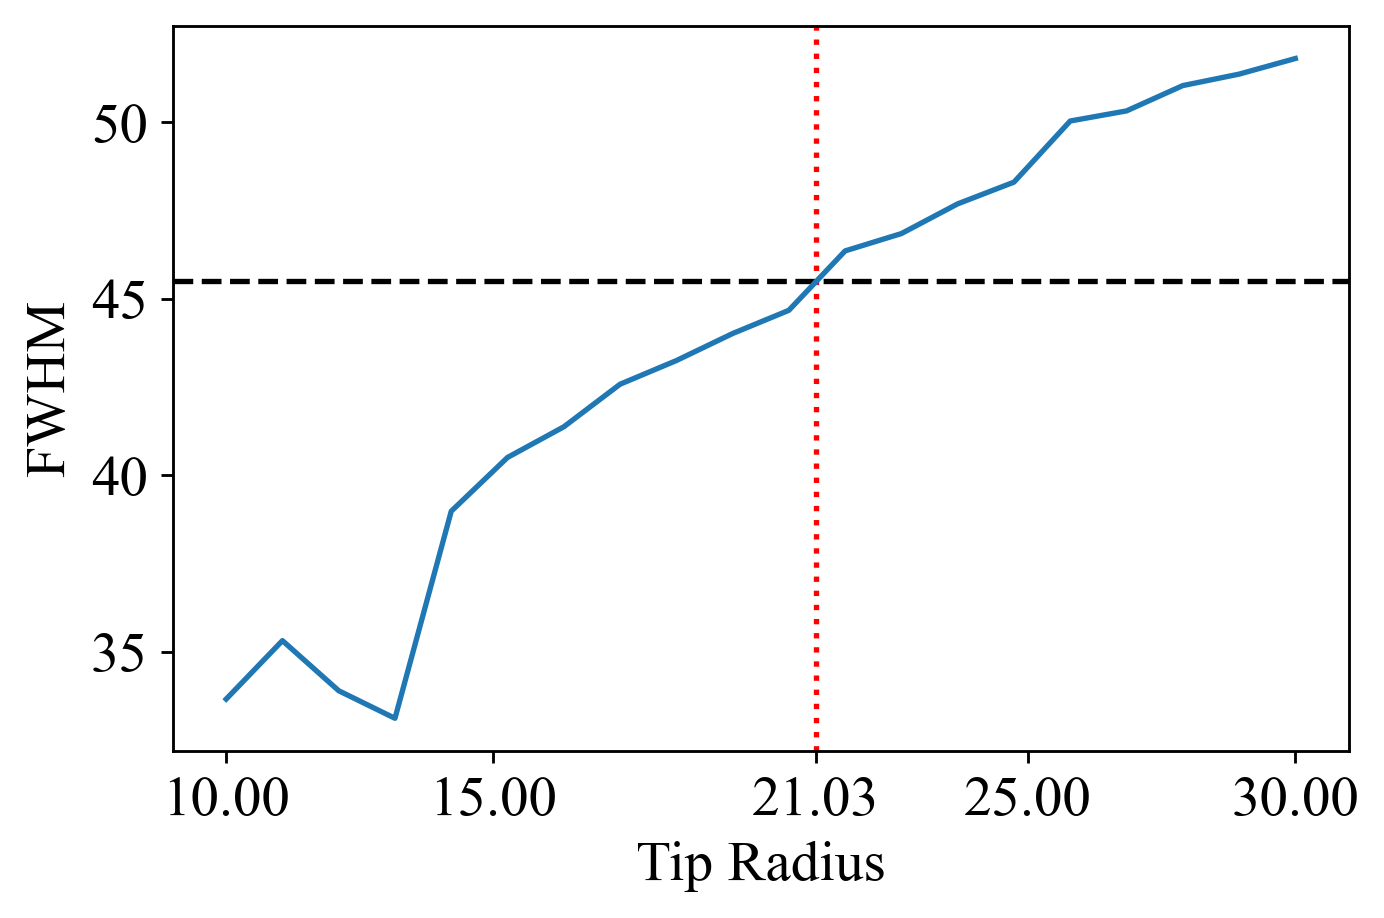

In [55]:
# Half maxima can be calculated by finding roots of spline 
intercept = UnivariateSpline(tip_size, FWHM_test-FWHM_exp[0], s = 0.01).roots()             

fig, ax = plt.subplots(figsize = (linewidth, 1/1.61*linewidth))
ax.axhline(FWHM_exp[0], color='k', ls='--', label = 'Experimental FWHM' )
ax.axvline(intercept, color='r', ls=':', label = 'Intercept')
ax.plot(tip_size,FWHM_test) 

ticks = list(ax.get_xticks())[1:-1] + [intercept[0]]
ticks.remove(20)
ticks.sort()
print(ticks)

ax.set_xlabel('Tip Radius')
ax.set_ylabel('FWHM')
ax.set_xticks(ticks)

plt.show()

[2.17725495e+08] [[1.209253e+14]]


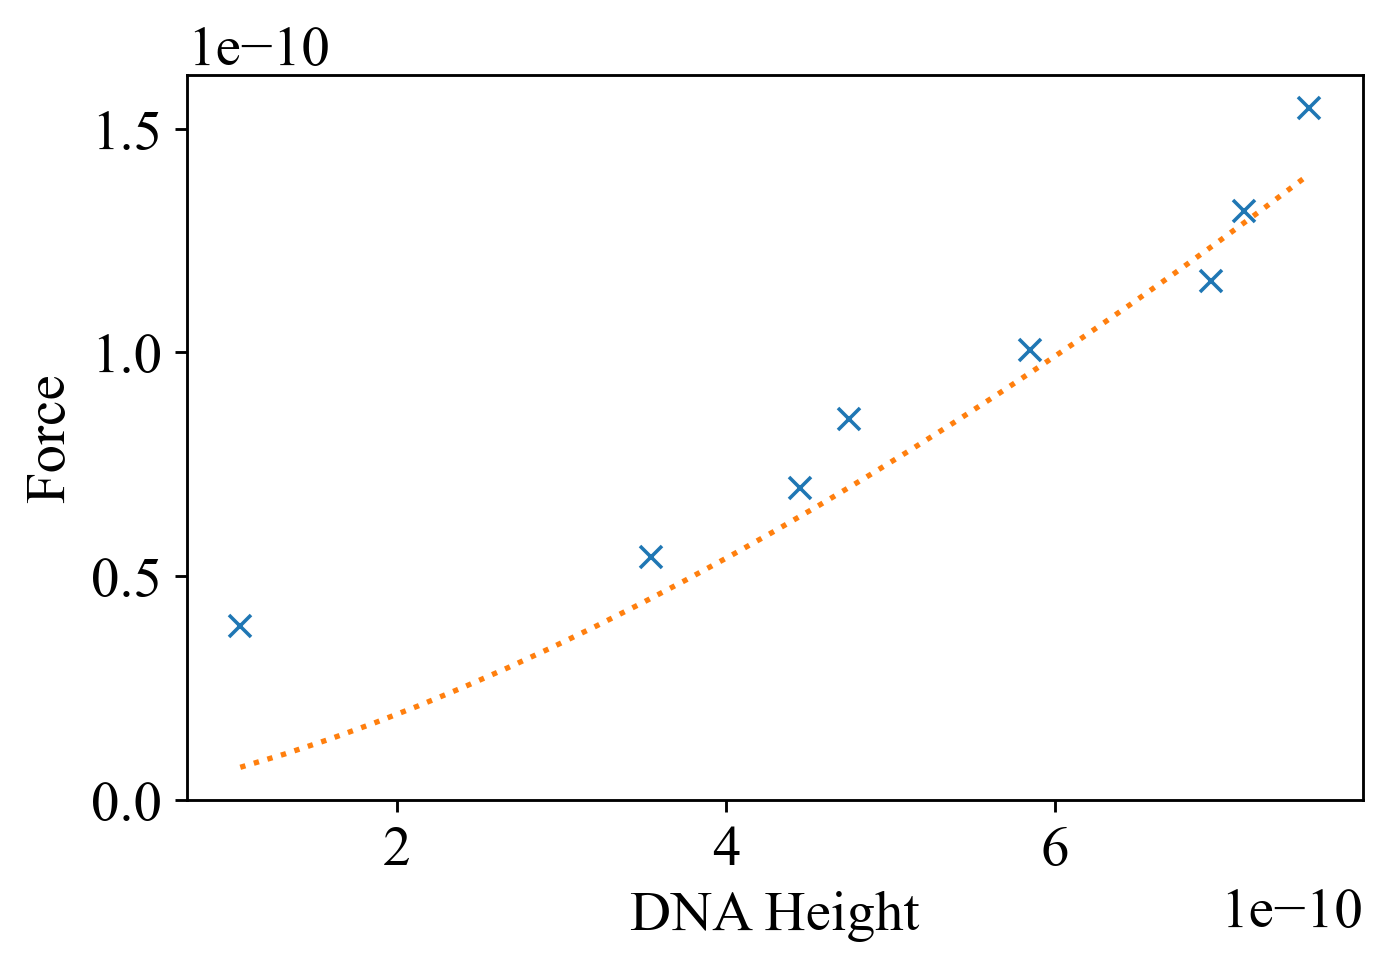

In [ ]:
# Produce array of fitted elastic modulus over scan positions for each indentor
u2, rf      = abs(1.*scanPos[:,2].max()-force_height_data[:-1,1])*1e-10, abs(force_height_data[:-1,0]*1e-12)
E_DNA, E_err = curve_fit(lambda x, E: F_Hertz(x, E, 20*1e-10, elasticProperties), u2, rf)

print(E_DNA,E_err)
x = np.linspace(u2.min(), u2.max(), 25)

fig, ax = plt.subplots(figsize = (linewidth, 1/1.61*linewidth))
ax.plot(u2, rf, 'x' ) 
ax.plot(x, F_Hertz(x, E_DNA, 17.88*1e-10, elasticProperties), ':' )
ax.set_xlabel('DNA Height')
ax.set_ylabel('Force')
# fig.savefig('/mnt/c/Users/Joshg/Downloads/' + os.sep + 'AFMHertzFit.png', bbox_inches = 'tight') # change to backslash for mac/google colab

plt.show()

## Postprocessing

In [56]:
# Produce true surface geometry, with small tip
surfaceSize = 1
temp_U2, temp_RF, temp_ErrorMask, surfacePos, surfaceDims, temp_baseDims, temp_variables = AFMSimulation(remote_server, remotePath, localPath, abqCommand, fileName, subData, 
pdb, rotation, surfaceApprox, indentorType, 1, 5, tip_length, indentionDepth, forceRef, contrast, surfaceSize, 0, elasticProperties, meshSurface, meshBase, 
meshIndentor,  timePeriod, timeInterval, Preprocess  = True, Submission  = False, Postprocess = False, ReturnData  = True, ClippedScan  = [0.45,1])

Structure exists: '/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/ABAQUS Notebook Simulations/afm/dn/bdna8.cif' 


/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))
/tmp/ipykernel_240553/3167173416.py:100: RuntimeWarning: invalid value encountered in sqrt
  dz = np.array([(zIndentor[:,None] - np.nan_to_num((zAtomMasked[i] + np.sqrt( rElementMasked[i]**2 - (r[:,None]-rInteractMasked[i])**2)),


Preprocessing Complete - 0:00:11.973256
Number of Scan Positions: 3763
Simulation Complete - 0:00:11.973382


In [57]:
waveLength, Nmax, binSize = 50, 125, variables[2]
courseGrain = 2.5

In [58]:
indentationForce, structuralData, XSectionData, YSectionData = DataAnalysis(U2, RF, force_data, scanPos, scanDims, binSize, clearance, waveLength, Nmax, courseGrain, rIndentor, elasticProperties, timeInterval, timePeriod)

/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_240553/3815902899.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hertz[i,t]  = popt
/home/jgiblinburnham/Documents/ABAQUS-AFM-Simulations/.venv/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [59]:
indentationForce, XSectionData, YSectionData = DataAnalysis(U2, RF, force_data, scanPos, scanDims, binSize, clearance, waveLength, Nmax, courseGrain, rIndentor, elasticProperties, timeInterval, timePeriod, NStructural=True)

/tmp/ipykernel_240553/3815902899.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hertz[i,t]  = popt
/tmp/ipykernel_240553/2317680203.py:5: RuntimeWarning: invalid value encountered in power
  return (2/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)


## Data Plots

In [60]:
plotTip1 = TipStructure(18, 10, 50)
plotTip2 = TipStructure(18, 10, 60) 

### Manuscript AFM Image 

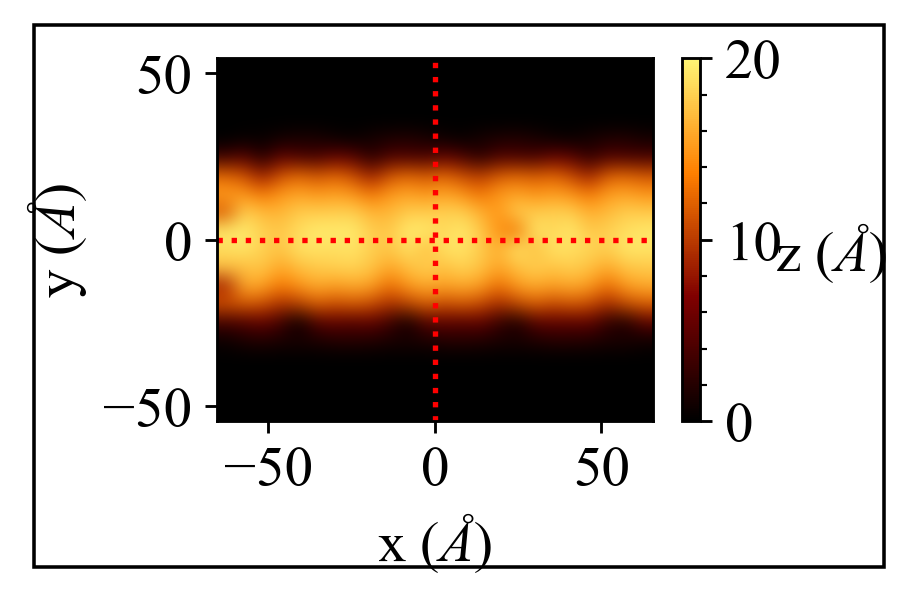

In [61]:
 ManuscriptAFMContourPlot(U2, RF, scanPos, scanDims, binSize, clearance, ErrorMask, forceRef, 1.4, pdb, SaveImages='/mnt/c/Users/Joshg/Documents/Manuscript_Figures/')

### Illustrations Plot

/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))


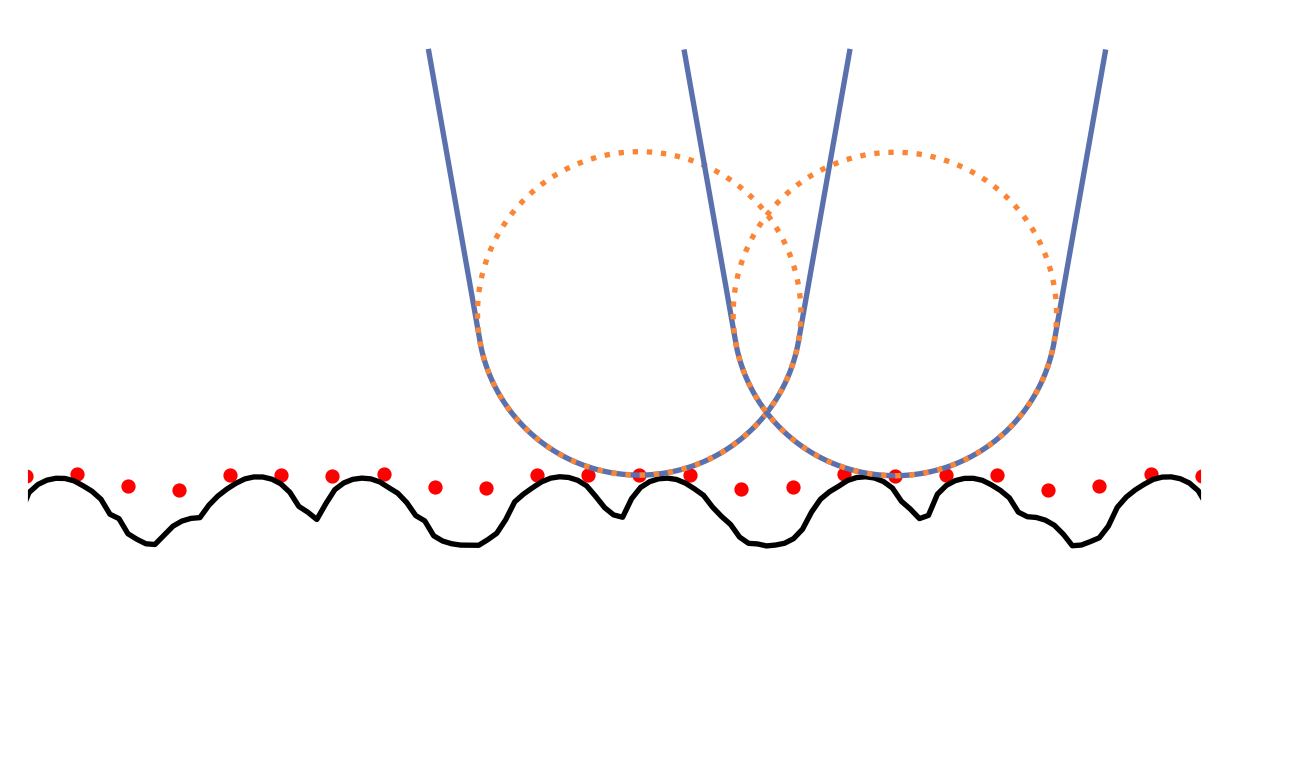

/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))


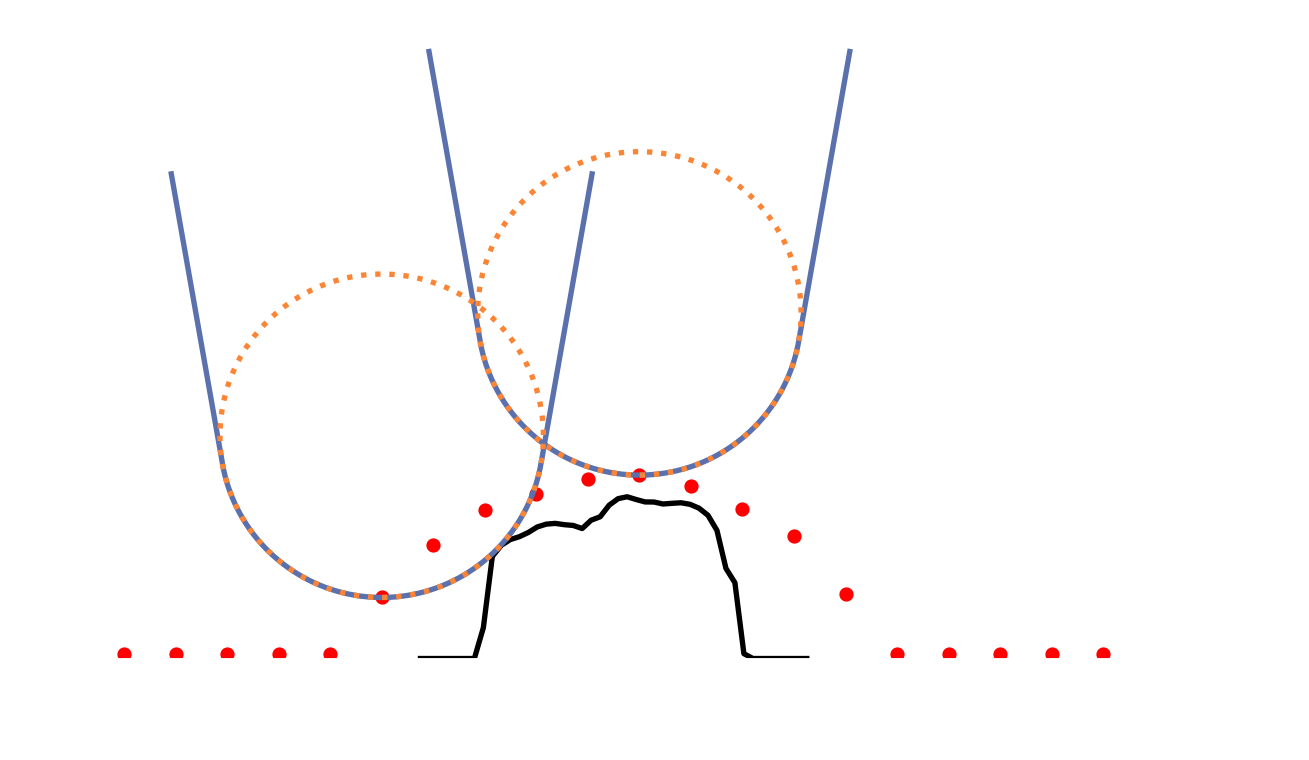

In [62]:
ManuscriptDiagram(scanPos, scanDims, binSize, surfacePos, surfaceDims, surfaceSize, plotTip1, SaveImages = '/mnt/c/Users/Joshg/Documents/Manuscript_Figures/')

/tmp/ipykernel_240553/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))


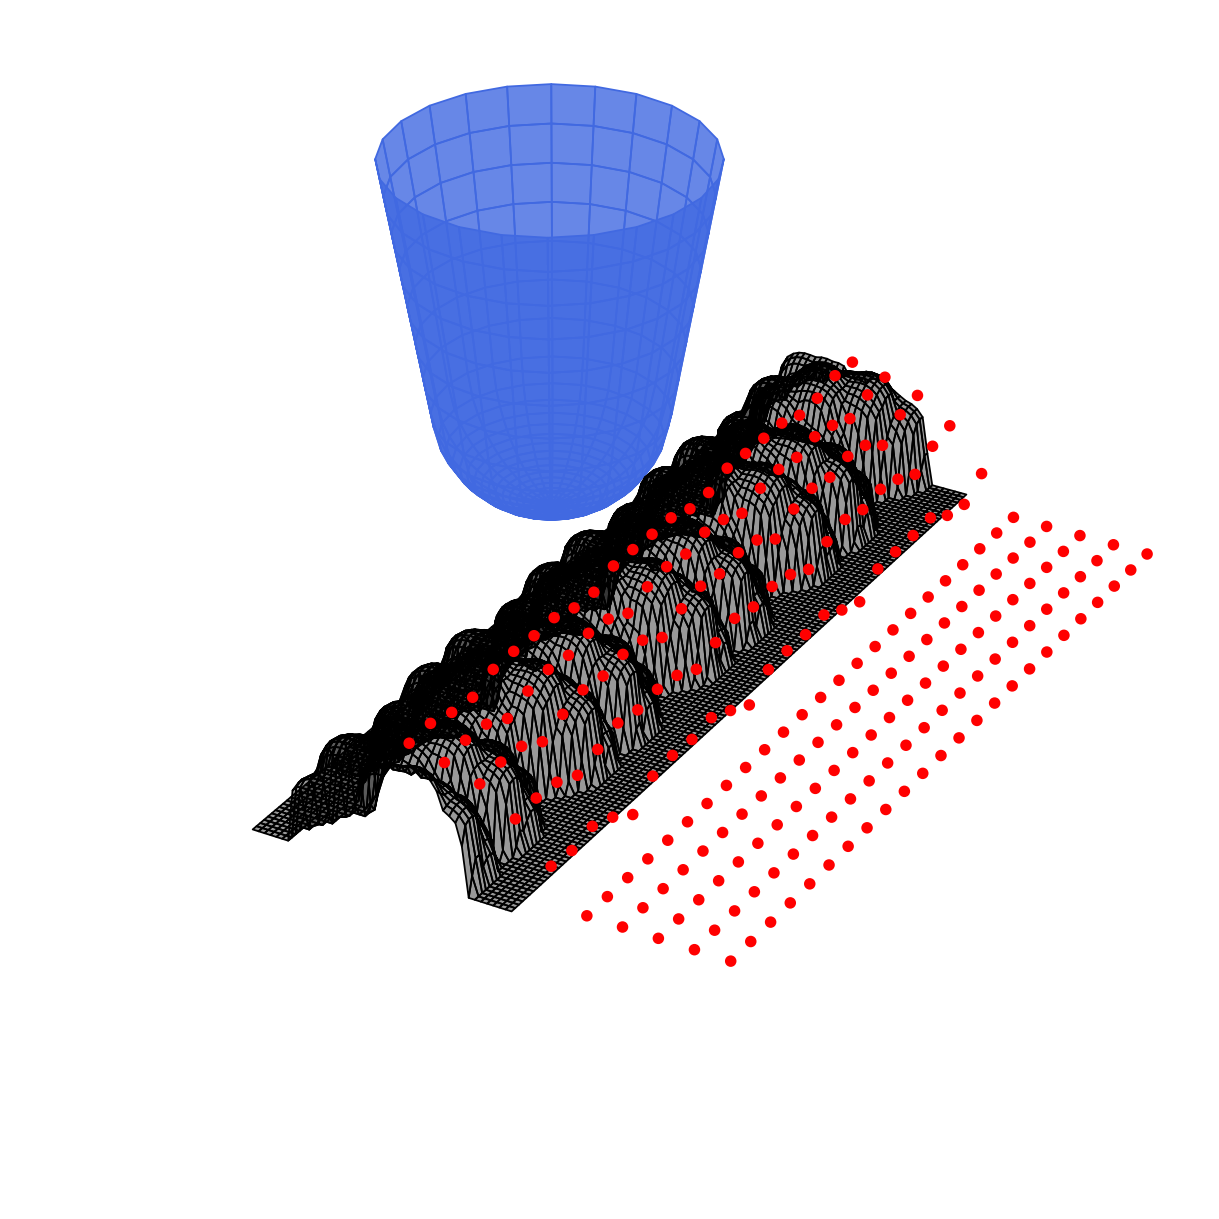

In [63]:
SurfacePlot(scanPos, scanDims, binSize, surfacePos, surfaceDims, surfaceSize, plotTip2, SaveImages = '/mnt/c/Users/Joshg/Documents/Manuscript_Figures' )

### Profile Plots

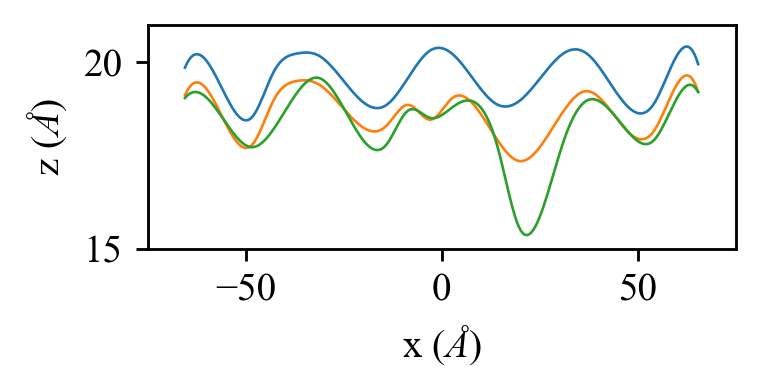

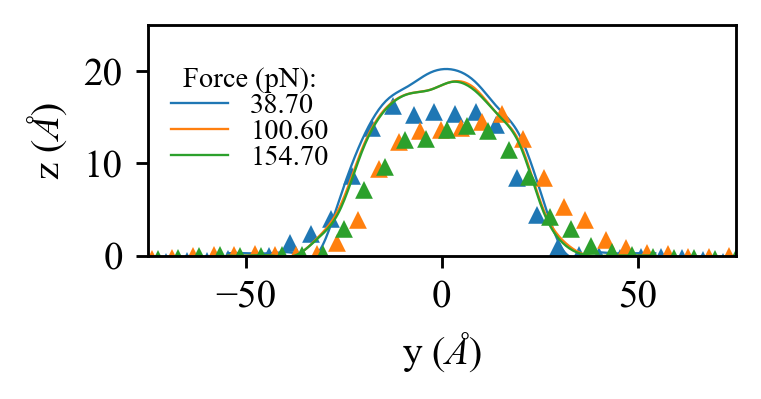

In [80]:
ForceProfiles(scanPos, scanDims, binSize, structuralData[0], structuralData[1], indentationForce, force_data, cross_section_height_data, data_length, SaveImages = '/mnt/c/Users/Joshg/Documents/Manuscript_Figures/')

### Structural Plots

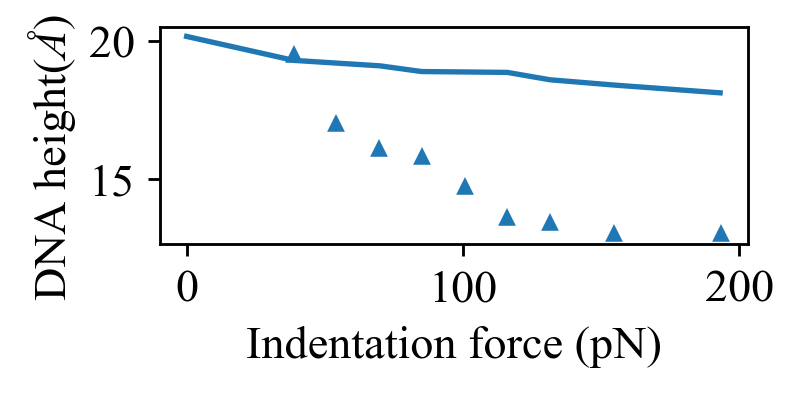

In [81]:
StructureAnalysisPlot(structuralData, indentationForce, force_data, force_height_data, FWHM_exp, AreaX_exp, SaveImages = '/mnt/c/Users/Joshg/Documents/Manuscript_Figures/')

### Contour Plots

/tmp/ipykernel_3303/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))


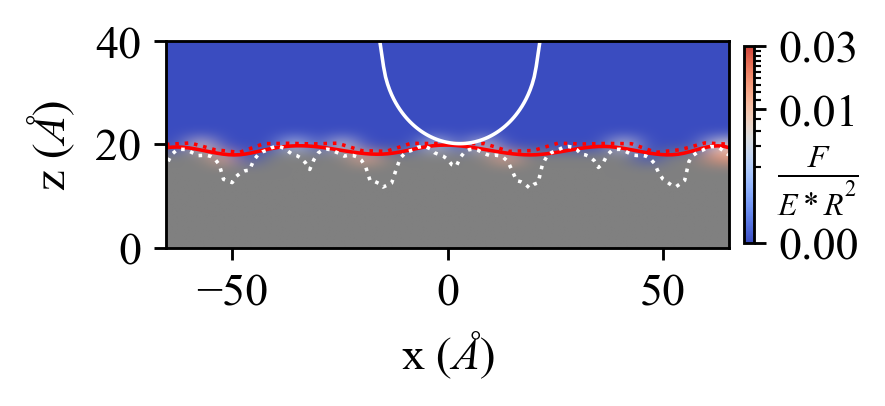

/tmp/ipykernel_3303/1058236140.py:28: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.clip( np.nan_to_num(R - np.sqrt(R**2 - (r-r0)**2), copy=False, nan=R ), a_min = 0, a_max = R-abs(z_int))


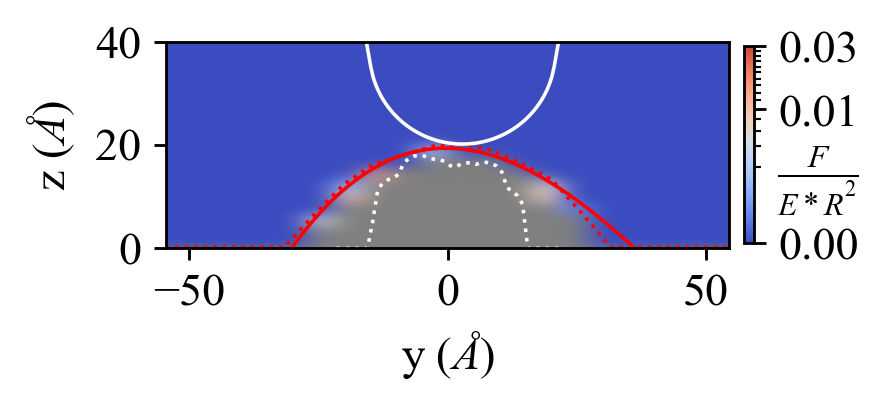

In [ ]:
AFMForceContours(RF, XSectionData, YSectionData, surfacePos, surfaceDims, surfaceSize, plotTip1, clearance, elasticProperties, contrast, 1, SaveImages = '/mnt/c/Users/Joshg/Documents/Manuscript_Figures/')

### Youngs Modulus

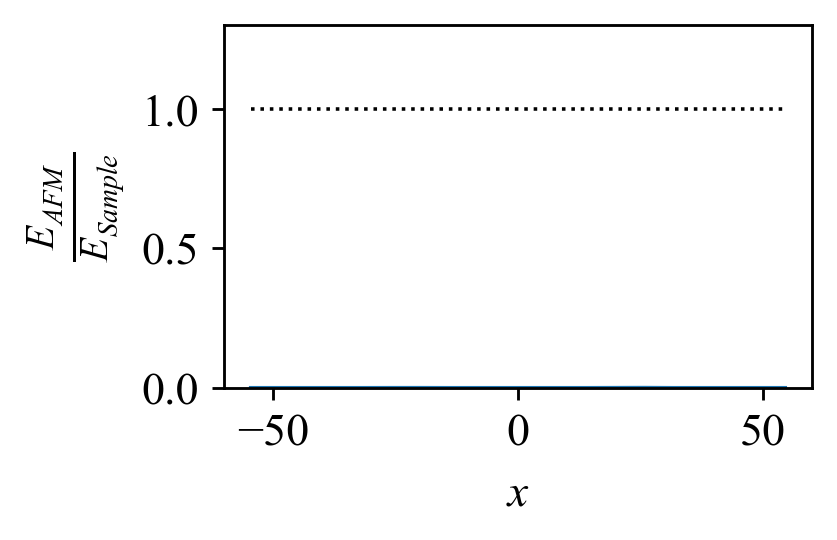

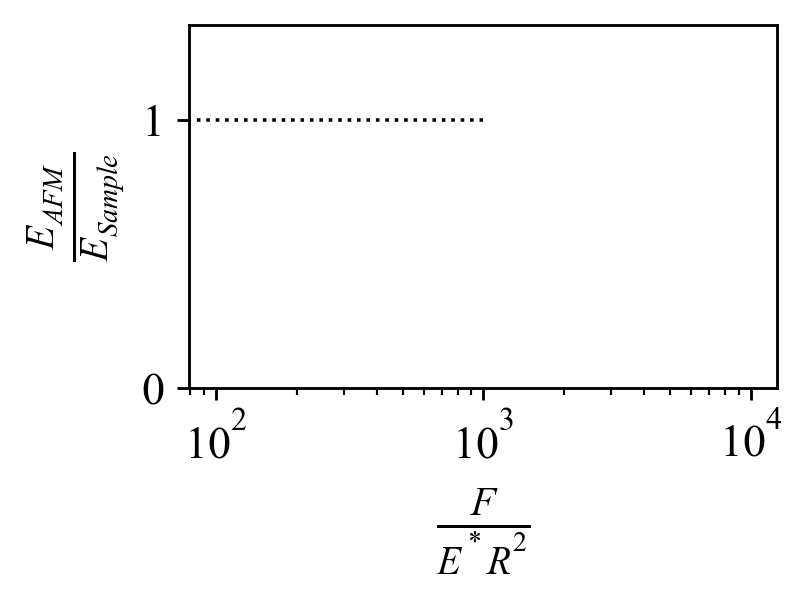

In [ ]:
# YoungPlot(XSectionData, rIndentor, elasticProperties, 37)
YoungPlot(YSectionData, rIndentor, elasticProperties, 3)

# Bash Commands

In [64]:
# remote_server = np.loadtxt('../../ssh/myriad.csv', dtype=str, delimiter=",")
# abqCommand  = 'module load abaqus/2017 \n abaqus cae -noGUI'
# abqCommand  = '/opt/abaqus2018/abq2018 cae -noGUI'
# abqCommand  = '/opt/abaqus614/Commands/abq6141 cae -noGUI'

In [65]:
# RemoteCommand(remote_server, '', home, 'qstat', ProxyJump = proxy_server)

In [66]:
# for i in range(383, len(clipped_scanPos)):
#     jobName = 'AFMRasterScan-Pos'+str(int(i))
#     RemoteCommand(remote_server, '', remotePath,'qsub -N '+ jobName +' batchScript.sh')

In [67]:
# RemoteCommand(remote_server, '',home,"qdel '*' ")

In [68]:
# t0 = time.time()

# fileType = ['*.023', '*.cid', '*.dat', '*.lck', '*.mdl', '*.com','*.SMABulk', 
#             '*.msg', '*.prt', '*.sim', '*.sta', '*.stt', '*.tmp',  '*.SMAFocus']
# for file in fileType:
#     RemoteCommand(remote_server, '',scratch, "find . -name "+ file +" -delete")

# t1 = time.time()
# print(t1-t0)

In [69]:
# Remote_Terminal(remote_server)